In [1]:
# recipe_path = '/path/to/cluster_metric.yaml'  # or /path/to/cluster_metric_save_intermediates.yaml
recipe_path = '/home/smeagol/code/quant-condensate/quant_condensate/recipes/cluster_metric.yaml'
# output_top_dir = '/where/you/want/outputs/saved'
output_top_dir = '/media/smeagol/ae1130e6-c525-47fe-adec-f6af8e76c0c7/cry2-vaton-and-vaxom'
folder_name = '20200218'  # subfolder name


# data directory
base = '/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113'

# figure output directory and resolution settings
fig_folder = 'plots_20200218'

dpi=300

n_procs = 12

In [2]:
import os
import glob
from PYME.IO import tabular, MetaDataHandler
import matplotlib.pyplot as plt
import numpy as np
from pandas import DataFrame
import seaborn as sns
import tables
from scipy import stats
from PYME.recipes.base import ModuleCollection
from PYME.recipes import batchProcess
import logging

logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)

Error loading plugin: nucleus.python_microscopy.recipe_modules.shell_fitting
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/recipes/modules.py", line 39, in <module>
    m = __import__(mn, fromlist=mn.split('.')[:-1])
ModuleNotFoundError: No module named 'nucleus'
Error loading plugin: cell_death_detection.python_microscopy.recipe_modules.cell_death
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/recipes/modules.py", line 39, in <module>
    m = __import__(mn, fromlist=mn.split('.')[:-1])
ModuleNotFoundError: No module named 'cell_death_detection'
Error loading plugin: nucleus.python_microscopy.recipe_modules.distance_to_membrane
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/recipes/modules.py", line 39, in <module>
    m = __import__(mn, fromlist=mn.split('.')[:-1])
ModuleNotFoundError: No module named 'nucleus'
Error loading plugin: bleaching_tools.python_microscopy.recip

Trying to load 3rd party recipe module localization_survey.recipe_modules.roi_cropping
Loaded 3rd party recipe module localization_survey.recipe_modules.roi_cropping
Trying to load 3rd party recipe module nucleus.python_microscopy.recipe_modules.shell_fitting
Trying to load 3rd party recipe module cell_death_detection.python_microscopy.recipe_modules.cell_death
Trying to load 3rd party recipe module quant_condensate.recipe_modules.cluster_quant
Loaded 3rd party recipe module quant_condensate.recipe_modules.cluster_quant
Trying to load 3rd party recipe module cb_analysis.python_microscopy.recipe_modules.cb_clustering
Loaded 3rd party recipe module cb_analysis.python_microscopy.recipe_modules.cb_clustering
Trying to load 3rd party recipe module nucleus.python_microscopy.recipe_modules.distance_to_membrane
Trying to load 3rd party recipe module nep_fitting.recipe_modules.nep_fits
Loaded 3rd party recipe module nep_fitting.recipe_modules.nep_fits
Trying to load 3rd party recipe module blea

In [3]:
with open(recipe_path) as f:
    contents = f.read()
recipe = ModuleCollection().fromYAML(contents)

output_directory = os.path.join(output_top_dir, folder_name)
try:
    os.mkdir(output_directory)
except:
    raise RuntimeError('Output directory already exists; exiting to avoid accidental replacement/appending to outputs')
fig_dir = os.path.join(output_directory, fig_folder)
try:
    os.mkdir(fig_dir)
except Exception as e:
    raise e
    
logger.addHandler(logging.FileHandler(os.path.join(output_directory, 'logging.txt')))
logger.debug('initializing file logging')

/home/smeagol/code/python-microscopy/PYME/recipes/base.py:620: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  l = yaml.load(data)


In [4]:
# this dictionary contains the data locations. The "label", e.g. 'A1' should be the key, then there's a nested
# dictionary which should be pretty self explanatory. These all need to be updated individually.
d_info = {
    # series unwanted can be commented out as shown
    # 'unwanted': {
    #     'top_folder': 'something'
    # },
    'A1': {
        'top_folder': os.path.join(base, 'A1')
    },
    'empty': {
        'top_folder': os.path.join(base, 'empty')
    },
    'SMNt': {
        'top_folder': os.path.join(base, 'SMNt')
    },
    'SMNt_new': {
        'top_folder': os.path.join(base, 'SMNt_new')
    },
    'SMNt_E134K': {
        'top_folder': os.path.join(base, 'SMNt_mutants')
    },
    'SMNt_F118L': {
        'top_folder': os.path.join(base, 'SMNt_mutants')
    },
    'SMNt_W102L': {
        'top_folder': os.path.join(base, 'SMNt_mutants')
    },
    'SMNt_Y109L': {
        'top_folder': os.path.join(base, 'SMNt_mutants')
    },
    'SMNt_Y130D': {
        'top_folder': os.path.join(base, 'SMNt_mutants')
    },
    'SMNt_MS023': {
        'top_folder': os.path.join(base, 'Cry2_SMNt_drugs')
    },
    'SMNt_MSEPZ': {
        'top_folder': os.path.join(base, 'Cry2_SMNt_drugs')
    },
    'SMNt_EPZ015666': {
        'top_folder': os.path.join(base, 'Cry2_SMNt_drugs')
    },
    'Spf30h': {
        'top_folder': os.path.join(base, 'Spf30human')
    }
}

In [5]:
# find all the inputs
series = []
cell_labels = []

for labeling in d_info:
    series_folders = [s for s in glob.glob(os.path.join(d_info[labeling]['top_folder'], 'TSeries-%s-*' % labeling))]
    for sf in series_folders:
        try:
            print(sf)
            series.append(glob.glob(os.path.join(sf, '*_Ch1.tif'))[0])
            print(len(series))
            cell_labels.append(glob.glob(os.path.join(sf, '*_Cell-outlines.tiff'))[0])
        except Exception as e:
            print('Missing files. Labeling: %s, series folder: %s' % (str(labeling), str(sf)))
            raise e

input_globs = {
    'input': series,
    'input_labeled_cells': cell_labels
}
batchProcess.bake(recipe, input_globs, output_directory, num_procs=n_procs)

/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/A1/TSeries-A1-180820-014
1
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/A1/TSeries-A1-180820-002
2
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/A1/TSeries-A1-180820-010
3
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/A1/TSeries-A1-180820-015
4
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/A1/TSeries-A1-180820-006
5
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/A1/TSeries-A1-180820-012
6
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/A1/TSeries-A1-180820-005
7
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/A1/TSeries-A1-180820-016
8
/media/s

271
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_W102L-181123-004
272
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_W102L-181123-008
273
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_W102L-181114-002
274
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_W102L-181123-010
275
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_W102L-180830-003
276
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_W102L-181114-010
277
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_W102L-180

filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/A1/TSeries-A1-180820-008/TSeries-A1-180820-008_Ch1.tif
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/empty/TSeries-empty-180813-014/TSeries-empty-180813-014_Ch1.tif
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/empty/TSeries-empty-180813-001/TSeries-empty-180813-001_Ch1.tif
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/empty/TSeries-empty-180813-002/TSeries-empty-180813-002_Ch1.tif
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/empty/TSeries-empty-181024-006/TSeries-empty-181024-006_Ch1.tif
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/empty/TSeries-empty-181019-001/TSer

Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'

filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/A1/TSeries-A1-180820-008/TSeries-A1-180820-008_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
[512, 512, 190, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/empty/TSeries-empty-180813-014/TSeries-empty-180813-014_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(190, 512, 512)


Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'Loading .tiff with internal code not bioformats, is this really what you wanted?
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.

filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/A1/TSeries-A1-180820-014/TSeries-A1-180820-014_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
[512, 512, 190, 1]
(190, 512, 512)


Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'


filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/empty/TSeries-empty-181024-006/TSeries-empty-181024-006_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/empty/TSeries-empty-180813-002/TSeries-empty-180813-002_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
[512, 512, 190, 1]




Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'


[512, 512, 190, 1]


Loading .tiff with internal code not bioformats, is this really what you wanted?
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.
Loading .tiff with internal code not bioformats, is this really what you wanted?
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


(190, 512, 512)
[512, 512, 190, 1]


Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'

filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-181017-002/TSeries-SMNt-181017-002_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
[512, 512, 190, 1]


Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'Loading .tiff with internal code not bioformats, is this really what you wanted?
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.Loading .tiff with internal code not bioformats, is this really what you wanted?
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.   

[512, 512, 190, 1]
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/empty/TSeries-empty-180813-014/TSeries-empty-180813-014_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff


[512, 512, 190, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/empty/TSeries-empty-181019-001/TSeries-empty-181019-001_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)


Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'Loading .tiff with internal code not bioformats, is this really what you wanted?
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.

filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/A1/TSeries-A1-180828-002/TSeries-A1-180828-002_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
[512, 512, 1, 1]



Loading .tiff with internal code not bioformats, is this really what you wanted?
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.

/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/A1/TSeries-A1-180820-014/TSeries-A1-180820-014_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/empty/TSeries-empty-180813-001/TSeries-empty-180813-001_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
[512, 512, 1, 1]


Loading .tiff with internal code not bioformats, is this really what you wanted?
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


(512, 512)


Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'

[512, 512, 1, 1]


(190, 512, 512)


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/empty/TSeries-empty-180813-002/TSeries-empty-180813-002_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
[512, 512, 190, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif


Loading .tiff with internal code not bioformats, is this really what you wanted?
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.

(512, 512)
(512, 512)
[512, 512, 1, 1]
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-181017-002/TSeries-SMNt-181017-002_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff


Loading .tiff with internal code not bioformats, is this really what you wanted?
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.

[512, 512, 1, 1]
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/empty/TSeries-empty-181024-006/TSeries-empty-181024-006_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/A1/TSeries-A1-180820-008/TSeries-A1-180820-008_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
[512, 512, 190, 1]
[512, 512, 1, 1]
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/A1/TSeries-A1-180828-002/TSeries-A1-180828-002_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
(512, 512)
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-181024-008/TSeries-SMNt-181024-008_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
(512, 512)
[512, 512, 1, 1]
(190, 512, 512)
[512, 512, 1, 1]
[512, 512, 190, 1]
[512, 512, 1, 1]
[512, 512, 190, 1]
filename =

Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'

[512, 512, 1, 1]
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
Detected OME TIFF
[512, 512, 1, 1]
[512, 512, 1, 1]
[512, 512, 1, 1]
[512, 512, 1, 1]


Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'

[512, 512, 1, 1]


filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}



Loading .tiff with internal code not bioformats, is this really what you wanted?
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.

[1, 1, 1, 512, 512]
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif



Loading .tiff with internal code not bioformats, is this really what you wanted?
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.

[512, 512, 1, 1]


[1, 1, 1, 512, 512]
[512, 512, 1, 1]
Detected OME TIFF
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-180905-009/TSeries-SMNt-180905-009_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
[512, 512, 1, 1]
[512, 512, 1, 1]
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-181024-008/TSeries-SMNt-181024-008_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
(512, 512)
[512, 512, 1, 1]
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_1

/home/smeagol/code/python-microscopy/PYME/IO/DataSources/ArrayDataSource.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  r = self.data.__getitem__(keys)
/home/smeagol/code/python-microscopy/PYME/IO/DataSources/ArrayDataSource.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  r = self.data.__getitem__(keys)
/home/smeagol/code/python-microscopy/PYME/IO/DataSources/ArrayDataSource.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future th

[64, 128, 191, 255]


/home/smeagol/code/python-microscopy/PYME/IO/DataSources/ArrayDataSource.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  r = self.data.__getitem__(keys)
/home/smeagol/code/python-microscopy/PYME/IO/DataSources/ArrayDataSource.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  r = self.data.__getitem__(keys)
/home/smeagol/code/python-microscopy/PYME/IO/DataSources/ArrayDataSource.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future th

[85, 170, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/A1/TSeries-A1-180820-002/TSeries-A1-180820-002_Ch1.tif
[64, 128, 191, 255]


/home/smeagol/code/python-microscopy/PYME/IO/DataSources/ArrayDataSource.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  r = self.data.__getitem__(keys)


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/A1/TSeries-A1-180820-002/TSeries-A1-180820-002_Ch1.tif
(190, 512, 512)
[512, 512, 190, 1]
[512, 512, 190, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/A1/TSeries-A1-180820-002/TSeries-A1-180820-002_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff


ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/A1/TSeries-A1-180820-002/TSeries-A1-180820-002_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/empty/TSeries-empty-180813-017/TSeries-empty-180813-017_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/empty/TSeries-empty-180813-017/TSeries-empty-180813-017_Ch1.tif
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/empty/TSeries-empty-180813-017/TSeries-empty-180813-017_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(190, 512, 512)
(512, 512)
[512, 512, 1, 1]
[512, 512, 190, 1]
[512, 512, 1, 1]
[512, 512, 190, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-181017-009/TSeries-SMNt-181017-009_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff


ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.

/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif


[1, 1, 1, 512, 512]
Detected OME TIFF
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-181017-009/TSeries-SMNt-181017-009_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[128, 255]
[128, 255]
[51, 102, 153, 204, 255]
[64, 128, 191, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-181017-003/TSeries-SMNt-181017-003_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-181017-003/TSeries-SMNt-181017-003_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/empty/TSeries-empty-180813-012/TSeries-empty-180813-012_Ch1.tif
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-180822-008/TSeries-SMNt-180822-008_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_caj

/home/smeagol/code/python-microscopy/PYME/IO/DataSources/ArrayDataSource.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  r = self.data.__getitem__(keys)


[85, 170, 255]
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-180822-008/TSeries-SMNt-180822-008_Ch1.tif
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-180822-002/TSeries-SMNt-180822-002_Ch1.tif
(190, 512, 512)
[512, 512, 190, 1]
[512, 512, 190, 1]
[64, 128, 191, 255]
(190, 512, 512)
[512, 512, 190, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/empty/TSeries-empty-180813-012/TSeries-empty-180813-012_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
[512, 512, 190, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-180822-008/TSeries-SMNt-180822-008_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
[85, 170, 255]


ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'

/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-180822-002/TSeries-SMNt-180822-002_Ch1.tif



ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'WARNING:PYME.IO.image:Loading .tiff with internal code not bioformats, is this really what you wanted?
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.



                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.

/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/empty/TSeries-empty-180813-012/TSeries-empty-180813-012_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff


(512, 512)
(190, 512, 512)
[512, 512, 1, 1]
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-180822-008/TSeries-SMNt-180822-008_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
[512, 512, 1, 1]
[512, 512, 190, 1]
(512, 512)
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[512, 512, 190, 1]
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-180822-002/TSeries-SMNt-180822-002_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff


ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'

[64, 128, 191, 255]
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif


[1, 1, 1, 512, 512]


                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[1, 1, 1, 512, 512]
[512, 512, 1, 1]
Detected OME TIFF
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-180822-002/TSeries-SMNt-180822-002_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[512, 512, 1, 1]
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-180905-011/TSeries-SMNt-180905-011_Ch1.tif
/media/smeagol

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/A1/TSeries-A1-180820-004/TSeries-A1-180820-004_Ch1.tif
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/empty/TSeries-empty-180813-016/TSeries-empty-180813-016_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-180905-011/TSeries-SMNt-180905-011_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/empty/TSeries-empty-181019-002/TSeries-empty-181019-002_Ch1.tif
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'

                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.WARNING:PYME.IO.image:Loading .tiff with internal code not bioformats, is this really 

/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/empty/TSeries-empty-181019-002/TSeries-empty-181019-002_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/A1/TSeries-A1-180820-004/TSeries-A1-180820-004_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
(512, 512)
[512, 512, 1, 1]
(190, 512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
[512, 512, 190, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[512, 512, 190, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/empty/TSeries-empty-180813-016/TSeries-empty-180813-016_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
[512, 512, 1, 1]
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif


ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'


[1, 1, 1, 512, 512]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif


                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.

[1, 1, 1, 512, 512]
[512, 512, 1, 1]
[512, 512, 1, 1]


Detected OME TIFF
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/empty/TSeries-empty-180813-016/TSeries-empty-180813-016_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[85, 170, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/empty/TSeries-empty-181024-009/TSeries-empty-181024-009_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/empty/TSeries-empt

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/empty/TSeries-empty-181024-009/TSeries-empty-181024-009_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[64, 128, 191, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/A1/TSeries-A1-180820-010/TSeries-A1-180820-010_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/A1/TSeries-A1-180820-010/TSeries-A1-180820-010_Ch1.tif
(190, 512, 512)
[512, 512, 190, 1]
[512, 512, 190, 1]
filename == /me

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/A1/TSeries-A1-180820-010/TSeries-A1-180820-010_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[128, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-180822-015/TSeries-SMNt-180822-015_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-180822-015/TSeries-SMNt-180822-015_Ch1.tif
(190, 512, 512)
[512, 512, 190, 1]
[512, 512, 190, 1]
filename == /media/sm

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-180822-015/TSeries-SMNt-180822-015_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[64, 128, 191, 255]
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[64, 128, 191, 255]
[85, 170, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-180815-015/TSeries-SMNt-180815-015_Ch1.tif
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-180815-002/TSeries-SMNt-180815-002_Ch1.tif
/media/smeago

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-180815-002/TSeries-SMNt-180815-002_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/empty/TSeries-empty-180813-011/TSeries-empty-180813-011_Ch1.tif
[85, 170, 255]
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-180815-015/TSeries-SMNt-180815-015_Ch1.tif
(190, 512, 512)
[512, 512, 190, 1]
[512, 512, 190, 1]
filename

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-180815-015/TSeries-SMNt-180815-015_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/empty/TSeries-empty-180813-011/TSeries-empty-180813-011_Ch1.tif
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-180815-007/TSeries-SMNt-180815-007_Ch1.tif
(190, 512, 512)
[85, 170, 255]
[512, 512, 190, 1]
[512, 512, 190, 1]
filename

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/empty/TSeries-empty-180813-011/TSeries-empty-180813-011_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[85, 170, 255]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/empty/TSeries-empty-181017-004/TSeries-empty-181017-004_Ch1.tif
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/A1/TSeries-A1-180820-013/TSeries-A1-180820-013_Ch1.tif
[128, 255]
/media/smeagol/d5b5c790-4eba-4212-b990-062

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'


[51, 102, 153, 204, 255]


                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-180815-007/TSeries-SMNt-180815-007_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/empty/TSeries-empty-181017-008/TSeries-empty-181017-008_Ch1.tif
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/empty/TSeries-empty-180813-013/TSeries-empty-180813-013_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/A1/TSeries-A1-180820-013/TSeries-A1-180820-013_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[36, 73, 109, 146, 182, 219, 255]
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/empty/TSeries-empty-181017-004/TSeries-empty-181017-004_Ch1.tif
(190, 512, 512)
[512, 512, 190, 1]
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/empty/TSeries-empty-181017-008/TSeries-empty-181017-008_Ch1.tif
[512, 512, 190, 1]
file

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


(190, 512, 512)
[512, 512, 190, 1]
[512, 512, 190, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/empty/TSeries-empty-181017-008/TSeries-empty-181017-008_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/empty/TSeries-empty-181017-004/TSeries-empty-181017-004_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff


ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.

filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-181024-002/TSeries-SMNt-181024-002_Ch1.tif


(512, 512)
[512, 512, 1, 1]
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/empty/TSeries-empty-181017-008/TSeries-empty-181017-008_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
/media/s

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/empty/TSeries-empty-180813-013/TSeries-empty-180813-013_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-181024-002/TSeries-SMNt-181024-002_Ch1.tif
(190, 512, 512)
[512, 512, 190, 1]
[512, 512, 190, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-181024-002/TSeries-SMNt-181024-002_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff


ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'


(512, 512)


                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-181024-002/TSeries-SMNt-181024-002_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
(512, 512)
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[64, 128, 191, 255]
fi

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/empty/TSeries-empty-181019-009/TSeries-empty-181019-009_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[85, 170, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/A1/TSeries-A1-180820-015/TSeries-A1-180820-015_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/A1/TSeries-A1-180820-015/TSeries-A1-180820-015_Ch1.tif
(190, 512, 512)
[512, 512, 190, 1]
[512, 512, 190, 1]
filename == /media/s

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/A1/TSeries-A1-180820-015/TSeries-A1-180820-015_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[85, 170, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-181024-009/TSeries-SMNt-181024-009_Ch1.tif
[51, 102, 153, 204, 255]
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-181024-009/TSeries-SMNt-181024-009_Ch1.tif
(190, 512, 512)
[512, 512, 190, 1]
[512, 512, 

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-181024-009/TSeries-SMNt-181024-009_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[128, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-180815-013/TSeries-SMNt-180815-013_Ch1.tif
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-180830-002/TSeries-SMNt-180830-002_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-180815-013/TSeries-SMNt-180815-013_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-180830-002/TSeries-SMNt-180830-002_Ch1.tif
(190, 512, 512)
[512, 512, 190, 1]
[512, 512, 190, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-180830-002/TSeries-SMNt-180830-002_Cycle00002_Ch1_000001.ome_Cell-out

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-180830-002/TSeries-SMNt-180830-002_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[85, 170, 255]
[128, 255]
[85, 170, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/empty/TSeries-empty-181017-006/TSeries-empty-181017-006_Ch1.tif
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/empty/TSeries-empty-181024-008/TSeries-empty-181024-008_Ch1.tif
filename == /media/sm

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.

/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-180830-009/TSeries-SMNt-180830-009_Ch1.tif


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/empty/TSeries-empty-181017-006/TSeries-empty-181017-006_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
(190, 512, 512)
[512, 512, 1, 1]
[512, 512, 190, 1]
[512, 512, 190, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-180830-009/TSeries-SMNt-180830-009_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/empty/TSeries-empty-181024-008/TSeries-empty-181024-008_Ch1.tif
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif


ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.

/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF


sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-180830-009/TSeries-SMNt-180830-009_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(190, 512, 512)
[512, 512, 190, 1]
[512, 512, 190, 1]
(512, 512)
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/empty/TSeries-empty-181024-008/TSeries-empty-181024-008_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff


ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'

[512, 512, 1, 1]
[512, 512, 1, 1]



                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.

filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
[42, 85, 128, 170, 212, 255]
Detected OME TIFF
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/empty/TSeries-empty-181024-008/TSeries-empty-181024-008_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-180815-003/TSeries-SMNt-180815

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-180815-003/TSeries-SMNt-180815-003_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[85, 170, 255]
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/empty/TSeries-empty-181019-008/TSeries-empty-181019-008_Ch1.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[64, 128, 191, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/A1/TSeries-A1-180820-001/TSeries-A1-180820-001_Ch1.tif
[64, 128, 191, 255]
filename == /med

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/empty/TSeries-empty-181019-008/TSeries-empty-181019-008_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/empty/TSeries-empty-180813-007/TSeries-empty-180813-007_Ch1.tif
(190, 512, 512)
[512, 512, 190, 1]
[512, 512, 190, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/empty/TSeries-empty-180813-007/TSeries-empty-180813-007_Cycle00002_Ch1_000001.ome

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/A1/TSeries-A1-180820-001/TSeries-A1-180820-001_Ch1.tif


                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/empty/TSeries-empty-180813-007/TSeries-empty-180813-007_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(190, 512, 512)
[512, 512, 190, 1]
[512, 512, 190, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/A1/TSeries-A1-180820-001/TSeries-A1-180820-001_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff


ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'

(512, 512)



                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.

[512, 512, 1, 1]


[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/A1/TSeries-A1-180820-001/TSeries-A1-180820-001_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/empty/TSeries-empty-180813-004/T

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/empty/TSeries-empty-180813-004/TSeries-empty-180813-004_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[64, 128, 191, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/A1/TSeries-A1-180820-006/TSeries-A1-180820-006_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/A1/TSeries-A1-180820-006/TSeries-A1-180820-006_Ch1.tif
(190, 512, 512)
[512, 512, 190, 1]
[512, 512, 190, 1]
filename == /me

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/A1/TSeries-A1-180820-006/TSeries-A1-180820-006_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[85, 170, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-180822-013/TSeries-SMNt-180822-013_Ch1.tif
[51, 102, 153, 204, 255]
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-180822-013/TSeries-SMNt-180822-013_Ch1.tif
(190, 512, 512)
[512, 512, 190, 1]
[512, 512, 

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-180822-013/TSeries-SMNt-180822-013_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-180815-005/TSeries-SMNt-180815-005_Ch1.tif
[64, 128, 191, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-180830-010/TSeries-SMNt-180830-010_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-180815-005/TSeries-SMNt-180815-005_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-180830-010/TSeries-SMNt-180830-010_Ch1.tif
(190, 512, 512)
[512, 512, 190, 1]
[512, 512, 190, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-180830-010/TSeries-SMNt-180830-010_Cycle00002_Ch1_000001.ome_Cell-out

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-180830-010/TSeries-SMNt-180830-010_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[51, 102, 153, 204, 255]
[128, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/A1/TSeries-A1-180820-009/TSeries-A1-180820-009_Ch1.tif
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/empty/TSeries-empty-181019-004/TSeries-empty-181019-004_Ch1.tif
[128, 255]
/media/smeagol/d5b5c790-

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/A1/TSeries-A1-180820-009/TSeries-A1-180820-009_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/empty/TSeries-empty-181019-004/TSeries-empty-181019-004_Ch1.tif
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
(190, 512, 512)
[512, 512, 1, 1]
[512, 512, 190, 1]
[512, 512, 190, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/empty/TSeries-empty-181019-004/TSeries-empty-181019-004_Cycle00002_Ch1_000001.ome_Cell-out

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/empty/TSeries-empty-181019-004/TSeries-empty-181019-004_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/empty/TSeries-empty-181019-010/TSeries-empty-181019-010_Ch1.tif
[51, 102, 153, 204, 255]
[36, 73, 109, 146, 182, 219, 255]
[85, 170, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-181024-011/TSeries-SMNt-181024-

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/empty/TSeries-empty-181019-010/TSeries-empty-181019-010_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[85, 170, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-181017-012/TSeries-SMNt-181017-012_Ch1.tif
[64, 128, 191, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/empty/TSeries-empty-181017-007/TSeries-empty-181017-007_Ch1.tif
/media/smeagol/d5b5c790-4eb

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/empty/TSeries-empty-180813-015/TSeries-empty-180813-015_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-181017-012/TSeries-SMNt-181017-012_Ch1.tif
[512, 512, 1, 1]
(190, 512, 512)
[512, 512, 190, 1]
[512, 512, 190, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-181017-012/TSeries-SMNt-181017-012_Cycle00002_Ch1_000001.ome_Cell-

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-181017-012/TSeries-SMNt-181017-012_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-181024-011/TSeries-SMNt-181024-011_Ch1.tif
(190, 512, 512)
[512, 512, 190, 1]
[512, 512, 190, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-181024-011/TSeries-SMNt-181024-011_Cycle00002_Ch1_000001.ome_Cell-out

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-181024-011/TSeries-SMNt-181024-011_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/empty/TSeries-empty-181017-007/TSeries-empty-181017-007_Ch1.tif
(190, 512, 512)
[512, 512, 190, 1]
[512, 512, 190, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/empty/TSeries-empty-181017-007/TSeries-empty-181017-007_Cycle00002_Ch1_000001.ome_Ce

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/empty/TSeries-empty-181017-007/TSeries-empty-181017-007_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/empty/TSeries-empty-180813-009/TSeries-empty-180813-009_Ch1.tif
(190, 512, 512)
[512, 512, 190, 1]
[512, 512, 190, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/empty/TSeries-empty-180813-009/TSeries-empty-180813-009_Cycle00002_Ch1_000001.ome

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/empty/TSeries-empty-180813-009/TSeries-empty-180813-009_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[64, 128, 191, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/A1/TSeries-A1-180820-012/TSeries-A1-180820-012_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/A1/TSeries-A1-180820-012/TSeries-A1-180820-012_Ch1.tif
(190, 512, 512)
[512, 512, 190, 1]
[512, 512, 190, 1]
filename == /me

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/A1/TSeries-A1-180820-012/TSeries-A1-180820-012_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[85, 170, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-180815-008/TSeries-SMNt-180815-008_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-180815-008/TSeries-SMNt-180815-008_Ch1.tif
(190, 512, 512)
[512, 512, 190, 1]
[512, 512, 190, 1]
filename == /medi

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-180815-008/TSeries-SMNt-180815-008_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[51, 102, 153, 204, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-180822-009/TSeries-SMNt-180822-009_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-180822-009/TSeries-SMNt-180822-009_Ch1.tif
(190, 512, 512)
[512, 512, 190, 1]
[512, 512, 190, 1]
f

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-180822-009/TSeries-SMNt-180822-009_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[85, 170, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-180822-003/TSeries-SMNt-180822-003_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-180822-003/TSeries-SMNt-180822-003_Ch1.tif
(190, 512, 512)
[512, 512, 190, 1]
[512, 512, 190, 1]
filename ==

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-180822-003/TSeries-SMNt-180822-003_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[64, 128, 191, 255]
[64, 128, 191, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/empty/TSeries-empty-180813-018/TSeries-empty-180813-018_Ch1.tif
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/empty/TSeries-empty-181019-006/TSeries-empty-181019-006_Ch1.tif
/media/smeagol/d5b5c79

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/empty/TSeries-empty-180813-018/TSeries-empty-180813-018_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/empty/TSeries-empty-181019-006/TSeries-empty-181019-006_Ch1.tif
[255]
[32, 64, 96, 128, 159, 191, 223, 255]
(190, 512, 512)
[512, 512, 190, 1]
[512, 512, 190, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/empty/TSeries-empty-181019-006/TSerie

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/empty/TSeries-empty-181019-006/TSeries-empty-181019-006_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-180822-006/TSeries-SMNt-180822-006_Ch1.tif
[85, 170, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/empty/TSeries-empty-181024-005/TSeries-empty-181024-005_Ch1.tif
[51, 102, 153, 204, 255]
filename == /media/sme

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-180822-006/TSeries-SMNt-180822-006_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[42, 85, 128, 170, 212, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/empty/TSeries-empty-180813-010/TSeries-empty-180813-010_Ch1.tif
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/empty/TSeries-empty-180813-003/TSeries-empty-180813-003_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.
ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/empty/TSeries-empty-181024-005/TSeries-empty-181024-005_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff


                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-180830-004/TSeries-SMNt-180830-004_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/A1/TSeries-A1-180828-003/TSeries-A1-180828-003_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/A1/TSeries-A1-180828-003/TSeries-A1-180828-003_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/empty/TSeries-empty-180813-010/TSeries-empty-180813-010_Ch1.tif
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
(190, 512, 512)
[512, 512, 1, 1]
[512, 512, 190, 1]
[512, 512, 190, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/empty/TSeries-empty-180813-010/TSeries-empty-180813-010_Cycle00002_Ch1_000001.ome_Cell-out

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/empty/TSeries-empty-180813-010/TSeries-empty-180813-010_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/empty/TSeries-empty-180813-003/TSeries-empty-180813-003_Ch1.tif
(190, 512, 512)
[512, 512, 190, 1]
[512, 512, 190, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/empty/TSeries-empty-180813-003/TSeries-empty-180813-003_Cycle00002_Ch1_000001.ome

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/empty/TSeries-empty-180813-003/TSeries-empty-180813-003_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[85, 170, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/A1/TSeries-A1-180820-005/TSeries-A1-180820-005_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/A1/TSeries-A1-180820-005/TSeries-A1-180820-005_Ch1.tif
(190, 512, 512)
[512, 512, 190, 1]
[512, 512, 190, 1]
filename == /media/s

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/A1/TSeries-A1-180820-005/TSeries-A1-180820-005_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[128, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-181017-005/TSeries-SMNt-181017-005_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-181017-005/TSeries-SMNt-181017-005_Ch1.tif
(190, 512, 512)
[512, 512, 190, 1]
[512, 512, 190, 1]
filename == /media/sm

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-181017-005/TSeries-SMNt-181017-005_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[51, 102, 153, 204, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-180822-011/TSeries-SMNt-180822-011_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-180822-011/TSeries-SMNt-180822-011_Ch1.tif
(190, 512, 512)
[512, 512, 190, 1]
[512, 512, 190, 1]
f

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.

[64, 128, 191, 255]


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-180822-011/TSeries-SMNt-180822-011_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-181017-006/TSeries-SMNt-181017-006_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-181017-006/TSeries-SMNt-181017-006_Ch1.tif
(190, 512, 512)
[512, 512, 190, 1]
[512, 512, 190, 1]
filename == /media/smeagol

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-181017-006/TSeries-SMNt-181017-006_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[85, 170, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/empty/TSeries-empty-180813-005/TSeries-empty-180813-005_Ch1.tif
[128, 255]
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/empty/TSeries-empty-180813-005/TSeries-empty-180813-005_Ch1.tif
(190, 512, 512)
[512, 512, 190, 1]
[512, 512, 19

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/empty/TSeries-empty-180813-005/TSeries-empty-180813-005_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-181017-008/TSeries-SMNt-181017-008_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-181017-008/TSeries-SMNt-181017-008_Ch1.tif
(190, 512, 512)
[512, 512, 190, 1]
[512, 512, 190, 1]
filename == /media/smea

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-181017-008/TSeries-SMNt-181017-008_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[36, 73, 109, 146, 182, 219, 255]
[42, 85, 128, 170, 212, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/empty/TSeries-empty-181024-007/TSeries-empty-181024-007_Ch1.tif
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/A1/TSeries-A1-180828-001/TSeries-A1-180828-001_Ch1.tif
[255]
[1

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/empty/TSeries-empty-181024-007/TSeries-empty-181024-007_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/A1/TSeries-A1-180828-001/TSeries-A1-180828-001_Ch1.tif
(190, 512, 512)
[512, 512, 190, 1]
[512, 512, 190, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/A1/TSeries-A1-180828-001/TSeries-A1-180828-001_Cycle00002_Ch1_000001.ome_Cell-outlines.tif

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/empty/TSeries-empty-181024-001/TSeries-empty-181024-001_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/A1/TSeries-A1-180828-001/TSeries-A1-180828-001_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/empty/TSeries-empty-180813-008/TSeries-empty-180813-008_Ch1.tif
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[128, 255]
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/empty/TSeries-empty-181024-001/TSeries-empty-181024-001_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/empty/TSeries-empty-180813-008/TSeries-empty-180813-008_Ch1.tif
[512, 512, 1, 1]
[512, 512, 1, 1]
(190, 512, 512)
[512, 512, 190, 1]
[512, 512, 190, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/empty/TSeries-empty-180813-008/TSeries-empty-180813-008_Cycle00002_Ch1_000001.ome

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/empty/TSeries-empty-180813-008/TSeries-empty-180813-008_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-180830-008/TSeries-SMNt-180830-008_Ch1.tif
[128, 255]
(190, 512, 512)
[512, 512, 190, 1]
[512, 512, 190, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-180830-008/TSeries-SMNt-180830-008_Cycle00002_Ch1_00000

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-180830-008/TSeries-SMNt-180830-008_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/empty/TSeries-empty-181024-002/TSeries-empty-181024-002_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/empty/TSeries-empty-181024-002/TSeries-empty-181024-002_Ch1.tif
(190, 512, 512)
[512, 512, 190, 1]
[512, 512, 190, 1]
filename == /media/s

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/empty/TSeries-empty-181024-002/TSeries-empty-181024-002_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/A1/TSeries-A1-180820-016/TSeries-A1-180820-016_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/A1/TSeries-A1-180820-016/TSeries-A1-180820-016_Ch1.tif
(190, 512, 512)
[512, 512, 190, 1]
[512, 512, 190, 1]
filename == /media/smeagol/d5

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/A1/TSeries-A1-180820-016/TSeries-A1-180820-016_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[64, 128, 191, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-180905-003/TSeries-SMNt-180905-003_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-180905-003/TSeries-SMNt-180905-003_Ch1.tif
(190, 512, 512)
[512, 512, 190, 1]
[512, 512, 190, 1]
filename == 

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-180905-003/TSeries-SMNt-180905-003_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[85, 170, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-180815-012/TSeries-SMNt-180815-012_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-180815-012/TSeries-SMNt-180815-012_Ch1.tif
(190, 512, 512)
[512, 512, 190, 1]
[512, 512, 190, 1]
filename ==

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-180815-012/TSeries-SMNt-180815-012_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[42, 85, 128, 170, 212, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-181017-001/TSeries-SMNt-181017-001_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-181017-001/TSeries-SMNt-181017-001_Ch1.tif
(190, 512, 512)
[512, 512, 190, 1]
[512, 512, 190, 

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-181017-001/TSeries-SMNt-181017-001_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[64, 128, 191, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-180830-003/TSeries-SMNt-180830-003_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-180830-003/TSeries-SMNt-180830-003_Ch1.tif
(190, 512, 512)
[512, 512, 190, 1]
[512, 512, 190, 1]
filena

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-180830-003/TSeries-SMNt-180830-003_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[26, 51, 76, 102, 128, 153, 178, 204, 230, 255]
[128, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/A1/TSeries-A1-180828-004/TSeries-A1-180828-004_Ch1.tif
[128, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/empty/TSeries-empty-181017-009/TSeries-empty-181017-009_Ch1.tif
/

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/A1/TSeries-A1-180828-004/TSeries-A1-180828-004_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[128, 255]
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/empty/TSeries-empty-181017-009/TSeries-empty-181017-009_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/empty/TSeries-empty-181017-002/TSeries-empty-181017-002_Ch1.tif
(190, 512, 512)
[512, 512, 190, 1]
[512, 512, 190, 1]
filename == /media/smeagol/

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.

(190, 512, 512)


[512, 512, 190, 1]
[512, 512, 190, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/empty/TSeries-empty-181017-002/TSeries-empty-181017-002_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/empty/TSeries-empty-181017-009/TSeries-empty-181017-009_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff


ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'


(512, 512)


                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.

[512, 512, 1, 1]


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/empty/TSeries-empty-181017-002/TSeries-empty-181017-002_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
[512, 512, 1, 1]
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
Detected OME TIFF
[1, 1, 1, 512, 512]
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/empty/TSeries-empty-181024-010/TSeries-empty-181024-010_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-180815-001/TSeries-SMNt-180815-001_Ch1.tif
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/empty/TSeries-empty-181017-001/TSeries-empty-181017-001_Ch1.tif
[512, 512, 1, 1]
[512, 512, 1, 1]
[85, 170, 255]
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-180815-001/TSeries-SMNt-180815-001_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/empty/TSeries-empty-181017-001/TSeries-empty-181017-001_Ch1.tif
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/empty/TSeries-empty-181019-007/TSeries-empty-181019-007_Ch1.tif
[512, 512, 1, 1]
(190, 512, 512)
[512, 512, 1, 1]
[512, 512, 190, 1]
[512, 512, 190, 1]
filename == /media/s

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/empty/TSeries-empty-181017-001/TSeries-empty-181017-001_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/empty/TSeries-empty-181019-007/TSeries-empty-181019-007_Ch1.tif
(190, 512, 512)
[512, 512, 190, 1]
[512, 512, 190, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/empty/TSeries-empty-181019-007/TSeries-empty-181019-007_Cycle00002_Ch1_000001.ome

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/empty/TSeries-empty-181019-007/TSeries-empty-181019-007_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[64, 128, 191, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/A1/TSeries-A1-180820-011/TSeries-A1-180820-011_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/A1/TSeries-A1-180820-011/TSeries-A1-180820-011_Ch1.tif
(190, 512, 512)
[512, 512, 190, 1]
[512, 512, 190, 1]
filename == /me

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/A1/TSeries-A1-180820-011/TSeries-A1-180820-011_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[128, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-180905-014/TSeries-SMNt-180905-014_Ch1.tif
[51, 102, 153, 204, 255]
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-180905-014/TSeries-SMNt-180905-014_Ch1.tif
(190, 512, 512)
[512, 512, 190, 1]
[512, 512, 190,

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-180905-014/TSeries-SMNt-180905-014_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-181024-006/TSeries-SMNt-181024-006_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-181024-006/TSeries-SMNt-181024-006_Ch1.tif
(190, 512, 512)
[512, 512, 190, 1]
[512, 512, 190, 1]
filename == /media/smeagol

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-181024-006/TSeries-SMNt-181024-006_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[85, 170, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-181017-007/TSeries-SMNt-181017-007_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-181017-007/TSeries-SMNt-181017-007_Ch1.tif
(190, 512, 512)
[512, 512, 190, 1]
[512, 512, 190, 1]
filename ==

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-181017-007/TSeries-SMNt-181017-007_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[85, 170, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-180815-009/TSeries-SMNt-180815-009_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-180815-009/TSeries-SMNt-180815-009_Ch1.tif
(190, 512, 512)
[512, 512, 190, 1]
[512, 512, 190, 1]
filename ==

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-180815-009/TSeries-SMNt-180815-009_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[64, 128, 191, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/empty/TSeries-empty-181024-003/TSeries-empty-181024-003_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/empty/TSeries-empty-181024-003/TSeries-empty-181024-003_Ch1.tif
(190, 512, 512)
[512, 512, 190, 1]
[512, 512, 190, 1]


ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/empty/TSeries-empty-181024-003/TSeries-empty-181024-003_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[85, 170, 255]
[512, 512, 1, 1]
[36, 73, 109, 146, 182, 219, 255]
[128, 255]
[51, 102, 153, 204, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/empty/TSeries-empty-180813-020/TSeries-empty-180813-020_Ch1.tif
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/A1/TSeries-A1-180820-007/TSeries-A1-18

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/empty/TSeries-empty-180813-020/TSeries-empty-180813-020_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/empty/TSeries-empty-181024-004/TSeries-empty-181024-004_Ch1.tif
(190, 512, 512)
[512, 512, 190, 1]
[512, 512, 190, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/empty/TSeries-empty-181024-004/TSeries-empty-181024-004_Cycle00002_Ch1_000001.ome

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/empty/TSeries-empty-181024-004/TSeries-empty-181024-004_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(190, 512, 512)
[512, 512, 190, 1]
(512, 512)
[512, 512, 1, 1]
[512, 512, 190, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/A1/TSeries-A1-180820-007/TSeries-A1-180820-007_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif


ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'


[1, 1, 1, 512, 512]
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-180815-010/TSeries-SMNt-180815-010_Ch1.tif


                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/A1/TSeries-A1-180820-007/TSeries-A1-180820-007_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
[512, 512, 1, 1]
(512, 512)
(190, 512, 512)
[512, 512, 1, 1]
[512, 512, 190, 1]
[512, 512, 1, 1]
[512, 512, 1, 1]
[512, 512, 190, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-180815-010/TSeries-SMNt-180815-010_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif


ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]


                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-180815-010/TSeries-SMNt-180815-010_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[51, 102, 153, 204, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/empty/TSeries-empty-181019-003/TSeries-empty-181019-003_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/empty/TSeri

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/empty/TSeries-empty-181019-003/TSeries-empty-181019-003_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[64, 128, 191, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/empty/TSeries-empty-180813-019/TSeries-empty-180813-019_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/empty/TSeries-empty-180813-019/TSeries-empty-180813-019_Ch1.tif
(190, 512, 512)
[512, 512, 190, 1]
[512, 512, 190, 

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/empty/TSeries-empty-180813-019/TSeries-empty-180813-019_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[51, 102, 153, 204, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/A1/TSeries-A1-180828-005/TSeries-A1-180828-005_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/A1/TSeries-A1-180828-005/TSeries-A1-180828-005_Ch1.tif
(190, 512, 512)
[512, 512, 190, 1]
[512, 512, 190, 1]
filename =

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/A1/TSeries-A1-180828-005/TSeries-A1-180828-005_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[51, 102, 153, 204, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-180822-007/TSeries-SMNt-180822-007_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-180822-007/TSeries-SMNt-180822-007_Ch1.tif
(190, 512, 512)
[512, 512, 190, 1]
[512, 512, 190, 1]
filenam

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-180822-007/TSeries-SMNt-180822-007_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[64, 128, 191, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-180905-007/TSeries-SMNt-180905-007_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-180905-007/TSeries-SMNt-180905-007_Ch1.tif
(190, 512, 512)
[512, 512, 190, 1]
[512, 512, 190, 1]
filena

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-180905-007/TSeries-SMNt-180905-007_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[51, 102, 153, 204, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-180905-005/TSeries-SMNt-180905-005_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-180905-005/TSeries-SMNt-180905-005_Ch1.tif
(190, 512, 512)
[512, 512, 190, 1]
[512, 512, 190, 1]
f

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-180905-005/TSeries-SMNt-180905-005_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[32, 64, 96, 128, 159, 191, 223, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-180905-013/TSeries-SMNt-180905-013_Ch1.tif
[85, 170, 255]
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-180905-013/TSeries-SMNt-180905-013_Ch1.tif
(190, 512, 512)
[512, 512, 

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-180905-013/TSeries-SMNt-180905-013_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/empty/TSeries-empty-180813-006/TSeries-empty-180813-006_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/empty/TSeries-empty-180813-006/TSeries-empty-180813-006_Ch1.tif
(190, 512, 512)
[512, 512, 190, 1]
[512, 512, 190, 1]
filename == /media/s

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/empty/TSeries-empty-180813-006/TSeries-empty-180813-006_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[42, 85, 128, 170, 212, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/A1/TSeries-A1-180820-003/TSeries-A1-180820-003_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/A1/TSeries-A1-180820-003/TSeries-A1-180820-003_Ch1.tif
(190, 512, 512)
[512, 512, 190, 1]
[512, 512, 190, 1]
filena

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'

[85, 170, 255]



                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/A1/TSeries-A1-180820-003/TSeries-A1-180820-003_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[85, 170, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/empty/TSeries-empty-181017-003/TSeries-empty-181017-003_Ch1.tif
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/empty/TSeries-empty-181017-010/TSeries-empty-181017-010_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/d

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/empty/TSeries-empty-181017-003/TSeries-empty-181017-003_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/empty/TSeries-empty-181017-010/TSeries-empty-181017-010_Ch1.tif
(190, 512, 512)
[512, 512, 190, 1]
[512, 512, 190, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/empty/TSeries-empty-181017-010/TSeries-empty-181017-010_Cycle00002_Ch1_000001.ome

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/empty/TSeries-empty-181017-010/TSeries-empty-181017-010_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
[85, 170, 255]
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[64, 128, 191, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/empty/TSeries-empty-181019-005/TSeries-empty-181019-005_Ch1.tif
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-180905-004/TSeries-SMNt-180905-004_Ch1.tif
/media/smeagol/d5b5c790-4eb

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


(190, 512, 512)
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/empty/TSeries-empty-181019-005/TSeries-empty-181019-005_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
[512, 512, 190, 1]
[512, 512, 190, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-180905-004/TSeries-SMNt-180905-004_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)


ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'

[512, 512, 1, 1]


[512, 512, 1, 1]


                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-180905-004/TSeries-SMNt-180905-004_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
[1, 1, 1, 512, 512]
(512, 512)
[512, 512, 1, 1]
Detected OME TIFF
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bb

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/empty/TSeries-empty-181017-005/TSeries-empty-181017-005_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[42, 85, 128, 170, 212, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-180815-011/TSeries-SMNt-180815-011_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-180815-011/TSeries-SMNt-180815-011_Ch1.tif
(190, 512, 512)
[512, 512, 190, 1]
[512, 512, 19

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-180815-011/TSeries-SMNt-180815-011_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[85, 170, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-180830-005/TSeries-SMNt-180830-005_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-180830-005/TSeries-SMNt-180830-005_Ch1.tif
(190, 512, 512)
[512, 512, 190, 1]
[512, 512, 190, 1]
filename ==

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-180830-005/TSeries-SMNt-180830-005_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[36, 73, 109, 146, 182, 219, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-181017-011/TSeries-SMNt-181017-011_Ch1.tif
[51, 102, 153, 204, 255]
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-181017-011/TSeries-SMNt-181017-011_Ch1.tif
(190, 512, 512)
[512,

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-181017-011/TSeries-SMNt-181017-011_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-180905-010/TSeries-SMNt-180905-010_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-180905-010/TSeries-SMNt-180905-010_Ch1.tif
(190, 512, 512)
[512, 512, 190, 1]
[512, 512, 190, 1]
filename == /media/smeagol

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-180905-010/TSeries-SMNt-180905-010_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[42, 85, 128, 170, 212, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_new/TSeries-SMNt_new-191003-002/TSeries-SMNt_new-191003-002_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_new/TSeries-SMNt_new-191003-002/TSeries-SMNt_new-191003-002_Ch1.tif
(190, 512, 512)
[512, 512, 

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_new/TSeries-SMNt_new-191003-002/TSeries-SMNt_new-191003-002_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[51, 102, 153, 204, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_new/TSeries-SMNt_new-191013-002/TSeries-SMNt_new-191013-002_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_new/TSeries-SMNt_new-191013-002/TSeries-SMNt_new-191013-002_Ch1.tif
(190, 512, 512)
[51

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_new/TSeries-SMNt_new-191013-002/TSeries-SMNt_new-191013-002_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[64, 128, 191, 255]
[64, 128, 191, 255]
[42, 85, 128, 170, 212, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_new/TSeries-SMNt_new-191030-006/TSeries-SMNt_new-191030-006_Ch1.tif
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_E134K-1809

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'

[512, 512, 190, 1]


filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_E134K-180905-006/TSeries-SMNt_E134K-180905-006_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_E134K-181024-006/TSeries-SMNt_E134K-181024-006_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff


                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'


                                       The .tiff extension is normally used in PYME t

                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.

/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_new/TSeries-SMNt_new-191030-006/TSeries-SMNt_new-191030-006_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_E134K-181024-006/TSeries-SMNt_E134K-181024-006_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff


(512, 512)
(512, 512)
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_E134K-180905-006/TSeries-SMNt_E134K-180905-006_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
[512, 512, 1, 1]
[512, 512, 1, 1]
[512, 512, 1, 1]
(512, 512)
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[512, 512, 1, 1]
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
[1, 1, 1, 512, 512]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
Detected OME TIFF
Detected OM

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_E134K-180905-002/TSeries-SMNt_E134K-180905-002_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_F118L-190617-009/TSeries-SMNt_F118L-190617-009_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_F118L-190617-009/TSeries-SMNt_F118L-190617-009_Ch1.tif
(190, 512, 512)
[512

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_F118L-190617-009/TSeries-SMNt_F118L-190617-009_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[51, 102, 153, 204, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_F118L-190614-004/TSeries-SMNt_F118L-190614-004_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_F118L-190614-004/TSeries-SMNt_F118L-190614-004_Ch1

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_F118L-190614-004/TSeries-SMNt_F118L-190614-004_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[42, 85, 128, 170, 212, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-180905-015/TSeries-SMNt-180905-015_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-180905-015/TSeries-SMNt-180905-015_Ch1.tif
(190, 512, 512)
[512, 512, 190,

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-180905-015/TSeries-SMNt-180905-015_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[85, 170, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-180822-016/TSeries-SMNt-180822-016_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-180822-016/TSeries-SMNt-180822-016_Ch1.tif
(190, 512, 512)
[512, 512, 190, 1]
[512, 512, 190, 1]
filename ==

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-180822-016/TSeries-SMNt-180822-016_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[85, 170, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-180905-006/TSeries-SMNt-180905-006_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-180905-006/TSeries-SMNt-180905-006_Ch1.tif
(190, 512, 512)
[512, 512, 190, 1]
[512, 512, 190, 1]
filename ==

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-180905-006/TSeries-SMNt-180905-006_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[64, 128, 191, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-180815-004/TSeries-SMNt-180815-004_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-180815-004/TSeries-SMNt-180815-004_Ch1.tif
(190, 512, 512)
[512, 512, 190, 1]
[512, 512, 190, 1]
filena

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-180815-004/TSeries-SMNt-180815-004_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[64, 128, 191, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_new/TSeries-SMNt_new-191013-009/TSeries-SMNt_new-191013-009_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_new/TSeries-SMNt_new-191013-009/TSeries-SMNt_new-191013-009_Ch1.tif
(190, 512, 512)
[512, 512, 190, 1]
[

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_new/TSeries-SMNt_new-191013-009/TSeries-SMNt_new-191013-009_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[64, 128, 191, 255]
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_new/TSeries-SMNt_new-191009-008/TSeries-SMNt_new-191009-008_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_new/TSeries-SMNt_new-191009-008/TSeries-SMNt_new-191009-008_Ch1.tif
(190, 512, 512)
[512, 51

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_new/TSeries-SMNt_new-191009-008/TSeries-SMNt_new-191009-008_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[64, 128, 191, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_E134K-181024-002/TSeries-SMNt_E134K-181024-002_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_E134K-181024-002/TSeries-SMNt_E134K-181024-002_Ch1.tif
(190, 51

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_E134K-181024-002/TSeries-SMNt_E134K-181024-002_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[64, 128, 191, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_E134K-181029-001/TSeries-SMNt_E134K-181029-001_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_E134K-181029-001/TSeries-SMNt_E134K-181029-001_Ch1.tif


ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_E134K-181029-001/TSeries-SMNt_E134K-181029-001_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[64, 128, 191, 255]
[26, 51, 76, 102, 128, 153, 178, 204, 230, 255]
[64, 128, 191, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_E134K-180905-010/TSeries-SMNt_E134K-180905-010_Ch1.tif
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/S

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_E134K-180905-010/TSeries-SMNt_E134K-180905-010_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_F118L-190617-002/TSeries-SMNt_F118L-190617-002_Ch1.tif
(190, 512, 512)
[512, 512, 190, 1]
[512, 512, 190, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_F118L-190617-002/TSer

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_F118L-190617-002/TSeries-SMNt_F118L-190617-002_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_new/TSeries-SMNt_new-191003-008/TSeries-SMNt_new-191003-008_Ch1.tif
(190, 512, 512)
[512, 512, 190, 1]
[512, 512, 190, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_new/TSeries-SMNt_new-191003-008/TSeries-SMNt_new-1

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_new/TSeries-SMNt_new-191003-008/TSeries-SMNt_new-191003-008_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[85, 170, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_F118L-190613-007/TSeries-SMNt_F118L-190613-007_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_F118L-190613-007/TSeries-SMNt_F118L-190613-007_Ch1.tif
(190, 512, 51

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_F118L-190613-007/TSeries-SMNt_F118L-190613-007_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[42, 85, 128, 170, 212, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-181024-007/TSeries-SMNt-181024-007_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-181024-007/TSeries-SMNt-181024-007_Ch1.tif
(190, 512, 512)
[512, 512, 190,

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-181024-007/TSeries-SMNt-181024-007_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[85, 170, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-180822-001/TSeries-SMNt-180822-001_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-180822-001/TSeries-SMNt-180822-001_Ch1.tif
(190, 512, 512)
[512, 512, 190, 1]
[512, 512, 190, 1]
filename ==

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-180822-001/TSeries-SMNt-180822-001_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[36, 73, 109, 146, 182, 219, 255]
[51, 102, 153, 204, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-180905-017/TSeries-SMNt-180905-017_Ch1.tif
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-181024-004/TSeries-SMNt-181024-004_Ch1.tif
/media/sm

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-180905-017/TSeries-SMNt-180905-017_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-181024-004/TSeries-SMNt-181024-004_Ch1.tif
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
(190, 512, 512)
[512, 512, 190, 1]
[512, 512, 190, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-181024-004/TSeries-SMNt-181024-004_Cycle00002_Ch1_000001.ome_Cell-out

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-181024-004/TSeries-SMNt-181024-004_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[51, 102, 153, 204, 255]
[51, 102, 153, 204, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_new/TSeries-SMNt_new-191003-007/TSeries-SMNt_new-191003-007_Ch1.tif
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_new/TSeries-SMNt_new-191013-007/TSeries-SMNt_new-191013-007_Ch

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_new/TSeries-SMNt_new-191003-007/TSeries-SMNt_new-191003-007_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_new/TSeries-SMNt_new-191013-007/TSeries-SMNt_new-191013-007_Ch1.tif
(190, 512, 512)
[512, 512, 190, 1]
[512, 512, 190, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_new/TSeries-SMNt_new-191013-007/TSeries-SMNt_new-191013-00

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_new/TSeries-SMNt_new-191013-007/TSeries-SMNt_new-191013-007_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_E134K-180905-001/TSeries-SMNt_E134K-180905-001_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_E134K-180905-001/TSeries-SMNt_E134K-180905-001_Ch1.tif
(190, 512, 512)
[512, 

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_E134K-180905-001/TSeries-SMNt_E134K-180905-001_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[64, 128, 191, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_E134K-181024-008/TSeries-SMNt_E134K-181024-008_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_E134K-181024-008/TSeries-SMNt_E134K-181024-008_Ch1.tif


ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_E134K-181024-008/TSeries-SMNt_E134K-181024-008_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[51, 102, 153, 204, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_new/TSeries-SMNt_new-191030-001/TSeries-SMNt_new-191030-001_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_new/TSeries-SMNt_new-191030-001/TSeries-SMNt_new-191030-001_Ch1.tif
(190, 512, 

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_new/TSeries-SMNt_new-191030-001/TSeries-SMNt_new-191030-001_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[42, 85, 128, 170, 212, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_F118L-190614-009/TSeries-SMNt_F118L-190614-009_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_F118L-190614-009/TSeries-SMNt_F118L-190614-009_Ch1.tif

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_F118L-190614-009/TSeries-SMNt_F118L-190614-009_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[85, 170, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_E134K-181029-002/TSeries-SMNt_E134K-181029-002_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_E134K-181029-002/TSeries-SMNt_E134K-181029-002_Ch1.tif
(190,

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_E134K-181029-002/TSeries-SMNt_E134K-181029-002_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[42, 85, 128, 170, 212, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_F118L-190614-010/TSeries-SMNt_F118L-190614-010_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_F118L-190614-010/TSeries-SMNt_F118L-190614-010

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_F118L-190614-010/TSeries-SMNt_F118L-190614-010_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[128, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_new/TSeries-SMNt_new-191003-003/TSeries-SMNt_new-191003-003_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_new/TSeries-SMNt_new-191003-003/TSeries-SMNt_new-191003-003_Ch1.tif
(190, 512, 512)
[512, 512

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_new/TSeries-SMNt_new-191003-003/TSeries-SMNt_new-191003-003_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[85, 170, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-180830-001/TSeries-SMNt-180830-001_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-180830-001/TSeries-SMNt-180830-001_Ch1.tif
(190, 512, 512)
[512, 512, 190, 1]
[512, 512, 190, 1]

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-180830-001/TSeries-SMNt-180830-001_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[64, 128, 191, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-180822-012/TSeries-SMNt-180822-012_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-180822-012/TSeries-SMNt-180822-012_Ch1.tif
(190, 512, 512)
[512, 512, 190, 1]
[512, 512, 190, 1]
filena

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-180822-012/TSeries-SMNt-180822-012_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[85, 170, 255]
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-180830-006/TSeries-SMNt-180830-006_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-180830-006/TSeries-SMNt-180830-006_Ch1.tif
(190, 512, 512)
[512, 512, 190, 1]
[512, 512, 190, 1]
filename ==

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-180830-006/TSeries-SMNt-180830-006_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[42, 85, 128, 170, 212, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_new/TSeries-SMNt_new-191009-007/TSeries-SMNt_new-191009-007_Ch1.tif
[128, 255]
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_new/TSeries-SMNt_new-191009-007/TSeries-SMNt_new-191009-007_Ch1.tif
(190, 512, 512)


ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_new/TSeries-SMNt_new-191009-007/TSeries-SMNt_new-191009-007_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_new/TSeries-SMNt_new-191003-001/TSeries-SMNt_new-191003-001_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_new/TSeries-SMNt_new-191003-001/TSeries-SMNt_new-191003-001_Ch1.tif
(190, 512, 512)
[512, 512, 190, 1]
[512, 512

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_new/TSeries-SMNt_new-191003-001/TSeries-SMNt_new-191003-001_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[128, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_E134K-180905-005/TSeries-SMNt_E134K-180905-005_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_E134K-180905-005/TSeries-SMNt_E134K-180905-005_Ch1.tif
[51, 102, 153, 20

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_E134K-180905-005/TSeries-SMNt_E134K-180905-005_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_E134K-181024-005/TSeries-SMNt_E134K-181024-005_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_E134K-181024-005/TSeries-SMNt_E134K-181024-005_Ch1.tif
(190, 512, 512)
[512

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_E134K-181024-005/TSeries-SMNt_E134K-181024-005_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[51, 102, 153, 204, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_new/TSeries-SMNt_new-191009-003/TSeries-SMNt_new-191009-003_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_new/TSeries-SMNt_new-191009-003/TSeries-SMNt_new-191009-003_Ch1.tif
(190, 512, 

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_new/TSeries-SMNt_new-191009-003/TSeries-SMNt_new-191009-003_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[85, 170, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_E134K-180905-003/TSeries-SMNt_E134K-180905-003_Ch1.tif
[51, 102, 153, 204, 255]
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_E134K-180905-003/TSeries-SMNt_E134K-180905-

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_E134K-180905-003/TSeries-SMNt_E134K-180905-003_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_F118L-190613-005/TSeries-SMNt_F118L-190613-005_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_F118L-190613-005/TSeries-SMNt_F118L-190613-005_Ch1.tif
(190, 512, 512)
[512

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_F118L-190613-005/TSeries-SMNt_F118L-190613-005_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[51, 102, 153, 204, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_new/TSeries-SMNt_new-191003-006/TSeries-SMNt_new-191003-006_Ch1.tif
[51, 102, 153, 204, 255]
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_new/TSeries-SMNt_new-191003-006/TSeries-SMNt_new-19100

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_new/TSeries-SMNt_new-191003-006/TSeries-SMNt_new-191003-006_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_F118L-190613-006/TSeries-SMNt_F118L-190613-006_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_F118L-190613-006/TSeries-SMNt_F118L-190613-006_Ch1.tif
(190, 512, 512)
[512, 512, 1

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_F118L-190613-006/TSeries-SMNt_F118L-190613-006_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[128, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-180905-008/TSeries-SMNt-180905-008_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-180905-008/TSeries-SMNt-180905-008_Ch1.tif
(190, 512, 512)
[512, 512, 190, 1]
[512, 512, 190

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-180905-008/TSeries-SMNt-180905-008_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[128, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-181017-004/TSeries-SMNt-181017-004_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-181017-004/TSeries-SMNt-181017-004_Ch1.tif
[128, 255]
(190, 512, 512)
[512, 512, 190, 1]
[512, 512, 190, 1]
file

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-181017-004/TSeries-SMNt-181017-004_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-181017-010/TSeries-SMNt-181017-010_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-181017-010/TSeries-SMNt-181017-010_Ch1.tif
(190, 512, 512)
[512, 512, 190, 1]
[512, 512, 190, 1]
filename == /media/smeagol

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-181017-010/TSeries-SMNt-181017-010_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[51, 102, 153, 204, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_new/TSeries-SMNt_new-191013-001/TSeries-SMNt_new-191013-001_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_new/TSeries-SMNt_new-191013-001/TSeries-SMNt_new-191013-001_Ch1.tif
(190, 512, 512)
[512, 512, 190,

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_new/TSeries-SMNt_new-191013-001/TSeries-SMNt_new-191013-001_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_new/TSeries-SMNt_new-191030-003/TSeries-SMNt_new-191030-003_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_new/TSeries-SMNt_new-191030-003/TSeries-SMNt_new-191030-003_Ch1.tif
(190, 512, 512)
[512, 512, 190, 1]
[512, 512

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_new/TSeries-SMNt_new-191030-003/TSeries-SMNt_new-191030-003_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[128, 255]
[128, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_E134K-181024-003/TSeries-SMNt_E134K-181024-003_Ch1.tif
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_E134K-180905-009/TSeries-SMNt_E134K-180905-009_Ch

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_E134K-181024-003/TSeries-SMNt_E134K-181024-003_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_E134K-180905-009/TSeries-SMNt_E134K-180905-009_Ch1.tif
(190, 512, 512)
[512, 512, 190, 1]
[512, 512, 190, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_E134K-180905-009/TSer

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_E134K-180905-009/TSeries-SMNt_E134K-180905-009_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[64, 128, 191, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_new/TSeries-SMNt_new-191009-005/TSeries-SMNt_new-191009-005_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_new/TSeries-SMNt_new-191009-005/TSeries-SMNt_new-191009-005_Ch1.tif
(190, 512, 512)


ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_new/TSeries-SMNt_new-191009-005/TSeries-SMNt_new-191009-005_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[36, 73, 109, 146, 182, 219, 255]
[128, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_F118L-190614-008/TSeries-SMNt_F118L-190614-008_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_F118L-190614-008/TSeries-SMNt_F118L-19

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_E134K-181029-010/TSeries-SMNt_E134K-181029-010_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_F118L-190614-008/TSeries-SMNt_F118L-190614-008_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_E134K-181029-010/TSeries-SMNt_E134K-181029-010_Ch1.tif
(190, 512, 512)
[512

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_E134K-181029-010/TSeries-SMNt_E134K-181029-010_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[51, 102, 153, 204, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_new/TSeries-SMNt_new-191003-010/TSeries-SMNt_new-191003-010_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_new/TSeries-SMNt_new-191003-010/TSeries-SMNt_new-191003-010_Ch1.tif
(190, 512, 

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_new/TSeries-SMNt_new-191003-010/TSeries-SMNt_new-191003-010_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[85, 170, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_F118L-190617-005/TSeries-SMNt_F118L-190617-005_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_F118L-190617-005/TSeries-SMNt_F118L-190617-005_Ch1.tif
(190, 512, 51

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_F118L-190617-005/TSeries-SMNt_F118L-190617-005_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[36, 73, 109, 146, 182, 219, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-180830-011/TSeries-SMNt-180830-011_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-180830-011/TSeries-SMNt-180830-011_Ch1.tif
(190, 512, 512)
[512, 512,

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-180830-011/TSeries-SMNt-180830-011_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[85, 170, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-181024-010/TSeries-SMNt-181024-010_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-181024-010/TSeries-SMNt-181024-010_Ch1.tif
(190, 512, 512)
[512, 512, 190, 1]
[512, 512, 190, 1]
filename ==

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-181024-010/TSeries-SMNt-181024-010_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[128, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-180822-004/TSeries-SMNt-180822-004_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-180822-004/TSeries-SMNt-180822-004_Ch1.tif
(190, 512, 512)
[512, 512, 190, 1]
[512, 512, 190, 1]
filename == /me

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-180822-004/TSeries-SMNt-180822-004_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[128, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_new/TSeries-SMNt_new-191013-003/TSeries-SMNt_new-191013-003_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_new/TSeries-SMNt_new-191013-003/TSeries-SMNt_new-191013-003_Ch1.tif
(190, 512, 512)
[512, 512, 190, 1]
[512, 512,

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_new/TSeries-SMNt_new-191013-003/TSeries-SMNt_new-191013-003_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[128, 255]
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_new/TSeries-SMNt_new-191013-008/TSeries-SMNt_new-191013-008_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_new/TSeries-SMNt_new-191013-008/TSeries-SMNt_new-191013-008_Ch1.tif
(190, 512, 512)
[512, 512, 190, 1

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_new/TSeries-SMNt_new-191013-008/TSeries-SMNt_new-191013-008_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[64, 128, 191, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_E134K-181029-003/TSeries-SMNt_E134K-181029-003_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_E134K-181029-003/TSeries-SMNt_E134K-181029-003_Ch1.tif
(190, 51

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_E134K-181029-003/TSeries-SMNt_E134K-181029-003_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[85, 170, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_E134K-180905-007/TSeries-SMNt_E134K-180905-007_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_E134K-180905-007/TSeries-SMNt_E134K-180905-007_Ch1.tif
(190,

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_E134K-180905-007/TSeries-SMNt_E134K-180905-007_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[32, 64, 96, 128, 159, 191, 223, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_new/TSeries-SMNt_new-191009-001/TSeries-SMNt_new-191009-001_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_new/TSeries-SMNt_new-191009-001/TSeries-SMNt_new-191009-001_Ch1.ti

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_new/TSeries-SMNt_new-191009-001/TSeries-SMNt_new-191009-001_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[64, 128, 191, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_F118L-190613-002/TSeries-SMNt_F118L-190613-002_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_F118L-190613-002/TSeries-SMNt_F118L-190613-002_Ch1.tif
(190, 51

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_F118L-190613-002/TSeries-SMNt_F118L-190613-002_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[64, 128, 191, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_E134K-181029-008/TSeries-SMNt_E134K-181029-008_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_E134K-181029-008/TSeries-SMNt_E134K-181029-008_Ch1.tif


ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_E134K-181029-008/TSeries-SMNt_E134K-181029-008_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[51, 102, 153, 204, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_new/TSeries-SMNt_new-191013-004/TSeries-SMNt_new-191013-004_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_new/TSeries-SMNt_new-191013-004/TSeries-SMNt_new-191013-004_Ch1.tif
(190, 512, 

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_new/TSeries-SMNt_new-191013-004/TSeries-SMNt_new-191013-004_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[36, 73, 109, 146, 182, 219, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_F118L-190614-001/TSeries-SMNt_F118L-190614-001_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_F118L-190614-001/TSeries-SMNt_F118L-190614-001_Ch

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_F118L-190614-001/TSeries-SMNt_F118L-190614-001_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[128, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-180815-014/TSeries-SMNt-180815-014_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-180815-014/TSeries-SMNt-180815-014_Ch1.tif
(190, 512, 512)
[512, 512, 190, 1]
[512, 512, 190

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-180815-014/TSeries-SMNt-180815-014_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[128, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-180905-016/TSeries-SMNt-180905-016_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-180905-016/TSeries-SMNt-180905-016_Ch1.tif
(190, 512, 512)
[512, 512, 190, 1]
[512, 512, 190, 1]
filename == /me

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-180905-016/TSeries-SMNt-180905-016_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[85, 170, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-180822-010/TSeries-SMNt-180822-010_Ch1.tif
[128, 255]
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-180822-010/TSeries-SMNt-180822-010_Ch1.tif
(190, 512, 512)
[512, 512, 190, 1]
[512, 512, 190, 1]


ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-180822-010/TSeries-SMNt-180822-010_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_new/TSeries-SMNt_new-191013-005/TSeries-SMNt_new-191013-005_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_new/TSeries-SMNt_new-191013-005/TSeries-SMNt_new-191013-005_Ch1.tif
(190, 512, 512)
[512, 512, 190, 1]
[512, 512, 190, 1]
fi

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_new/TSeries-SMNt_new-191013-005/TSeries-SMNt_new-191013-005_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[64, 128, 191, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_new/TSeries-SMNt_new-191003-005/TSeries-SMNt_new-191003-005_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_new/TSeries-SMNt_new-191003-005/TSeries-SMNt_new-191003-005_Ch1.tif
(190, 512, 512)
[512, 51

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_new/TSeries-SMNt_new-191003-005/TSeries-SMNt_new-191003-005_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[42, 85, 128, 170, 212, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_E134K-181029-005/TSeries-SMNt_E134K-181029-005_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_E134K-181029-005/TSeries-SMNt_E134K-181029-005_Ch1.tif

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_E134K-181029-005/TSeries-SMNt_E134K-181029-005_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[85, 170, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_E134K-180905-011/TSeries-SMNt_E134K-180905-011_Ch1.tif
[]
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_E134K-180905-011/TSeries-SMNt_E134K-180905-011_Ch1.tif
(1

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_E134K-180905-011/TSeries-SMNt_E134K-180905-011_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_new/TSeries-SMNt_new-191003-004/TSeries-SMNt_new-191003-004_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_new/TSeries-SMNt_new-191003-004/TSeries-SMNt_new-191003-004_Ch1.tif
(190, 512, 512)
[512, 512, 190, 1]
[

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_new/TSeries-SMNt_new-191003-004/TSeries-SMNt_new-191003-004_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[85, 170, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_F118L-190613-004/TSeries-SMNt_F118L-190613-004_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_F118L-190613-004/TSeries-SMNt_F118L-190613-004_Ch1.tif
(190, 512, 51

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_F118L-190613-004/TSeries-SMNt_F118L-190613-004_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[51, 102, 153, 204, 255]
[512, 512, 1, 1]
[42, 85, 128, 170, 212, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_E134K-181029-009/TSeries-SMNt_E134K-181029-009_Ch1.tif
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_new/TSeries-SMNt_new-191030-00

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_E134K-181029-009/TSeries-SMNt_E134K-181029-009_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_new/TSeries-SMNt_new-191030-002/TSeries-SMNt_new-191030-002_Ch1.tif
(190, 512, 512)
[512, 512, 190, 1]
[512, 512, 190, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_new/TSeries-SMNt_new-191030-002/TSeries-SMNt_new-1

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_new/TSeries-SMNt_new-191030-002/TSeries-SMNt_new-191030-002_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[85, 170, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_F118L-190617-004/TSeries-SMNt_F118L-190617-004_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_F118L-190617-004/TSeries-SMNt_F118L-190617-004_Ch1.tif
(190, 512, 51

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_F118L-190617-004/TSeries-SMNt_F118L-190617-004_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[64, 128, 191, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-180822-005/TSeries-SMNt-180822-005_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-180822-005/TSeries-SMNt-180822-005_Ch1.tif
(190, 512, 512)
[512, 512, 190, 1]
[512,

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-180822-005/TSeries-SMNt-180822-005_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[42, 85, 128, 170, 212, 255]
[42, 85, 128, 170, 212, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-180830-007/TSeries-SMNt-180830-007_Ch1.tif
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_new/TSeries-SMNt_new-191009-002/TSeries-SMNt_new-191009-002_Ch1.ti

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-180830-007/TSeries-SMNt-180830-007_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_new/TSeries-SMNt_new-191009-002/TSeries-SMNt_new-191009-002_Ch1.tif
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-180905-012/TSeries-SMNt-180905-012_Ch1.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
(190, 512, 512)
[512, 512, 190, 1]
[512, 512, 190, 1]
filename == /m

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_new/TSeries-SMNt_new-191009-002/TSeries-SMNt_new-191009-002_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-180905-012/TSeries-SMNt-180905-012_Ch1.tif
(190, 512, 512)
[512, 512, 190, 1]
[512, 512, 190, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-180905-012/TSeries-SMNt-180905-012_Cycle00002_Ch1_000001.

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-180905-012/TSeries-SMNt-180905-012_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[42, 85, 128, 170, 212, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_new/TSeries-SMNt_new-191009-004/TSeries-SMNt_new-191009-004_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_new/TSeries-SMNt_new-191009-004/TSeries-SMNt_new-191009-004_Ch1.tif
(190, 512, 512)
[512, 512, 

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_new/TSeries-SMNt_new-191009-004/TSeries-SMNt_new-191009-004_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[85, 170, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_E134K-181024-010/TSeries-SMNt_E134K-181024-010_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_E134K-181024-010/TSeries-SMNt_E134K-181024-010_Ch1.tif
(190, 512, 51

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_E134K-181024-010/TSeries-SMNt_E134K-181024-010_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[85, 170, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_E134K-181024-004/TSeries-SMNt_E134K-181024-004_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_E134K-181024-004/TSeries-SMNt_E134K-181024-004_Ch1.tif
(190,

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_E134K-181024-004/TSeries-SMNt_E134K-181024-004_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[51, 102, 153, 204, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_new/TSeries-SMNt_new-191013-006/TSeries-SMNt_new-191013-006_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_new/TSeries-SMNt_new-191013-006/TSeries-SMNt_new-191013-006_Ch1.tif
(190, 512, 

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_new/TSeries-SMNt_new-191013-006/TSeries-SMNt_new-191013-006_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[51, 102, 153, 204, 255]
[51, 102, 153, 204, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_E134K-181029-004/TSeries-SMNt_E134K-181029-004_Ch1.tif
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_F118L-190613-009/TSer

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'

(190, 512, 512)


[512, 512, 190, 1]


                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.

[512, 512, 190, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_F118L-190613-009/TSeries-SMNt_F118L-190613-009_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_E134K-181029-004/TSeries-SMNt_E134K-181029-004_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff


ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'

(512, 512)



                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


[512, 512, 1, 1]
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_F118L-190613-009/TSeries-SMNt_F118L-190613-009_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
[512, 512, 1, 1]
(512, 512)
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[512, 512, 1, 1]
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[512, 512, 1, 1]
[1, 1, 1, 512, 512]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
Detected OME TIFF
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[512, 512, 1, 1]
[6

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_new/TSeries-SMNt_new-191009-006/TSeries-SMNt_new-191009-006_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[85, 170, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_F118L-190614-003/TSeries-SMNt_F118L-190614-003_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_F118L-190614-003/TSeries-SMNt_F118L-190614-003_Ch1.tif
(190, 512, 51

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_F118L-190614-003/TSeries-SMNt_F118L-190614-003_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[85, 170, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-181024-005/TSeries-SMNt-181024-005_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-181024-005/TSeries-SMNt-181024-005_Ch1.tif
(190, 512, 512)
[512, 512, 190, 1]
[512, 512,

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-181024-005/TSeries-SMNt-181024-005_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-181024-003/TSeries-SMNt-181024-003_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-181024-003/TSeries-SMNt-181024-003_Ch1.tif
(190, 512, 512)
[512, 512, 190, 1]
[512, 512, 190, 1]
filename == /media/s

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-181024-003/TSeries-SMNt-181024-003_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[64, 128, 191, 255]
[64, 128, 191, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-180815-006/TSeries-SMNt-180815-006_Ch1.tif
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_new/TSeries-SMNt_new-191030-005/TSeries-SMNt_new-191030-005_Ch1.tif
/media/smeagol/d

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-180815-006/TSeries-SMNt-180815-006_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_new/TSeries-SMNt_new-191030-005/TSeries-SMNt_new-191030-005_Ch1.tif
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
(190, 512, 512)
[1, 1, 1, 512, 512]
[512, 512, 190, 1]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 190, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_new/TSeries-SMNt_new-191030-005/TSeries-SMNt_new-191030-005_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'


[512, 512, 1, 1]


                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.

[512, 512, 1, 1]


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_new/TSeries-SMNt_new-191030-005/TSeries-SMNt_new-191030-005_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[64, 128, 191, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_new/TSeries-SMNt_new-191013-010/TSeries-SMNt_new-191013-010_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_new/TSeries-SMNt_new-191013-010/TSeries-SMNt_new-191013-010_Ch1.tif
(190, 512, 512)
[512, 51

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_new/TSeries-SMNt_new-191013-010/TSeries-SMNt_new-191013-010_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[128, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_E134K-180905-008/TSeries-SMNt_E134K-180905-008_Ch1.tif
[64, 128, 191, 255]
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_E134K-180905-008/TSeries-SMNt_E134K-180905-008_Ch1.t

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_E134K-180905-008/TSeries-SMNt_E134K-180905-008_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_E134K-181029-007/TSeries-SMNt_E134K-181029-007_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_E134K-181029-007/TSeries-SMNt_E134K-181029-007_Ch1.tif
(190, 512, 512)
[512

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_E134K-181029-007/TSeries-SMNt_E134K-181029-007_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_new/TSeries-SMNt_new-191009-010/TSeries-SMNt_new-191009-010_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_new/TSeries-SMNt_new-191009-010/TSeries-SMNt_new-191009-010_Ch1.tif
(190, 512, 512)
[512, 512, 190, 1

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_new/TSeries-SMNt_new-191009-010/TSeries-SMNt_new-191009-010_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[42, 85, 128, 170, 212, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_new/TSeries-SMNt_new-191003-009/TSeries-SMNt_new-191003-009_Ch1.tif
[36, 73, 109, 146, 182, 219, 255]
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_new/TSeries-SMNt_new-191003-009/TSeries-SMNt_new-

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'


[128, 255]


                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_new/TSeries-SMNt_new-191003-009/TSeries-SMNt_new-191003-009_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_F118L-190614-002/TSeries-SMNt_F118L-190614-002_Ch1.tif
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_E134K-181024-009/TSeries-SMNt_E134K-181024-009_Ch1.tif
/media/smeagol/d

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_F118L-190614-002/TSeries-SMNt_F118L-190614-002_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_E134K-181024-009/TSeries-SMNt_E134K-181024-009_Ch1.tif
(190, 512, 512)
[512, 512, 190, 1]
[512, 512, 190, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_E134K-181024-009/TSer

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_E134K-181024-009/TSeries-SMNt_E134K-181024-009_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[36, 73, 109, 146, 182, 219, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_F118L-190613-003/TSeries-SMNt_F118L-190613-003_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_F118L-190613-003/TSeries-SMNt_F118L-19061

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_F118L-190613-003/TSeries-SMNt_F118L-190613-003_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[64, 128, 191, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-181024-001/TSeries-SMNt-181024-001_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-181024-001/TSeries-SMNt-181024-001_Ch1.tif
(190, 512, 512)
[512, 512, 190, 1]
[512,

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-181024-001/TSeries-SMNt-181024-001_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[128, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-180822-014/TSeries-SMNt-180822-014_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-180822-014/TSeries-SMNt-180822-014_Ch1.tif
[51, 102, 153, 204, 255]
(190, 512, 512)
[512, 512, 190, 1]
[512, 512

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'

[64, 128, 191, 255]



                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-180822-014/TSeries-SMNt-180822-014_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_new/TSeries-SMNt_new-191009-009/TSeries-SMNt_new-191009-009_Ch1.tif
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-180905-002/TSeries-SMNt-180905-002_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_new/TSeries-SMNt_new-191009-009/TSeries-SMNt_new-191009-009_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
(190, 512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 190, 1]
[512, 512, 1, 1]
[512, 512, 190, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-180905-002/TSeries-SMNt-180905-002_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff


ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt/TSeries-SMNt-180905-002/TSeries-SMNt-180905-002_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[85, 170, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_new/TSeries-SMNt_new-191030-004/TSeries-SMNt_new-191030-004_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_new/TSeries-SMNt_new-191030-004/TSeries-SMNt_new-191030-004_Ch1.tif
(190, 512, 512)
[512, 512, 190, 1]
[512, 

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_new/TSeries-SMNt_new-191030-004/TSeries-SMNt_new-191030-004_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[64, 128, 191, 255]
[51, 102, 153, 204, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_E134K-180905-004/TSeries-SMNt_E134K-180905-004_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_E134K-180905-004/TSeries-SMNt_E134K-18

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_E134K-180905-004/TSeries-SMNt_E134K-180905-004_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_E134K-181024-001/TSeries-SMNt_E134K-181024-001_Ch1.tif
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_E134K-181024-001/TSeries-SMNt_E134K-181024-001_Ch1.tif
(190, 512, 512)
[512

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_E134K-181024-001/TSeries-SMNt_E134K-181024-001_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[85, 170, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_E134K-181024-007/TSeries-SMNt_E134K-181024-007_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_E134K-181024-007/TSeries-SMNt_E134K-181024-007_Ch1.tif
(190,

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_E134K-181024-007/TSeries-SMNt_E134K-181024-007_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[128, 255]
[36, 73, 109, 146, 182, 219, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_E134K-181029-006/TSeries-SMNt_E134K-181029-006_Ch1.tif
[51, 102, 153, 204, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSerie

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_E134K-181029-006/TSeries-SMNt_E134K-181029-006_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_F118L-190617-006/TSeries-SMNt_F118L-190617-006_Ch1.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_F118L-190613-010/TSeries-SMNt_F118L-190613-010_Ch1.tif
(190, 512, 512)
[512

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_F118L-190613-010/TSeries-SMNt_F118L-190613-010_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_F118L-190617-006/TSeries-SMNt_F118L-190617-006_Ch1.tif
(190, 512, 512)
[512, 512, 190, 1]
[512, 512, 190, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_F118L-190617-006/TSer

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_F118L-190617-006/TSeries-SMNt_F118L-190617-006_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[85, 170, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_F118L-190617-007/TSeries-SMNt_F118L-190617-007_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_F118L-190617-007/TSeries-SMNt_F118L-190617-007_Ch1.tif
(190,

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_F118L-190617-007/TSeries-SMNt_F118L-190617-007_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[128, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_W102L-180830-010/TSeries-SMNt_W102L-180830-010_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_W102L-180830-010/TSeries-SMNt_W102L-180830-010_Ch1.tif
(190, 512

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_W102L-180830-010/TSeries-SMNt_W102L-180830-010_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[85, 170, 255]
[64, 128, 191, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_W102L-181123-005/TSeries-SMNt_W102L-181123-005_Ch1.tif
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_W102L-180830-002/TSeries-SMN

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_W102L-181123-005/TSeries-SMNt_W102L-181123-005_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_W102L-180830-002/TSeries-SMNt_W102L-180830-002_Ch1.tif
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
(190, 512, 512)
[512, 512, 190, 1]
[512, 512, 190, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_W102L-180830-002/TSer

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_W102L-180830-002/TSeries-SMNt_W102L-180830-002_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[51, 102, 153, 204, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y109L-181029-004/TSeries-SMNt_Y109L-181029-004_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y109L-181029-004/TSeries-SMNt_Y109L-181029-004_Ch1

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y109L-181029-004/TSeries-SMNt_Y109L-181029-004_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[128, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y109L-180905-008/TSeries-SMNt_Y109L-180905-008_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y109L-180905-008/TSeries-SMNt_Y109L-180905-008_Ch1.tif
(190, 512

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y109L-180905-008/TSeries-SMNt_Y109L-180905-008_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[42, 85, 128, 170, 212, 255]
[64, 128, 191, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y109L-180905-003/TSeries-SMNt_Y109L-180905-003_Ch1.tif
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y130D-181114-0

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y109L-180905-003/TSeries-SMNt_Y109L-180905-003_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y130D-181114-005/TSeries-SMNt_Y130D-181114-005_Ch1.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
(190, 512, 512)
[512, 512, 190, 1]
[512, 512, 190, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y130D-181114-005/TSer

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y130D-181114-005/TSeries-SMNt_Y130D-181114-005_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[128, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y130D-181123-003/TSeries-SMNt_Y130D-181123-003_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y130D-181123-003/TSeries-SMNt_Y130D-181123-003_Ch1.tif
(190, 512

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y130D-181123-003/TSeries-SMNt_Y130D-181123-003_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[64, 128, 191, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y130D-181114-007/TSeries-SMNt_Y130D-181114-007_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y130D-181114-007/TSeries-SMNt_Y130D-181114-007_Ch1.tif


ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y130D-181114-007/TSeries-SMNt_Y130D-181114-007_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[42, 85, 128, 170, 212, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_F118L-190613-008/TSeries-SMNt_F118L-190613-008_Ch1.tif
[32, 64, 96, 128, 159, 191, 223, 255]
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_F118L-19

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_F118L-190613-008/TSeries-SMNt_F118L-190613-008_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MS023-191009-003/TSeries-SMNt_MS023-191009-003_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MS023-191009-003/TSeries-SMNt_MS023-191009-003_Ch1.tif
(190, 512, 512

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MS023-191009-003/TSeries-SMNt_MS023-191009-003_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[51, 102, 153, 204, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MS023-191003-006/TSeries-SMNt_MS023-191003-006_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MS023-191003-006/TSeries-SMNt_MS023-19100

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MS023-191003-006/TSeries-SMNt_MS023-191003-006_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[42, 85, 128, 170, 212, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_W102L-181114-006/TSeries-SMNt_W102L-181114-006_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_W102L-181114-006/TSeries-SMNt_W102L-181114-

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_W102L-181114-006/TSeries-SMNt_W102L-181114-006_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[128, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y109L-181029-003/TSeries-SMNt_Y109L-181029-003_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y109L-181029-003/TSeries-SMNt_Y109L-181029-003_Ch1.tif
(190, 512

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y109L-181029-003/TSeries-SMNt_Y109L-181029-003_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[128, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_W102L-181123-009/TSeries-SMNt_W102L-181123-009_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_W102L-181123-009/TSeries-SMNt_W102L-181123-009_Ch1.tif
(190, 512

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_W102L-181123-009/TSeries-SMNt_W102L-181123-009_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[128, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_W102L-181123-004/TSeries-SMNt_W102L-181123-004_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_W102L-181123-004/TSeries-SMNt_W102L-181123-004_Ch1.tif
(190, 512

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_W102L-181123-004/TSeries-SMNt_W102L-181123-004_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[128, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y109L-181029-007/TSeries-SMNt_Y109L-181029-007_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y109L-181029-007/TSeries-SMNt_Y109L-181029-007_Ch1.tif
(190, 512

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y109L-181029-007/TSeries-SMNt_Y109L-181029-007_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[64, 128, 191, 255]
[128, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y109L-181025-006/TSeries-SMNt_Y109L-181025-006_Ch1.tif
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y130D-181114-004/TSeries-SMNt_Y1

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y109L-181025-006/TSeries-SMNt_Y109L-181025-006_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[32, 64, 96, 128, 159, 191, 223, 255]
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y130D-181114-004/TSeries-SMNt_Y130D-181114-004_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
(190, 512, 512)
[512, 512, 190, 1]
[512, 512, 190, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_muta

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y130D-181114-004/TSeries-SMNt_Y130D-181114-004_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y130D-181114-006/TSeries-SMNt_Y130D-181114-006_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y130D-181114-006/TSeries-SMNt_Y130D-181114-006_Ch1.tif
(190, 512, 512)
[512

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y130D-181114-006/TSeries-SMNt_Y130D-181114-006_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[51, 102, 153, 204, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_F118L-190614-007/TSeries-SMNt_F118L-190614-007_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_F118L-190614-007/TSeries-SMNt_F118L-190614-007_Ch1

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_F118L-190614-007/TSeries-SMNt_F118L-190614-007_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[51, 102, 153, 204, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y130D-181114-008/TSeries-SMNt_Y130D-181114-008_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y130D-181114-008/TSeries-SMNt_Y130D-181114-008_Ch1

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y130D-181114-008/TSeries-SMNt_Y130D-181114-008_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[32, 64, 96, 128, 159, 191, 223, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MS023-191013-009/TSeries-SMNt_MS023-191013-009_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MS023-191013-009/TSeries-SMNt_M

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MS023-191013-009/TSeries-SMNt_MS023-191013-009_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[42, 85, 128, 170, 212, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MS023-191009-005/TSeries-SMNt_MS023-191009-005_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MS023-191009-005/TSeries-SMNt_MS023-1

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MS023-191009-005/TSeries-SMNt_MS023-191009-005_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[36, 73, 109, 146, 182, 219, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_W102L-180830-004/TSeries-SMNt_W102L-180830-004_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_W102L-180830-004/TSeries-SMNt_W102L-18

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_W102L-180830-004/TSeries-SMNt_W102L-180830-004_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[64, 128, 191, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y109L-181025-005/TSeries-SMNt_Y109L-181025-005_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y109L-181025-005/TSeries-SMNt_Y109L-181025-005_Ch1.tif


ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y109L-181025-005/TSeries-SMNt_Y109L-181025-005_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[42, 85, 128, 170, 212, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_W102L-181114-003/TSeries-SMNt_W102L-181114-003_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_W102L-181114-003/TSeries-SMNt_W102L-181114-003

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_W102L-181114-003/TSeries-SMNt_W102L-181114-003_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[26, 51, 76, 102, 128, 153, 178, 204, 230, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_W102L-181123-008/TSeries-SMNt_W102L-181123-008_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_W102L-181123-008/TSeries-SM

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_W102L-181123-008/TSeries-SMNt_W102L-181123-008_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[51, 102, 153, 204, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y109L-181025-009/TSeries-SMNt_Y109L-181025-009_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y109L-181025-009/TSeries-SMNt_Y109L-181025-009_Ch1

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y109L-181025-009/TSeries-SMNt_Y109L-181025-009_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[128, 255]
[85, 170, 255]
[85, 170, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y130D-181123-009/TSeries-SMNt_Y130D-181123-009_Ch1.tif
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y130D-181123-007/TSeri

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y130D-181123-009/TSeries-SMNt_Y130D-181123-009_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y130D-181123-007/TSeries-SMNt_Y130D-181123-007_Ch1.tif
(190, 512, 512)
[512, 512, 190, 1]
[512, 512, 190, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y130D-181123-007/TSer

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'

/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y109L-180905-002/TSeries-SMNt_Y109L-180905-002_Ch1.tif



                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y130D-181123-007/TSeries-SMNt_Y130D-181123-007_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
(190, 512, 512)
[512, 512, 190, 1]
[512, 512, 190, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y109L-180905-002/TSeries-SMNt_Y109L-180905-002_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff


ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'


[512, 512, 1, 1]
[512, 512, 1, 1]


                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y109L-180905-002/TSeries-SMNt_Y109L-180905-002_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
[1, 1, 1, 512, 512]
Detected OME TIFF
(512, 512)
[512, 512, 1, 1]
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[85, 170, 255]
filename == /media/sm

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_F118L-190613-001/TSeries-SMNt_F118L-190613-001_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[42, 85, 128, 170, 212, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MS023-191013-010/TSeries-SMNt_MS023-191013-010_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MS023-191013-010/TSeries-SMNt_MS023-1910

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MS023-191013-010/TSeries-SMNt_MS023-191013-010_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[85, 170, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y130D-181123-010/TSeries-SMNt_Y130D-181123-010_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y130D-181123-010/TSeries-SMNt_Y130D-181123-010_Ch1.tif
(1

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y130D-181123-010/TSeries-SMNt_Y130D-181123-010_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[28, 57, 85, 113, 142, 170, 198, 227, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MS023-191009-004/TSeries-SMNt_MS023-191009-004_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MS023-191009-004/TSeries-S

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MS023-191009-004/TSeries-SMNt_MS023-191009-004_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[128, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_W102L-181114-007/TSeries-SMNt_W102L-181114-007_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_W102L-181114-007/TSeries-SMNt_W102L-181114-007_Ch1.tif
(190, 

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_W102L-181114-007/TSeries-SMNt_W102L-181114-007_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y109L-180905-005/TSeries-SMNt_Y109L-180905-005_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y109L-180905-005/TSeries-SMNt_Y109L-180905-005_Ch1.tif
(190, 512, 512

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y109L-180905-005/TSeries-SMNt_Y109L-180905-005_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[85, 170, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_W102L-181123-003/TSeries-SMNt_W102L-181123-003_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_W102L-181123-003/TSeries-SMNt_W102L-181123-003_Ch1.tif
(190,

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_W102L-181123-003/TSeries-SMNt_W102L-181123-003_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[36, 73, 109, 146, 182, 219, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_W102L-181114-002/TSeries-SMNt_W102L-181114-002_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_W102L-181114-002/TSeries-SMNt_W102L-18111

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_W102L-181114-002/TSeries-SMNt_W102L-181114-002_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[64, 128, 191, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y109L-181029-006/TSeries-SMNt_Y109L-181029-006_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y109L-181029-006/TSeries-SMNt_Y109L-181029-006_Ch1.tif


ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y109L-181029-006/TSeries-SMNt_Y109L-181029-006_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[128, 255]
[36, 73, 109, 146, 182, 219, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y109L-180905-004/TSeries-SMNt_Y109L-180905-004_Ch1.tif
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y130D-181114-010/T

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y130D-181114-010/TSeries-SMNt_Y130D-181114-010_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y109L-180905-004/TSeries-SMNt_Y109L-180905-004_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
(190, 512, 512)
[512, 512, 1, 1]
[512, 512, 190, 1]
[512, 512, 190, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y130D-181114-010/TSeries-SMNt_Y130D-181114-010_Cycle000

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'


[512, 512, 1, 1]


                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y130D-181114-010/TSeries-SMNt_Y130D-181114-010_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
[36, 73, 109, 146, 182, 219, 255]
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y130D-181126-007/TSeries-SMNt_Y130D-181126-007_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y130D-181126-007/TSeries-SMNt_Y130D-18112

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y130D-181126-007/TSeries-SMNt_Y130D-181126-007_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[64, 128, 191, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_F118L-190617-010/TSeries-SMNt_F118L-190617-010_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_F118L-190617-010/TSeries-SMNt_F118L-190617-010_Ch1.tif


ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_F118L-190617-010/TSeries-SMNt_F118L-190617-010_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[32, 64, 96, 128, 159, 191, 223, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MS023-191013-004/TSeries-SMNt_MS023-191013-004_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MS023-191013-004/TSeries-SMNt_M

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MS023-191013-004/TSeries-SMNt_MS023-191013-004_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[23, 46, 70, 93, 116, 139, 162, 185, 209, 232, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y130D-181126-004/TSeries-SMNt_Y130D-181126-004_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y130D-181126-004/TSe

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y130D-181126-004/TSeries-SMNt_Y130D-181126-004_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[51, 102, 153, 204, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MS023-191003-008/TSeries-SMNt_MS023-191003-008_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MS023-191003-008/TSeries-SMNt_MS023-191003-0

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MS023-191003-008/TSeries-SMNt_MS023-191003-008_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[42, 85, 128, 170, 212, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_W102L-181114-008/TSeries-SMNt_W102L-181114-008_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_W102L-181114-008/TSeries-SMNt_W102L-181114-

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_W102L-181114-008/TSeries-SMNt_W102L-181114-008_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[64, 128, 191, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y109L-180905-001/TSeries-SMNt_Y109L-180905-001_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y109L-180905-001/TSeries-SMNt_Y109L-180905-001_Ch1.tif


ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y109L-180905-001/TSeries-SMNt_Y109L-180905-001_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[64, 128, 191, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_W102L-180830-005/TSeries-SMNt_W102L-180830-005_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_W102L-180830-005/TSeries-SMNt_W102L-180830-005_Ch1.tif


ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_W102L-180830-005/TSeries-SMNt_W102L-180830-005_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[51, 102, 153, 204, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_W102L-181123-010/TSeries-SMNt_W102L-181123-010_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_W102L-181123-010/TSeries-SMNt_W102L-181123-010_Ch1

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_W102L-181123-010/TSeries-SMNt_W102L-181123-010_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[128, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y109L-180905-007/TSeries-SMNt_Y109L-180905-007_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y109L-180905-007/TSeries-SMNt_Y109L-180905-007_Ch1.tif
(190, 512

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y109L-180905-007/TSeries-SMNt_Y109L-180905-007_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[64, 128, 191, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y130D-181114-002/TSeries-SMNt_Y130D-181114-002_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y130D-181114-002/TSeries-SMNt_Y130D-181114-002_Ch1.tif


ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y130D-181114-002/TSeries-SMNt_Y130D-181114-002_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y109L-181029-008/TSeries-SMNt_Y109L-181029-008_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y109L-181029-008/TSeries-SMNt_Y109L-181029-008_Ch1.tif
(190, 512, 512)
[512

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y109L-181029-008/TSeries-SMNt_Y109L-181029-008_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[32, 64, 96, 128, 159, 191, 223, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y130D-181123-005/TSeries-SMNt_Y130D-181123-005_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y130D-181123-005/TSeries-SMNt_Y130D-1

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y130D-181123-005/TSeries-SMNt_Y130D-181123-005_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[36, 73, 109, 146, 182, 219, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_F118L-190617-001/TSeries-SMNt_F118L-190617-001_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_F118L-190617-001/TSeries-SMNt_F118L-19061

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_F118L-190617-001/TSeries-SMNt_F118L-190617-001_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[36, 73, 109, 146, 182, 219, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MS023-191003-005/TSeries-SMNt_MS023-191003-005_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MS023-191003-005/TSeries-SMNt_MS023

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MS023-191003-005/TSeries-SMNt_MS023-191003-005_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[85, 170, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y130D-181126-002/TSeries-SMNt_Y130D-181126-002_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y130D-181126-002/TSeries-SMNt_Y130D-181126-002_Ch1.tif
(1

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y130D-181126-002/TSeries-SMNt_Y130D-181126-002_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[64, 128, 191, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MS023-191009-007/TSeries-SMNt_MS023-191009-007_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MS023-191009-007/TSeries-SMNt_MS023-191009-007_Ch

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MS023-191009-007/TSeries-SMNt_MS023-191009-007_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[64, 128, 191, 255]
[51, 102, 153, 204, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y109L-181029-002/TSeries-SMNt_Y109L-181029-002_Ch1.tif
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_W102L-181123-00

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y109L-181029-002/TSeries-SMNt_Y109L-181029-002_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_W102L-181123-001/TSeries-SMNt_W102L-181123-001_Ch1.tif
(190, 512, 512)
[512, 512, 190, 1]
[512, 512, 190, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_W102L-181123-001/TSer

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_W102L-181123-001/TSeries-SMNt_W102L-181123-001_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[128, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_W102L-181114-005/TSeries-SMNt_W102L-181114-005_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_W102L-181114-005/TSeries-SMNt_W102L-181114-005_Ch1.tif
(190, 512

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_W102L-181114-005/TSeries-SMNt_W102L-181114-005_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[28, 57, 85, 113, 142, 170, 198, 227, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_W102L-180830-003/TSeries-SMNt_W102L-180830-003_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_W102L-180830-003/TSeries-SMNt_W1

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_W102L-180830-003/TSeries-SMNt_W102L-180830-003_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[36, 73, 109, 146, 182, 219, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y109L-181025-003/TSeries-SMNt_Y109L-181025-003_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y109L-181025-003/TSeries-SMNt_Y109L-18102

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y109L-181025-003/TSeries-SMNt_Y109L-181025-003_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[64, 128, 191, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y130D-181114-003/TSeries-SMNt_Y130D-181114-003_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y130D-181114-003/TSeries-SMNt_Y130D-181114-003_Ch1.tif


ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y130D-181114-003/TSeries-SMNt_Y130D-181114-003_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[128, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y109L-181025-008/TSeries-SMNt_Y109L-181025-008_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y109L-181025-008/TSeries-SMNt_Y109L-181025-008_Ch1.tif
(190, 512

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y109L-181025-008/TSeries-SMNt_Y109L-181025-008_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[42, 85, 128, 170, 212, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y130D-181126-010/TSeries-SMNt_Y130D-181126-010_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y130D-181126-010/TSeries-SMNt_Y130D-181126-010

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y130D-181126-010/TSeries-SMNt_Y130D-181126-010_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[51, 102, 153, 204, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_F118L-190614-006/TSeries-SMNt_F118L-190614-006_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_F118L-190614-006/TSeries-SMNt_F118L-190614-006_Ch1

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_F118L-190614-006/TSeries-SMNt_F118L-190614-006_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[42, 85, 128, 170, 212, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MS023-191013-007/TSeries-SMNt_MS023-191013-007_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MS023-191013-007/TSeries-SMNt_MS023-1910

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MS023-191013-007/TSeries-SMNt_MS023-191013-007_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[85, 170, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y130D-181123-001/TSeries-SMNt_Y130D-181123-001_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y130D-181123-001/TSeries-SMNt_Y130D-181123-001_Ch1.tif
(1

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y130D-181123-001/TSeries-SMNt_Y130D-181123-001_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[36, 73, 109, 146, 182, 219, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MS023-191003-003/TSeries-SMNt_MS023-191003-003_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MS023-191003-003/TSeries-SMNt_MS023

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MS023-191003-003/TSeries-SMNt_MS023-191003-003_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[85, 170, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y109L-180905-009/TSeries-SMNt_Y109L-180905-009_Ch1.tif
[51, 102, 153, 204, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_W102L-181114-009/TSe

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y109L-180905-009/TSeries-SMNt_Y109L-180905-009_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_W102L-181114-009/TSeries-SMNt_W102L-181114-009_Ch1.tif
(190, 512, 512)
[512, 512, 190, 1]
[512, 512, 190, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_W102L-181114-009/TSer

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_W102L-181114-009/TSeries-SMNt_W102L-181114-009_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[51, 102, 153, 204, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_W102L-180830-007/TSeries-SMNt_W102L-180830-007_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_W102L-180830-007/TSeries-SMNt_W102L-180830-007_Ch1

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_W102L-180830-007/TSeries-SMNt_W102L-180830-007_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[128, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_W102L-181114-010/TSeries-SMNt_W102L-181114-010_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_W102L-181114-010/TSeries-SMNt_W102L-181114-010_Ch1.tif
(190, 512

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_W102L-181114-010/TSeries-SMNt_W102L-181114-010_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[85, 170, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y109L-181029-010/TSeries-SMNt_Y109L-181029-010_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y109L-181029-010/TSeries-SMNt_Y109L-181029-010_Ch1.tif
(190,

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y109L-181029-010/TSeries-SMNt_Y109L-181029-010_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[64, 128, 191, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y130D-181123-002/TSeries-SMNt_Y130D-181123-002_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y130D-181123-002/TSeries-SMNt_Y130D-181123-002_Ch1.tif


ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y130D-181123-002/TSeries-SMNt_Y130D-181123-002_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[64, 128, 191, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y109L-181025-004/TSeries-SMNt_Y109L-181025-004_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y109L-181025-004/TSeries-SMNt_Y109L-181025-004_Ch1.tif


ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y109L-181025-004/TSeries-SMNt_Y109L-181025-004_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[128, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y130D-181126-006/TSeries-SMNt_Y130D-181126-006_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y130D-181126-006/TSeries-SMNt_Y130D-181126-006_Ch1.tif
(190, 512

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y130D-181126-006/TSeries-SMNt_Y130D-181126-006_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[51, 102, 153, 204, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_F118L-190614-005/TSeries-SMNt_F118L-190614-005_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_F118L-190614-005/TSeries-SMNt_F118L-190614-005_Ch1

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_F118L-190614-005/TSeries-SMNt_F118L-190614-005_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[51, 102, 153, 204, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MS023-191003-007/TSeries-SMNt_MS023-191003-007_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MS023-191003-007/TSeries-SMNt_MS023-191003-0

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MS023-191003-007/TSeries-SMNt_MS023-191003-007_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[36, 73, 109, 146, 182, 219, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y130D-181126-003/TSeries-SMNt_Y130D-181126-003_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y130D-181126-003/TSeries-SMNt_Y130D-18

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y130D-181126-003/TSeries-SMNt_Y130D-181126-003_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[64, 128, 191, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MS023-191013-001/TSeries-SMNt_MS023-191013-001_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MS023-191013-001/TSeries-SMNt_MS023-191013-001_Ch

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MS023-191013-001/TSeries-SMNt_MS023-191013-001_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[85, 170, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y109L-181025-010/TSeries-SMNt_Y109L-181025-010_Ch1.tif
[64, 128, 191, 255]
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y109L-181025-010/TSeries-SMNt_Y109L-1

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y109L-181025-010/TSeries-SMNt_Y109L-181025-010_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_W102L-181114-004/TSeries-SMNt_W102L-181114-004_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_W102L-181114-004/TSeries-SMNt_W102L-181114-004_Ch1.tif
(190, 512, 512)
[512

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_W102L-181114-004/TSeries-SMNt_W102L-181114-004_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[85, 170, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_W102L-181123-006/TSeries-SMNt_W102L-181123-006_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_W102L-181123-006/TSeries-SMNt_W102L-181123-006_Ch1.tif
(190,

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_W102L-181123-006/TSeries-SMNt_W102L-181123-006_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[85, 170, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_W102L-180830-009/TSeries-SMNt_W102L-180830-009_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_W102L-180830-009/TSeries-SMNt_W102L-180830-009_Ch1.tif
(190,

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_W102L-180830-009/TSeries-SMNt_W102L-180830-009_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[85, 170, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y109L-181025-007/TSeries-SMNt_Y109L-181025-007_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y109L-181025-007/TSeries-SMNt_Y109L-181025-007_Ch1.tif
(190,

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y109L-181025-007/TSeries-SMNt_Y109L-181025-007_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[51, 102, 153, 204, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y130D-181126-008/TSeries-SMNt_Y130D-181126-008_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y130D-181126-008/TSeries-SMNt_Y130D-181126-008_Ch1

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y130D-181126-008/TSeries-SMNt_Y130D-181126-008_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[128, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y109L-181029-009/TSeries-SMNt_Y109L-181029-009_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y109L-181029-009/TSeries-SMNt_Y109L-181029-009_Ch1.tif
(190, 512

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y109L-181029-009/TSeries-SMNt_Y109L-181029-009_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[85, 170, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y130D-181126-001/TSeries-SMNt_Y130D-181126-001_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y130D-181126-001/TSeries-SMNt_Y130D-181126-001_Ch1.tif
(190,

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y130D-181126-001/TSeries-SMNt_Y130D-181126-001_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[64, 128, 191, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_F118L-190617-003/TSeries-SMNt_F118L-190617-003_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_F118L-190617-003/TSeries-SMNt_F118L-190617-003_Ch1.tif


ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_F118L-190617-003/TSeries-SMNt_F118L-190617-003_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[64, 128, 191, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MS023-191013-002/TSeries-SMNt_MS023-191013-002_Ch1.tif
[51, 102, 153, 204, 255]
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MS023-191013-002/TSeries

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MS023-191013-002/TSeries-SMNt_MS023-191013-002_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y130D-181114-001/TSeries-SMNt_Y130D-181114-001_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y130D-181114-001/TSeries-SMNt_Y130D-181114-001_Ch1.tif
(190, 512, 512)
[

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y130D-181114-001/TSeries-SMNt_Y130D-181114-001_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[51, 102, 153, 204, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MS023-191009-010/TSeries-SMNt_MS023-191009-010_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MS023-191009-010/TSeries-SMNt_MS023-191009-0

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MS023-191009-010/TSeries-SMNt_MS023-191009-010_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[128, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y109L-181025-002/TSeries-SMNt_Y109L-181025-002_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y109L-181025-002/TSeries-SMNt_Y109L-181025-002_Ch1.tif
(190, 

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y109L-181025-002/TSeries-SMNt_Y109L-181025-002_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[36, 73, 109, 146, 182, 219, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_W102L-180830-008/TSeries-SMNt_W102L-180830-008_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_W102L-180830-008/TSeries-SMNt_W102L-18083

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_W102L-180830-008/TSeries-SMNt_W102L-180830-008_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[28, 57, 85, 113, 142, 170, 198, 227, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_W102L-180830-001/TSeries-SMNt_W102L-180830-001_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_W102L-180830-001/TSeries-SMNt_W1

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_W102L-180830-001/TSeries-SMNt_W102L-180830-001_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_W102L-181123-002/TSeries-SMNt_W102L-181123-002_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_W102L-181123-002/TSeries-SMNt_W102L-181123-002_Ch1.tif
(190, 512, 512

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_W102L-181123-002/TSeries-SMNt_W102L-181123-002_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[64, 128, 191, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y109L-180905-006/TSeries-SMNt_Y109L-180905-006_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y109L-180905-006/TSeries-SMNt_Y109L-180905-006_Ch1.tif


ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y109L-180905-006/TSeries-SMNt_Y109L-180905-006_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[85, 170, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y109L-180905-010/TSeries-SMNt_Y109L-180905-010_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y109L-180905-010/TSeries-SMNt_Y109L-180905-010_Ch1.tif
(190,

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y109L-180905-010/TSeries-SMNt_Y109L-180905-010_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[51, 102, 153, 204, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y130D-181123-006/TSeries-SMNt_Y130D-181123-006_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y130D-181123-006/TSeries-SMNt_Y130D-181123-006_Ch1

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y130D-181123-006/TSeries-SMNt_Y130D-181123-006_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[51, 102, 153, 204, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y130D-181123-004/TSeries-SMNt_Y130D-181123-004_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y130D-181123-004/TSeries-SMNt_Y130D-181123-004_Ch1

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y130D-181123-004/TSeries-SMNt_Y130D-181123-004_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[51, 102, 153, 204, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_F118L-190617-008/TSeries-SMNt_F118L-190617-008_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_F118L-190617-008/TSeries-SMNt_F118L-190617-008_Ch1

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_F118L-190617-008/TSeries-SMNt_F118L-190617-008_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[64, 128, 191, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MS023-191013-008/TSeries-SMNt_MS023-191013-008_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MS023-191013-008/TSeries-SMNt_MS023-191013-008_Ch

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MS023-191013-008/TSeries-SMNt_MS023-191013-008_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[128, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y130D-181123-008/TSeries-SMNt_Y130D-181123-008_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y130D-181123-008/TSeries-SMNt_Y130D-181123-008_Ch1.tif
(190, 

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y130D-181123-008/TSeries-SMNt_Y130D-181123-008_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[85, 170, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MS023-191013-005/TSeries-SMNt_MS023-191013-005_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MS023-191013-005/TSeries-SMNt_MS023-191013-005_Ch1.tif

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MS023-191013-005/TSeries-SMNt_MS023-191013-005_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[64, 128, 191, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y109L-181025-001/TSeries-SMNt_Y109L-181025-001_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y109L-181025-001/TSeries-SMNt_Y109L-181025-001_Ch1.t

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y109L-181025-001/TSeries-SMNt_Y109L-181025-001_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_W102L-181114-001/TSeries-SMNt_W102L-181114-001_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_W102L-181114-001/TSeries-SMNt_W102L-181114-001_Ch1.tif
(190, 512, 512

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_W102L-181114-001/TSeries-SMNt_W102L-181114-001_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[128, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_W102L-181123-007/TSeries-SMNt_W102L-181123-007_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_W102L-181123-007/TSeries-SMNt_W102L-181123-007_Ch1.tif
(190, 512

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_W102L-181123-007/TSeries-SMNt_W102L-181123-007_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[28, 57, 85, 113, 142, 170, 198, 227, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_W102L-180830-006/TSeries-SMNt_W102L-180830-006_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_W102L-180830-006/TSeries-SMNt_W1

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_W102L-180830-006/TSeries-SMNt_W102L-180830-006_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[51, 102, 153, 204, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y109L-181029-001/TSeries-SMNt_Y109L-181029-001_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y109L-181029-001/TSeries-SMNt_Y109L-181029-001_Ch1

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y109L-181029-001/TSeries-SMNt_Y109L-181029-001_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[85, 170, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y109L-181029-005/TSeries-SMNt_Y109L-181029-005_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y109L-181029-005/TSeries-SMNt_Y109L-181029-005_Ch1.tif
(190,

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y109L-181029-005/TSeries-SMNt_Y109L-181029-005_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[28, 57, 85, 113, 142, 170, 198, 227, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y130D-181126-009/TSeries-SMNt_Y130D-181126-009_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y130D-181126-009/TSeries-SMNt_Y1

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y130D-181126-009/TSeries-SMNt_Y130D-181126-009_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[42, 85, 128, 170, 212, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y130D-181114-009/TSeries-SMNt_Y130D-181114-009_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y130D-181114-009/TSeries-SMNt_Y130D-181114-009

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y130D-181114-009/TSeries-SMNt_Y130D-181114-009_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[32, 64, 96, 128, 159, 191, 223, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MS023-191013-006/TSeries-SMNt_MS023-191013-006_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MS023-191013-006/TSeries-SMNt_M

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MS023-191013-006/TSeries-SMNt_MS023-191013-006_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[85, 170, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MS023-191003-001/TSeries-SMNt_MS023-191003-001_Ch1.tif
[64, 128, 191, 255]
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MS023-191003-001/TSeries-SMNt_M

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MS023-191003-001/TSeries-SMNt_MS023-191003-001_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y130D-181126-005/TSeries-SMNt_Y130D-181126-005_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y130D-181126-005/TSeries-SMNt_Y130D-181126-005_Ch1.tif
(190, 512, 512)
[

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/SMNt_mutants/TSeries-SMNt_Y130D-181126-005/TSeries-SMNt_Y130D-181126-005_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[42, 85, 128, 170, 212, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MS023-191009-006/TSeries-SMNt_MS023-191009-006_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MS023-191009-006/TSeries-SMNt_MS023-1910

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MS023-191009-006/TSeries-SMNt_MS023-191009-006_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[128, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MSEPZ-191009-003/TSeries-SMNt_MSEPZ-191009-003_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MSEPZ-191009-003/TSeries-SMNt_MSEPZ-191009-003_Ch1.tif


ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MSEPZ-191009-003/TSeries-SMNt_MSEPZ-191009-003_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[85, 170, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MSEPZ-191013-006/TSeries-SMNt_MSEPZ-191013-006_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MSEPZ-191013-006/TSeries-SMNt_MSEPZ-191013-006_Ch1.

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MSEPZ-191013-006/TSeries-SMNt_MSEPZ-191013-006_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[42, 85, 128, 170, 212, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MSEPZ-191030-008/TSeries-SMNt_MSEPZ-191030-008_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MSEPZ-191030-008/TSeries-SMNt_MSEPZ-1

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MSEPZ-191030-008/TSeries-SMNt_MSEPZ-191030-008_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[128, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_EPZ015666-190129-010/TSeries-SMNt_EPZ015666-190129-010_Ch1.tif
[128, 255]
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_EPZ015666-190129-010/TSeries-SMNt_EP

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_EPZ015666-190129-010/TSeries-SMNt_EPZ015666-190129-010_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_EPZ015666-190123-001/TSeries-SMNt_EPZ015666-190123-001_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_EPZ015666-190123-001/TSeries-SMNt_EPZ015666-190123

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_EPZ015666-190123-001/TSeries-SMNt_EPZ015666-190123-001_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[85, 170, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_EPZ015666-190123-002/TSeries-SMNt_EPZ015666-190123-002_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_EPZ015666-190123-002/TSeries-SMNt_E

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_EPZ015666-190123-002/TSeries-SMNt_EPZ015666-190123-002_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[51, 102, 153, 204, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Spf30human/TSeries-Spf30h-181126-006/TSeries-Spf30h-181126-006_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Spf30human/TSeries-Spf30h-181126-006/TSeries-Spf30h-181126-006_Ch1.tif
[128

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Spf30human/TSeries-Spf30h-181126-006/TSeries-Spf30h-181126-006_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Spf30human/TSeries-Spf30h-181206-009/TSeries-Spf30h-181206-009_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Spf30human/TSeries-Spf30h-181206-009/TSeries-Spf30h-181206-009_Ch1.tif
(190, 512, 512)
[512, 512, 190, 1]
[512, 512, 190,

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Spf30human/TSeries-Spf30h-181206-009/TSeries-Spf30h-181206-009_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[128, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MS023-191013-003/TSeries-SMNt_MS023-191013-003_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MS023-191013-003/TSeries-SMNt_MS023-191013-003_Ch1.tif
(190, 512, 51

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MS023-191013-003/TSeries-SMNt_MS023-191013-003_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[85, 170, 255]
[36, 73, 109, 146, 182, 219, 255]
[85, 170, 255]
[26, 51, 76, 102, 128, 153, 178, 204, 230, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MSEPZ-191013-005/TSeries-SMNt_MSEPZ-191013-005_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MSEPZ-191013-005/TSeries-SMNt_MSEPZ-191013-005_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[64, 128, 191, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MSEPZ-191030-009/TSeries-SMNt_MSEPZ-191030-009_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MSEPZ-191030-009/TSeries-SMNt_MSEPZ-191030-009

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MSEPZ-191030-009/TSeries-SMNt_MSEPZ-191030-009_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[51, 102, 153, 204, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MSEPZ-191030-010/TSeries-SMNt_MSEPZ-191030-010_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MSEPZ-191030-010/TSeries-SMNt_MSEPZ-19103

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MSEPZ-191030-010/TSeries-SMNt_MSEPZ-191030-010_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[32, 64, 96, 128, 159, 191, 223, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_EPZ015666-190116-004/TSeries-SMNt_EPZ015666-190116-004_Ch1.tif
[42, 85, 128, 170, 212, 255]
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSer

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_EPZ015666-190116-004/TSeries-SMNt_EPZ015666-190116-004_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_EPZ015666-190123-003/TSeries-SMNt_EPZ015666-190123-003_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_EPZ015666-190123-003/TSeries-SMNt_EPZ015666-190123

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_EPZ015666-190123-003/TSeries-SMNt_EPZ015666-190123-003_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[51, 102, 153, 204, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_EPZ015666-190129-005/TSeries-SMNt_EPZ015666-190129-005_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_EPZ015666-190129-005/TSer

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_EPZ015666-190129-005/TSeries-SMNt_EPZ015666-190129-005_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[85, 170, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Spf30human/TSeries-Spf30h-181126-003/TSeries-Spf30h-181126-003_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Spf30human/TSeries-Spf30h-181126-003/TSeries-Spf30h-181126-003_Ch1.tif
(190, 512, 512

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Spf30human/TSeries-Spf30h-181126-003/TSeries-Spf30h-181126-003_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Spf30human/TSeries-Spf30h-181126-005/TSeries-Spf30h-181126-005_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Spf30human/TSeries-Spf30h-181126-005/TSeries-Spf30h-181126-005_Ch1.tif
(190, 512, 512)
[512, 512, 190, 1]
[512, 512

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Spf30human/TSeries-Spf30h-181126-005/TSeries-Spf30h-181126-005_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[85, 170, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MS023-191003-002/TSeries-SMNt_MS023-191003-002_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MS023-191003-002/TSeries-SMNt_MS023-191003-002_Ch1.tif
(190, 512

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MS023-191003-002/TSeries-SMNt_MS023-191003-002_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[51, 102, 153, 204, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MSEPZ-191009-007/TSeries-SMNt_MSEPZ-191009-007_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MSEPZ-191009-007/TSeries-SMNt_MSEPZ-19100

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MSEPZ-191009-007/TSeries-SMNt_MSEPZ-191009-007_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[64, 128, 191, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MSEPZ-191030-001/TSeries-SMNt_MSEPZ-191030-001_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MSEPZ-191030-001/TSeries-SMNt_MSEPZ-191030-001

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MSEPZ-191030-001/TSeries-SMNt_MSEPZ-191030-001_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[42, 85, 128, 170, 212, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MSEPZ-191030-005/TSeries-SMNt_MSEPZ-191030-005_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MSEPZ-191030-005/TSeries-SMNt_MSEPZ-1

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MSEPZ-191030-005/TSeries-SMNt_MSEPZ-191030-005_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[42, 85, 128, 170, 212, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_EPZ015666-190116-002/TSeries-SMNt_EPZ015666-190116-002_Ch1.tif
[36, 73, 109, 146, 182, 219, 255]
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_EPZ015666-190116-002/TSeries-SMNt_EPZ015666-190116-002_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_EPZ015666-190129-008/TSeries-SMNt_EPZ015666-190129-008_Ch1.tif
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_EPZ015666-190129-008/TSeries-SMNt_EPZ015666-190129

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_EPZ015666-190129-008/TSeries-SMNt_EPZ015666-190129-008_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[42, 85, 128, 170, 212, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_EPZ015666-190123-004/TSeries-SMNt_EPZ015666-190123-004_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_EPZ015666-190123-004/

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_EPZ015666-190123-004/TSeries-SMNt_EPZ015666-190123-004_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[51, 102, 153, 204, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Spf30human/TSeries-Spf30h-181206-003/TSeries-Spf30h-181206-003_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Spf30human/TSeries-Spf30h-181206-003/TSeries-Spf30h-181206-003_Ch1.tif
(190

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Spf30human/TSeries-Spf30h-181206-003/TSeries-Spf30h-181206-003_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[51, 102, 153, 204, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Spf30human/TSeries-Spf30h-181126-008/TSeries-Spf30h-181126-008_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Spf30human/TSeries-Spf30h-181126-008/TSeries-Spf30h-181126-008_Ch1.tif
(190, 512, 512)
[512, 512

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Spf30human/TSeries-Spf30h-181126-008/TSeries-Spf30h-181126-008_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[64, 128, 191, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MS023-191003-004/TSeries-SMNt_MS023-191003-004_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MS023-191003-004/TSeries-SMNt_MS023-191003-004_Ch1.tif
(190

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MS023-191003-004/TSeries-SMNt_MS023-191003-004_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[32, 64, 96, 128, 159, 191, 223, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MSEPZ-191009-001/TSeries-SMNt_MSEPZ-191009-001_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MSEPZ-191009-001/TSeries-SMN

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MSEPZ-191009-001/TSeries-SMNt_MSEPZ-191009-001_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[42, 85, 128, 170, 212, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MSEPZ-191009-006/TSeries-SMNt_MSEPZ-191009-006_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MSEPZ-191009-006/TSeries-SMNt_MSEPZ-1

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MSEPZ-191009-006/TSeries-SMNt_MSEPZ-191009-006_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[42, 85, 128, 170, 212, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MSEPZ-191030-006/TSeries-SMNt_MSEPZ-191030-006_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MSEPZ-191030-006/TSeries-SMNt_MSEPZ-1

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MSEPZ-191030-006/TSeries-SMNt_MSEPZ-191030-006_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[85, 170, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_EPZ015666-190116-008/TSeries-SMNt_EPZ015666-190116-008_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_EPZ015666-190116-008/TSeries-SMNt_EPZ015666

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_EPZ015666-190116-008/TSeries-SMNt_EPZ015666-190116-008_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[85, 170, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_EPZ015666-190123-005/TSeries-SMNt_EPZ015666-190123-005_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_EPZ015666-190123-005/TSeries-SMNt_E

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_EPZ015666-190123-005/TSeries-SMNt_EPZ015666-190123-005_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[42, 85, 128, 170, 212, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_EPZ015666-190116-003/TSeries-SMNt_EPZ015666-190116-003_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_EPZ015666-190116-003/

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_EPZ015666-190116-003/TSeries-SMNt_EPZ015666-190116-003_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[128, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Spf30human/TSeries-Spf30h-181206-008/TSeries-Spf30h-181206-008_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Spf30human/TSeries-Spf30h-181206-008/TSeries-Spf30h-181206-008_Ch1.tif
(190, 512, 512)
[5

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Spf30human/TSeries-Spf30h-181206-008/TSeries-Spf30h-181206-008_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[42, 85, 128, 170, 212, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Spf30human/TSeries-Spf30h-181206-006/TSeries-Spf30h-181206-006_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Spf30human/TSeries-Spf30h-181206-006/TSeries-Spf30h-181206-006_Ch1.tif
(190, 512, 512)
[512,

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Spf30human/TSeries-Spf30h-181206-006/TSeries-Spf30h-181206-006_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[85, 170, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MS023-191003-010/TSeries-SMNt_MS023-191003-010_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MS023-191003-010/TSeries-SMNt_MS023-191003-010_Ch1.tif
(190, 512

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MS023-191003-010/TSeries-SMNt_MS023-191003-010_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[42, 85, 128, 170, 212, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MSEPZ-191013-007/TSeries-SMNt_MSEPZ-191013-007_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MSEPZ-191013-007/TSeries-SMNt_MSEPZ-1

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MSEPZ-191013-007/TSeries-SMNt_MSEPZ-191013-007_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[64, 128, 191, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MSEPZ-191013-008/TSeries-SMNt_MSEPZ-191013-008_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MSEPZ-191013-008/TSeries-SMNt_MSEPZ-191013-008

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MSEPZ-191013-008/TSeries-SMNt_MSEPZ-191013-008_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[128, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MSEPZ-191009-009/TSeries-SMNt_MSEPZ-191009-009_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MSEPZ-191009-009/TSeries-SMNt_MSEPZ-191009-009_Ch1.tif


ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MSEPZ-191009-009/TSeries-SMNt_MSEPZ-191009-009_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[36, 73, 109, 146, 182, 219, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_EPZ015666-190116-005/TSeries-SMNt_EPZ015666-190116-005_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_EPZ015666-190116-005/TSe

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_EPZ015666-190116-005/TSeries-SMNt_EPZ015666-190116-005_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[51, 102, 153, 204, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_EPZ015666-190129-003/TSeries-SMNt_EPZ015666-190129-003_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_EPZ015666-190129-003/TSer

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_EPZ015666-190129-003/TSeries-SMNt_EPZ015666-190129-003_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[32, 64, 96, 128, 159, 191, 223, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_EPZ015666-190129-006/TSeries-SMNt_EPZ015666-190129-006_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_EPZ015666-19

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_EPZ015666-190129-006/TSeries-SMNt_EPZ015666-190129-006_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[85, 170, 255]
[51, 102, 153, 204, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Spf30human/TSeries-Spf30h-181206-005/TSeries-Spf30h-181206-005_Ch1.tif
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Spf30human/TSeries-Spf30h-181126-004/TSeries-Spf

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Spf30human/TSeries-Spf30h-181126-004/TSeries-Spf30h-181126-004_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Spf30human/TSeries-Spf30h-181206-005/TSeries-Spf30h-181206-005_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
(190, 512, 512)
[512, 512, 190, 1]
[512, 512, 190, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Spf30human/TSeries-Spf30h-181126-004/TSeries-Spf30h-181126-004_Cycl

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Spf30human/TSeries-Spf30h-181126-004/TSeries-Spf30h-181126-004_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[64, 128, 191, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MS023-191009-001/TSeries-SMNt_MS023-191009-001_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MS023-191009-001/TSeries-SMNt_MS023-191009-001_Ch1.tif
(190

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MS023-191009-001/TSeries-SMNt_MS023-191009-001_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[42, 85, 128, 170, 212, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MSEPZ-191009-004/TSeries-SMNt_MSEPZ-191009-004_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MSEPZ-191009-004/TSeries-SMNt_MSEPZ-1

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MSEPZ-191009-004/TSeries-SMNt_MSEPZ-191009-004_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[42, 85, 128, 170, 212, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MSEPZ-191009-002/TSeries-SMNt_MSEPZ-191009-002_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MSEPZ-191009-002/TSeries-SMNt_MSEPZ-1

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MSEPZ-191009-002/TSeries-SMNt_MSEPZ-191009-002_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[85, 170, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MSEPZ-191009-005/TSeries-SMNt_MSEPZ-191009-005_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MSEPZ-191009-005/TSeries-SMNt_MSEPZ-191009-005_Ch1.

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MSEPZ-191009-005/TSeries-SMNt_MSEPZ-191009-005_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[64, 128, 191, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_EPZ015666-190129-007/TSeries-SMNt_EPZ015666-190129-007_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_EPZ015666-190129-007/TSeries-SMNt_EPZ0

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_EPZ015666-190129-007/TSeries-SMNt_EPZ015666-190129-007_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[32, 64, 96, 128, 159, 191, 223, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_EPZ015666-190129-004/TSeries-SMNt_EPZ015666-190129-004_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_EPZ015666-19

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_EPZ015666-190129-004/TSeries-SMNt_EPZ015666-190129-004_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[36, 73, 109, 146, 182, 219, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_EPZ015666-190123-006/TSeries-SMNt_EPZ015666-190123-006_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_EPZ015666-190123

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_EPZ015666-190123-006/TSeries-SMNt_EPZ015666-190123-006_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[64, 128, 191, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Spf30human/TSeries-Spf30h-181126-007/TSeries-Spf30h-181126-007_Ch1.tif
[64, 128, 191, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Spf30human/TSeries-Spf30h-181206-004/TSeries-Spf

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Spf30human/TSeries-Spf30h-181126-007/TSeries-Spf30h-181126-007_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Spf30human/TSeries-Spf30h-181206-004/TSeries-Spf30h-181206-004_Ch1.tif
(190, 512, 512)
[512, 512, 190, 1]
[512, 512, 190, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Spf30human/TSeries-Spf30h-181206-004/TSeries-Spf30h-181206-004_Cycl

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Spf30human/TSeries-Spf30h-181206-004/TSeries-Spf30h-181206-004_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[42, 85, 128, 170, 212, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MS023-191009-009/TSeries-SMNt_MS023-191009-009_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MS023-191009-009/TSeries-SMNt_MS023-191009-009_Ch1

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MS023-191009-009/TSeries-SMNt_MS023-191009-009_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[85, 170, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MSEPZ-191030-004/TSeries-SMNt_MSEPZ-191030-004_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MSEPZ-191030-004/TSeries-SMNt_MSEPZ-191030-004_Ch1.

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MSEPZ-191030-004/TSeries-SMNt_MSEPZ-191030-004_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[36, 73, 109, 146, 182, 219, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MSEPZ-191013-003/TSeries-SMNt_MSEPZ-191013-003_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MSEPZ-191013-003/TSeries-SMNt_MS

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MSEPZ-191013-003/TSeries-SMNt_MSEPZ-191013-003_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[51, 102, 153, 204, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MSEPZ-191013-004/TSeries-SMNt_MSEPZ-191013-004_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MSEPZ-191013-004/TSeries-SMNt_MSEPZ-19101

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MSEPZ-191013-004/TSeries-SMNt_MSEPZ-191013-004_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[128, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_EPZ015666-190123-007/TSeries-SMNt_EPZ015666-190123-007_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_EPZ015666-190123-007/TSeries-SMNt_EPZ015666-190

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_EPZ015666-190123-007/TSeries-SMNt_EPZ015666-190123-007_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[128, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_EPZ015666-190116-001/TSeries-SMNt_EPZ015666-190116-001_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_EPZ015666-190116-001/TSeries-SMNt_EPZ01

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_EPZ015666-190116-001/TSeries-SMNt_EPZ015666-190116-001_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[42, 85, 128, 170, 212, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_EPZ015666-190129-001/TSeries-SMNt_EPZ015666-190129-001_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_EPZ015666-190129-001/

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_EPZ015666-190129-001/TSeries-SMNt_EPZ015666-190129-001_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[128, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Spf30human/TSeries-Spf30h-181126-009/TSeries-Spf30h-181126-009_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Spf30human/TSeries-Spf30h-181126-009/TSeries-Spf30h-181126-009_Ch1.tif
(190, 512, 512)
[5

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Spf30human/TSeries-Spf30h-181126-009/TSeries-Spf30h-181126-009_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[42, 85, 128, 170, 212, 255]
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MS023-191003-009/TSeries-SMNt_MS023-191003-009_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MS023-191003-009/TSeries-SMNt_MS023-191003-009_Ch1

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MS023-191003-009/TSeries-SMNt_MS023-191003-009_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[42, 85, 128, 170, 212, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Spf30human/TSeries-Spf30h-181206-002/TSeries-Spf30h-181206-002_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Spf30human/TSeries-Spf30h-181206-002/TSeries-Spf30h-181206-002_Ch1.tif
(190, 51

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Spf30human/TSeries-Spf30h-181206-002/TSeries-Spf30h-181206-002_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[128, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MSEPZ-191030-002/TSeries-SMNt_MSEPZ-191030-002_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MSEPZ-191030-002/TSeries-SMNt_MSEPZ-191030-002_Ch1.tif
(190, 512, 51

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MSEPZ-191030-002/TSeries-SMNt_MSEPZ-191030-002_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[51, 102, 153, 204, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MSEPZ-191009-010/TSeries-SMNt_MSEPZ-191009-010_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MSEPZ-191009-010/TSeries-SMNt_MSEPZ-19100

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MSEPZ-191009-010/TSeries-SMNt_MSEPZ-191009-010_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[85, 170, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MSEPZ-191013-010/TSeries-SMNt_MSEPZ-191013-010_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MSEPZ-191013-010/TSeries-SMNt_MSEPZ-191013-010_Ch1.

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MSEPZ-191013-010/TSeries-SMNt_MSEPZ-191013-010_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[85, 170, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_EPZ015666-190116-006/TSeries-SMNt_EPZ015666-190116-006_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_EPZ015666-190116-006/TSeries-SMNt_EPZ015666

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_EPZ015666-190116-006/TSeries-SMNt_EPZ015666-190116-006_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[64, 128, 191, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_EPZ015666-190129-009/TSeries-SMNt_EPZ015666-190129-009_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_EPZ015666-190129-009/TSeries-S

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_EPZ015666-190129-009/TSeries-SMNt_EPZ015666-190129-009_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[32, 64, 96, 128, 159, 191, 223, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Spf30human/TSeries-Spf30h-181126-002/TSeries-Spf30h-181126-002_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Spf30human/TSeries-Spf30h-181126-002/TSeries-Spf30h-181126-002

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Spf30human/TSeries-Spf30h-181126-002/TSeries-Spf30h-181126-002_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[36, 73, 109, 146, 182, 219, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MS023-191009-008/TSeries-SMNt_MS023-191009-008_Ch1.tif
[64, 128, 191, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Spf30human/TSeries-Spf30h-181126-010/TSeri

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MS023-191009-008/TSeries-SMNt_MS023-191009-008_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Spf30human/TSeries-Spf30h-181126-010/TSeries-Spf30h-181126-010_Ch1.tif
(190, 512, 512)
[512, 512, 190, 1]
[512, 512, 190, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Spf30human/TSeries-Spf30h-181126-010/TSeries-Spf30h-18

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Spf30human/TSeries-Spf30h-181126-010/TSeries-Spf30h-181126-010_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[85, 170, 255]
[42, 85, 128, 170, 212, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MSEPZ-191013-002/TSeries-SMNt_MSEPZ-191013-002_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MSEPZ-191013-002/TSeries-SMNt_MSEPZ

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MSEPZ-191013-002/TSeries-SMNt_MSEPZ-191013-002_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[64, 128, 191, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MSEPZ-191030-007/TSeries-SMNt_MSEPZ-191030-007_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MSEPZ-191030-007/TSeries-SMNt_MSEPZ-191030-007

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MSEPZ-191030-007/TSeries-SMNt_MSEPZ-191030-007_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[85, 170, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MSEPZ-191009-008/TSeries-SMNt_MSEPZ-191009-008_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MSEPZ-191009-008/TSeries-SMNt_MSEPZ-191009-008_Ch1.

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MSEPZ-191009-008/TSeries-SMNt_MSEPZ-191009-008_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[42, 85, 128, 170, 212, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_EPZ015666-190116-009/TSeries-SMNt_EPZ015666-190116-009_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_EPZ015666-190116-009/TSeries-

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_EPZ015666-190116-009/TSeries-SMNt_EPZ015666-190116-009_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[36, 73, 109, 146, 182, 219, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_EPZ015666-190116-010/TSeries-SMNt_EPZ015666-190116-010_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_EPZ015666-190116

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_EPZ015666-190116-010/TSeries-SMNt_EPZ015666-190116-010_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[51, 102, 153, 204, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Spf30human/TSeries-Spf30h-181206-007/TSeries-Spf30h-181206-007_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Spf30human/TSeries-Spf30h-181206-007/TSeries-Spf30h-181206-007_Ch1.tif
(190

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Spf30human/TSeries-Spf30h-181206-007/TSeries-Spf30h-181206-007_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[26, 51, 76, 102, 128, 153, 178, 204, 230, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MS023-191009-002/TSeries-SMNt_MS023-191009-002_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MS023-191009-002/TSeries-SMNt_M

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MS023-191009-002/TSeries-SMNt_MS023-191009-002_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[64, 128, 191, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Spf30human/TSeries-Spf30h-181206-001/TSeries-Spf30h-181206-001_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Spf30human/TSeries-Spf30h-181206-001/TSeries-Spf30h-181206-001_Ch1.tif
(190, 512, 512)
[

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Spf30human/TSeries-Spf30h-181206-001/TSeries-Spf30h-181206-001_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[51, 102, 153, 204, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MSEPZ-191013-001/TSeries-SMNt_MSEPZ-191013-001_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MSEPZ-191013-001/TSeries-SMNt_MSEPZ-191013-001_Ch1.tif

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MSEPZ-191013-001/TSeries-SMNt_MSEPZ-191013-001_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[51, 102, 153, 204, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MSEPZ-191013-009/TSeries-SMNt_MSEPZ-191013-009_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MSEPZ-191013-009/TSeries-SMNt_MSEPZ-19101

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MSEPZ-191013-009/TSeries-SMNt_MSEPZ-191013-009_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[36, 73, 109, 146, 182, 219, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MSEPZ-191030-003/TSeries-SMNt_MSEPZ-191030-003_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MSEPZ-191030-003/TSeries-SMNt_MS

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_MSEPZ-191030-003/TSeries-SMNt_MSEPZ-191030-003_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[85, 170, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_EPZ015666-190129-002/TSeries-SMNt_EPZ015666-190129-002_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_EPZ015666-190129-002/TSeries-SMNt_EPZ015666

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_EPZ015666-190129-002/TSeries-SMNt_EPZ015666-190129-002_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[32, 64, 96, 128, 159, 191, 223, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_EPZ015666-190116-007/TSeries-SMNt_EPZ015666-190116-007_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_EPZ015666-19

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Cry2_SMNt_drugs/TSeries-SMNt_EPZ015666-190116-007/TSeries-SMNt_EPZ015666-190116-007_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[85, 170, 255]
[85, 170, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Spf30human/TSeries-Spf30h-181126-001/TSeries-Spf30h-181126-001_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Spf30human/TSeries-Spf30h-181126-001/TSeries-Spf30h-181126-001_Ch1.tif

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Spf30human/TSeries-Spf30h-181126-001/TSeries-Spf30h-181126-001_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[128, 255]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Spf30human/TSeries-Spf30h-181206-010/TSeries-Spf30h-181206-010_Ch1.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Spf30human/TSeries-Spf30h-181206-010/TSeries-Spf30h-181206-010_Ch1.tif
(190, 512, 512)
[512, 512, 190, 1]
[512

ERROR:PYME.IO.image:Error importing bioformats - is the python-bioformats module installed?
Traceback (most recent call last):
  File "/home/smeagol/code/python-microscopy/PYME/IO/image.py", line 876, in _loadBioformats
    import bioformats
ModuleNotFoundError: No module named 'bioformats'
                                       The .tiff extension is normally used in PYME to force bioformats loading of TIFF                                        files which would not load correctly using the internal TIFF handling code.                                        Normal TIFF files should use the .tif extension instead.


/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/Data_FullRun_20191113/Spf30human/TSeries-Spf30h-181206-010/TSeries-Spf30h-181206-010_Cycle00002_Ch1_000001.ome_Cell-outlines.tiff
(512, 512)
[512, 512, 1, 1]
[512, 512, 1, 1]
filename == /media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
/media/smeagol/d5b5c790-4eba-4212-b990-062bba0b7a3b/data/cry2_cajal_bodies/ADO_191209/darkmap_191209warm.tif
[1, 1, 1, 512, 512]
Detected OME TIFF
sh = {'T': 1, 'Z': 1, 'C': 1, 'Y': 512, 'X': 512}
[512, 512, 1, 1]
[512, 512, 1, 1]
[85, 170, 255]
[128, 255]
[36, 73, 109, 146, 182, 219, 255]
[51, 102, 153, 204, 255]
[51, 102, 153, 204, 255]
[128, 255]
[85, 170, 255]


In [6]:
# define colors for plotting
mask = 'cell'
pallette = ['#000000', '#ee6055', '#2533e5', '#34d1bf', '#6b2d5c', '#d1345b']

In [8]:
# note - if you run this all straight through you might run into issues opening the hdf5 files that we just saved. 
# PYME by default holds them open for 20 seconds. See PYME.IO.h5rFile.
import time
time.sleep(30)

In [9]:
# load everything we just saved out
data_dir = output_directory
raw_cluster_metrics = {}
keys = list(d_info.keys())
for ki in range(len(keys)):
    k = keys[ki]
    print(k)
    raw_cluster_metrics[k] = {}
    stats_paths = glob.glob(os.path.join(data_dir, 'TSeries-%s-*cluster_metrics_%s.hdf' % (k, mask)))
    if len(stats_paths) == 0:
        print('No %s %s series found' % (k, mask))

    cm = {'variance_along_t_over_mean': [],
                                'mean_intensity_over_first_10_frames': [],
                                'labels': [],
                                'series_name': []}
    
    for sp in stats_paths:
        try:
            t = tables.open_file(sp)
            inp = tabular.HDFSource(t, 'cluster_metrics')
            # close it
            t.close()
        except Exception as e:
            print('failed to load %s; "%s"' % (sp, str(e)))
            continue
        # check if we NaN'd anything up
        if np.isnan(inp['variance_over_mean']).any():
            print('NaNs present, failing: %s' % sp)
            continue

        # grab everything from the cluster metrics hdf

        cm['variance_along_t_over_mean'].append(inp['variance_over_mean'])
        cm['mean_intensity_over_first_10_frames'].append(inp['mean_intensity_over_first_10_frames'])
        cm['labels'].append(inp['labels'])
        cm['series_name'].append([sp.split('/')[-1] for ind in inp['variance_over_mean']])
    
    # coalesce lists into arrays where needed
    try:
        cm['labels'] = np.concatenate(cm['labels'])
        cm['series_name'] = np.concatenate(cm['series_name'])

        cm['variance_along_t_over_mean'] = np.concatenate(cm['variance_along_t_over_mean'])
        cm['mean_intensity_over_first_10_frames'] = np.concatenate(cm['mean_intensity_over_first_10_frames'])

        # everything worked, store it all into our main cluster_metrics dictionary
        raw_cluster_metrics[k] = cm
    except ValueError as e:
        print('failed to load %s because of %s' % (k, str(e)))

A1
empty
SMNt
SMNt_new
SMNt_E134K
SMNt_F118L
SMNt_W102L
SMNt_Y109L
SMNt_Y130D
SMNt_MS023
SMNt_MSEPZ
SMNt_EPZ015666
Spf30h


In [10]:
# ducktype the intensity units out of the last one
t = tables.open_file(sp)
mdh = MetaDataHandler.HDFMDHandler(t)
try:
    units = mdh['IntensityUnits']
except:
    units = 'ADU'
print(units)
t.close()

ADU


In [11]:
# filter on intensities / manual QC
manual_qc_rejects = [
    ('TSeries-empty-180813-013_Ch1_cluster_metrics_cell.hdf', 255), # series, label
    ('TSeries-empty-181017-003_Ch1_cluster_metrics_cell.hdf', 255),
    ('TSeries-empty-181017-005_Ch1_cluster_metrics_cell.hdf', 212),
    ('TSeries-empty-181017-007_Ch1_cluster_metrics_cell.hdf', 128),
    ('TSeries-empty-181017-008_Ch1_cluster_metrics_cell.hdf', 255),
    ('TSeries-empty-181019-009_Ch1_cluster_metrics_cell.hdf', 212),
    ('TSeries-empty-180813-010_Ch1_cluster_metrics_cell.hdf', 255),
    ('TSeries-empty-180813-016_Ch1_cluster_metrics_cell.hdf', 170),
    ('TSeries-SMNt_new-191003-009_Ch1_cluster_metrics_cell.hdf', 153),
    ('TSeries-SMNt_new-191030-001_Ch1_cluster_metrics_cell.hdf', 51),
    ('TSeries-SMNt_new-191030-001_Ch1_cluster_metrics_cell.hdf', 102),
    ('TSeries-SMNt_new-191030-001_Ch1_cluster_metrics_cell.hdf', 153),
    ('TSeries-SMNt_new-191030-001_Ch1_cluster_metrics_cell.hdf', 204),
    ('TSeries-SMNt_new-191030-001_Ch1_cluster_metrics_cell.hdf', 255),
    ('TSeries-Spf30h-181206-003_Ch1_cluster_metrics_cell.hdf', 255),
    ('TSeries-Spf30h-181206-003_Ch1_cluster_metrics_cell.hdf', 128),
    ('TSeries-Spf30h-181206-002_Ch1_cluster_metrics_cell.hdf', 170),
    ('TSeries-SMNt_Y130D-181126-004_Ch1_cluster_metrics_cell.hdf', 255),
    ('TSeries-SMNt_Y109L-181025-004_Ch1_cluster_metrics_cell.hdf', 128),
    ('TSeries-SMNt_Y109L-181025-004_Ch1_cluster_metrics_cell.hdf', 255)
]
min_average_over_first_10 = 0
cluster_metrics = {}
rejects = {}
for k in keys:
    cluster_metrics[k], rejects[k] = {}, {}
    ds = tabular.DictSource(raw_cluster_metrics[k])

    manual_rej = np.zeros(len(ds), dtype=bool)
    for series, label in manual_qc_rejects:
        loc = np.logical_and(ds['labels'] == label, ds['series_name'] == series)
        manual_rej[loc] = True

    ds = tabular.MappingFilter(ds)
    ds.addColumn('manual_qc_reject', manual_rej)

    filtered = tabular.ResultsFilter(ds, variance_along_t_over_mean=[0, np.finfo(float).max],
                                    mean_intensity_over_first_10_frames=[min_average_over_first_10, np.finfo(float).max],
                                    manual_qc_reject=[-0.5, 0.5])
    rejected = tabular.SelectionFilter(ds, ~filtered.Index)

    cluster_metrics[k] = filtered
    rejects[k] = rejected

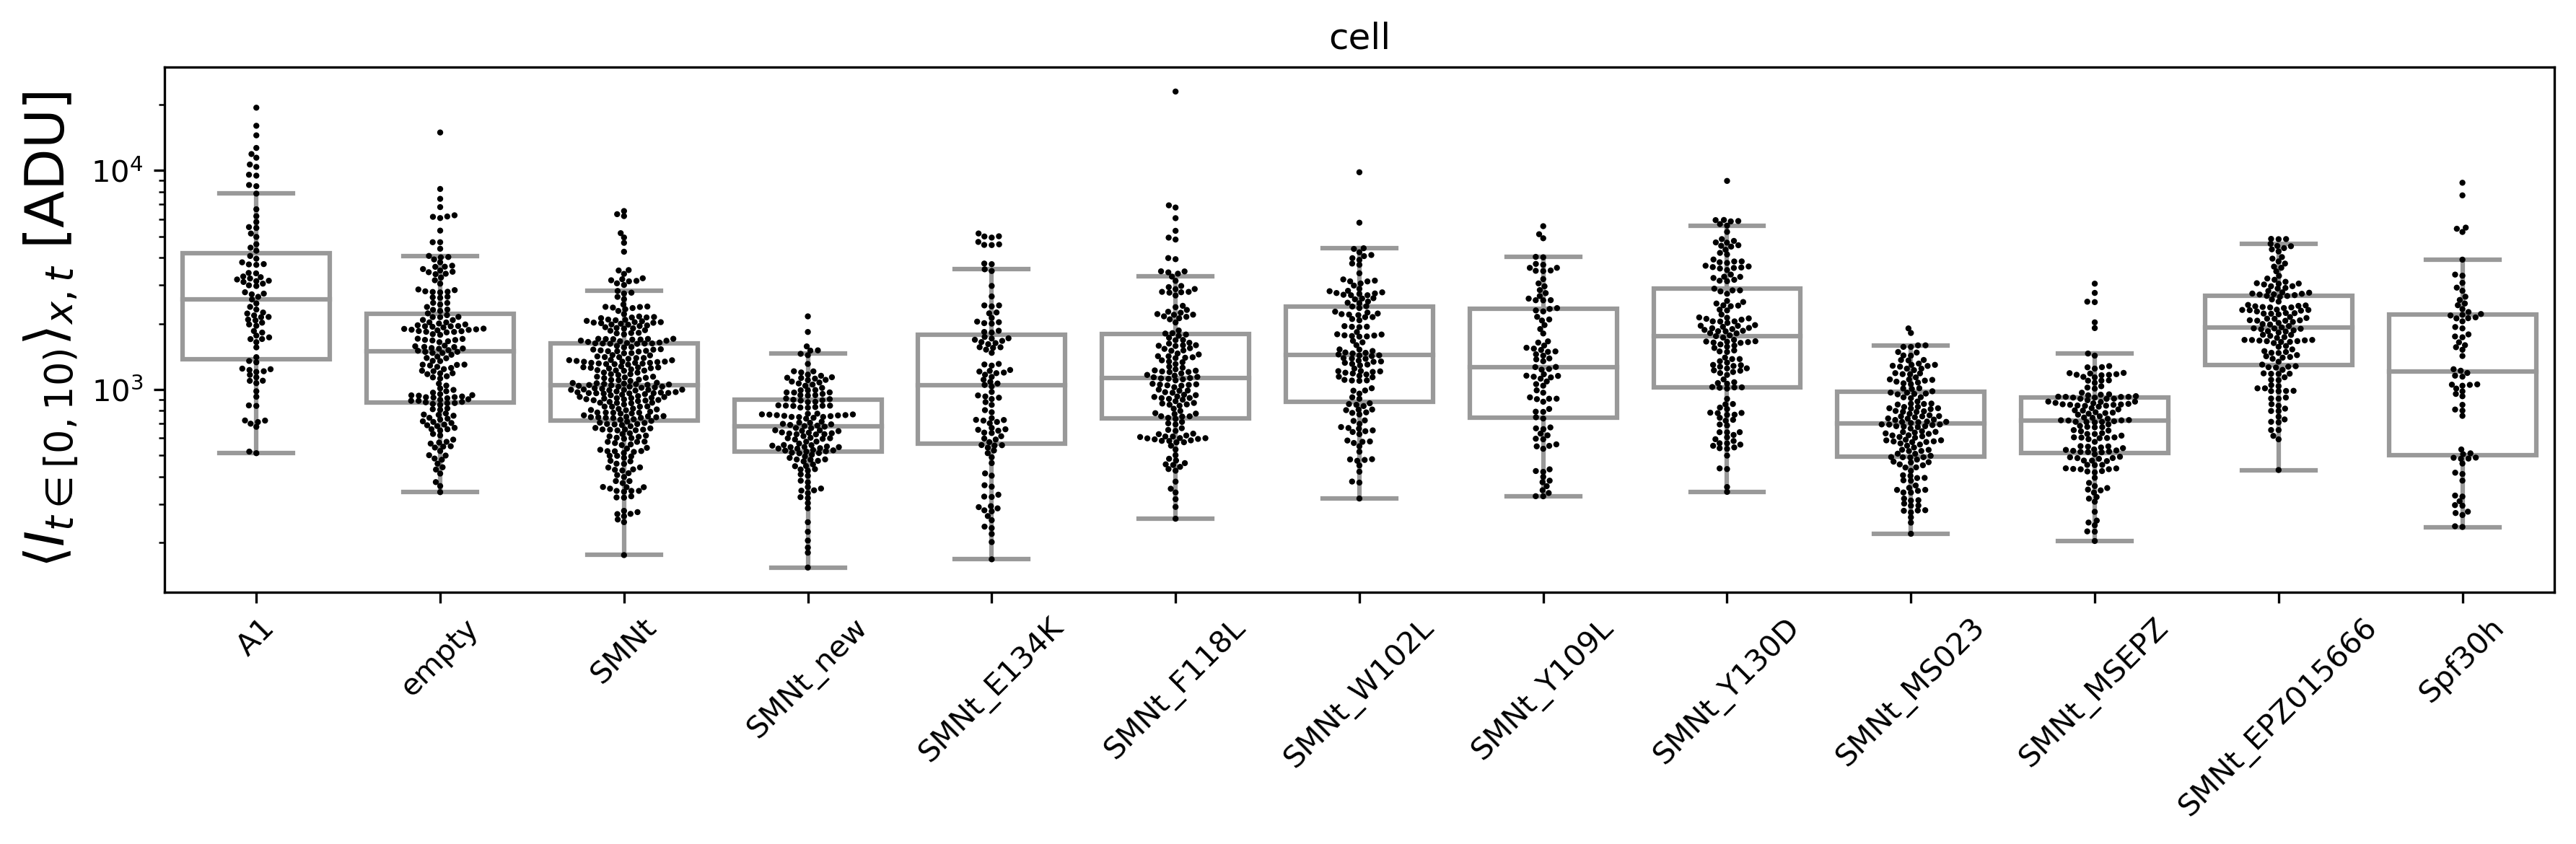

In [12]:
mean_intensity_10 = []
actual_keys = []
for k in keys:
    try:
        mean_intensity_10.append(raw_cluster_metrics[k]['mean_intensity_over_first_10_frames'])
        actual_keys.append(k)
    except KeyError as e:
        print('No data for %s' % k)
        continue
fig=plt.figure(figsize=(12, 4), dpi=dpi, facecolor='w', edgecolor='k')
bp = sns.boxplot(data=mean_intensity_10, fliersize=0, color='1.00')#, whis=[10, 90])
bp.set_yscale("log")
sp = sns.swarmplot(data=mean_intensity_10, size=2, color='k')
sp.set_yscale("log")
plt.plot([-0.5, 0.5 + len(mean_intensity_10)], [min_average_over_first_10, min_average_over_first_10], '--r')
plt.xticks(plt.xticks()[0], actual_keys, rotation=45)
plt.ylabel(r'$\langle I_{t\in[0, 10)} \rangle_{x,t}$ [%s]' % units, fontsize=18)
plt.title(mask)
plt.tight_layout()
plt.savefig(os.path.join(fig_dir, 'log_mean_intensity_first_10_frames_%s.pdf' % mask), dpi=dpi)
plt.show()

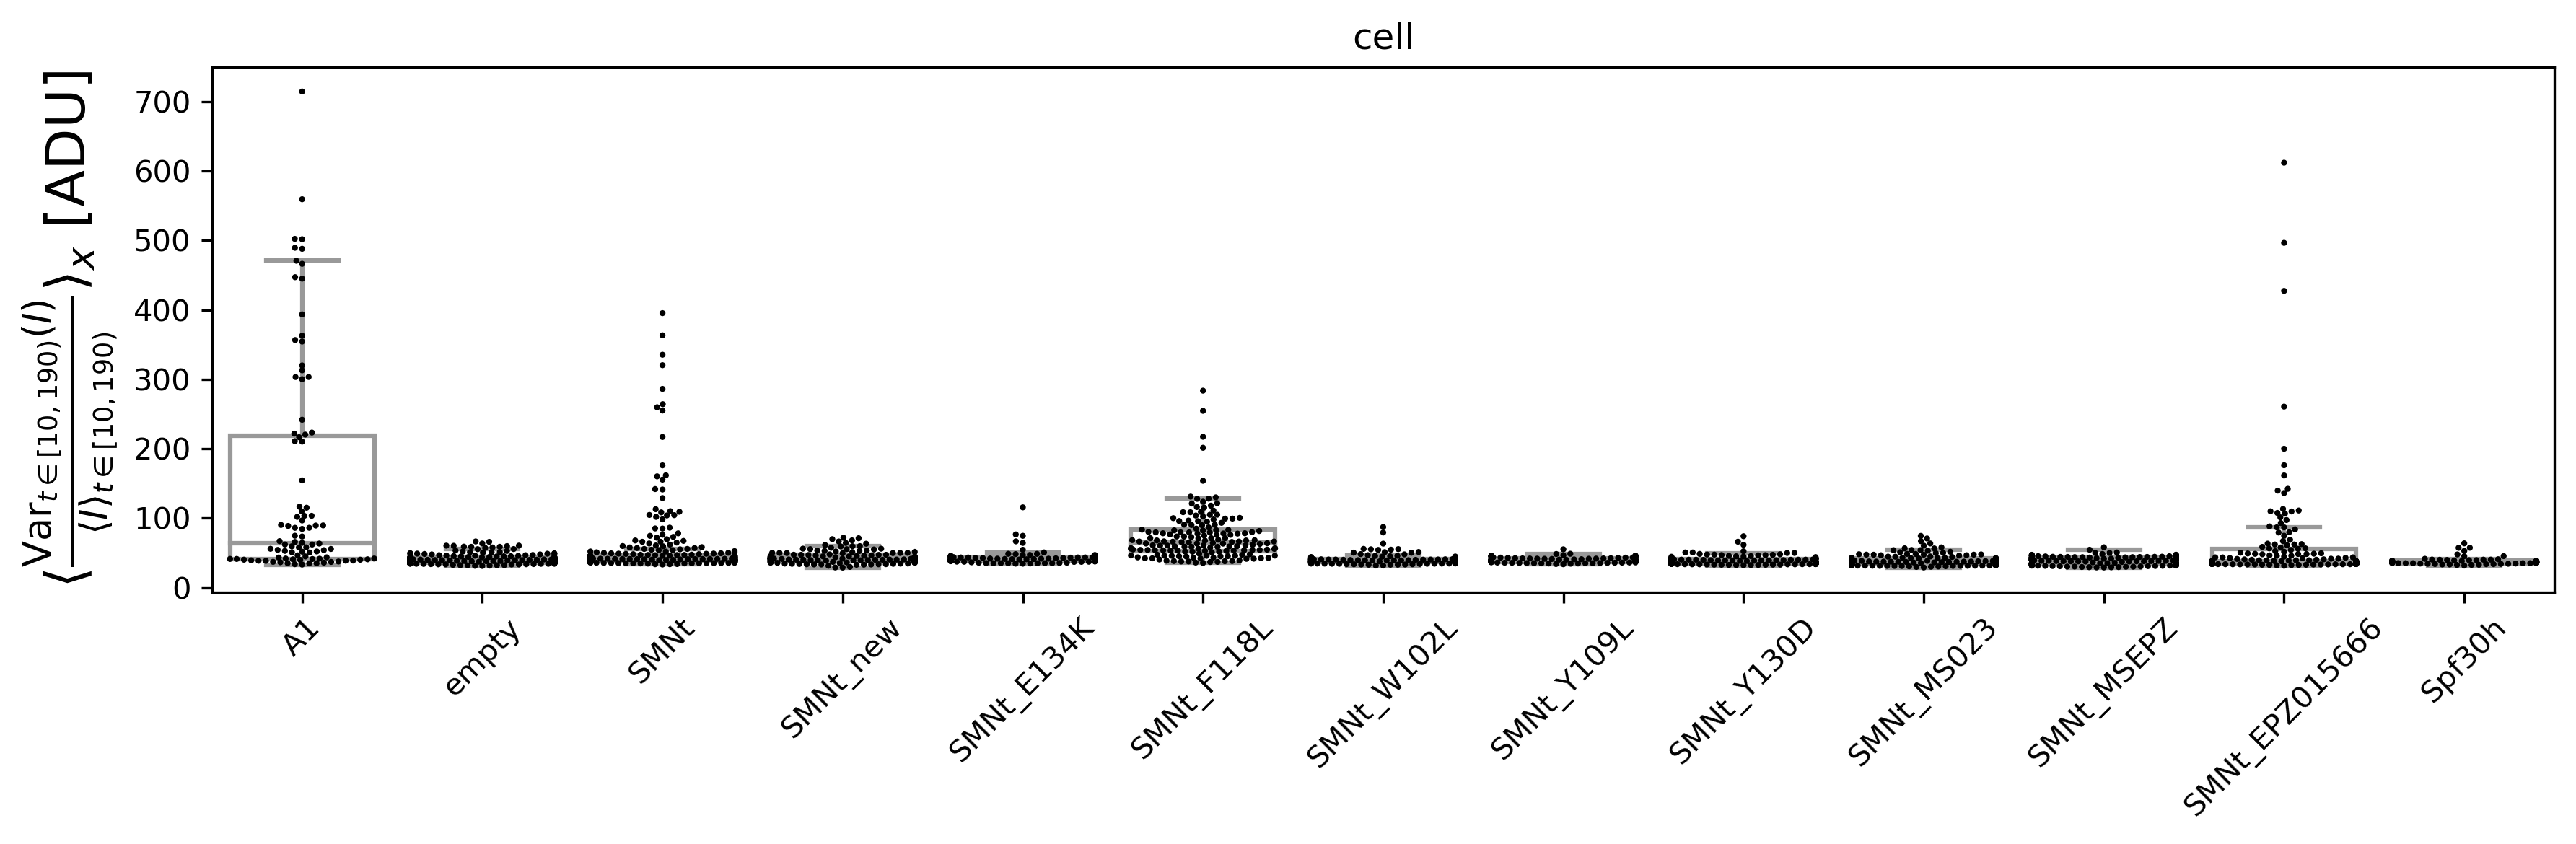

In [13]:
cm = []
actual_keys = []
for k in keys:
    try:
        cm.append(cluster_metrics[k]['variance_along_t_over_mean'])
        actual_keys.append(k)
    except KeyError as e:
        print('No data for %s, %s' % (k, mask))
        continue

fig=plt.figure(figsize=(12, 4), dpi=dpi, facecolor='w', edgecolor='k')
sns.boxplot(data=cm, fliersize=0, color='1.00')#, whis=[10, 90])
sns.swarmplot(data=cm, size=2, color='k')
plt.xticks(plt.xticks()[0], actual_keys, rotation=45)
plt.ylabel(r'$\langle \frac{\mathrm{Var}_{t\in[10, 190)}(I)}{\langle I \rangle_{t\in[10, 190)}} \rangle_x$ [%s]' % units, fontsize=18)
plt.title(mask)
plt.tight_layout()
plt.savefig(os.path.join(fig_dir, 'cluster_metric_%s.pdf' % mask), dpi=dpi)
plt.show()

In [14]:
# add rolling window mean and quantiles traces to the cluster_metrics dict
import pandas as pd
bin_width = 10
rollers = {}
for k in keys:
    try:
        cluster_metrics[k]['mean_intensity_over_first_10_frames']
    except KeyError as e:
        print('No data for %s, %s' % (k, mask))
        continue
    I = np.argsort(cluster_metrics[k]['mean_intensity_over_first_10_frames'])
    sorted_intensities = cluster_metrics[k]['mean_intensity_over_first_10_frames'][I]
    roller = pd.Series(cluster_metrics[k]['variance_along_t_over_mean'][I]).rolling(bin_width, 
                                                                                 center=True, 
                                                                                 min_periods=1)
    rollers[k] = {
        'sorted_intensities': sorted_intensities,
        'mean_variance_along_t_over_mean': np.asarray(roller.mean()),
        'mmstd_variance_along_t_over_mean': np.asarray(roller.mean()) - np.asarray(roller.std()),
        'mpstd_variance_along_t_over_mean': np.asarray(roller.mean()) + np.asarray(roller.std()),
        'p50_variance_along_t_over_mean': np.asarray(roller.quantile(0.5)),
        'p25_variance_along_t_over_mean': np.asarray(roller.quantile(0.25)),
        'p75_variance_along_t_over_mean': np.asarray(roller.quantile(0.75)),
    }

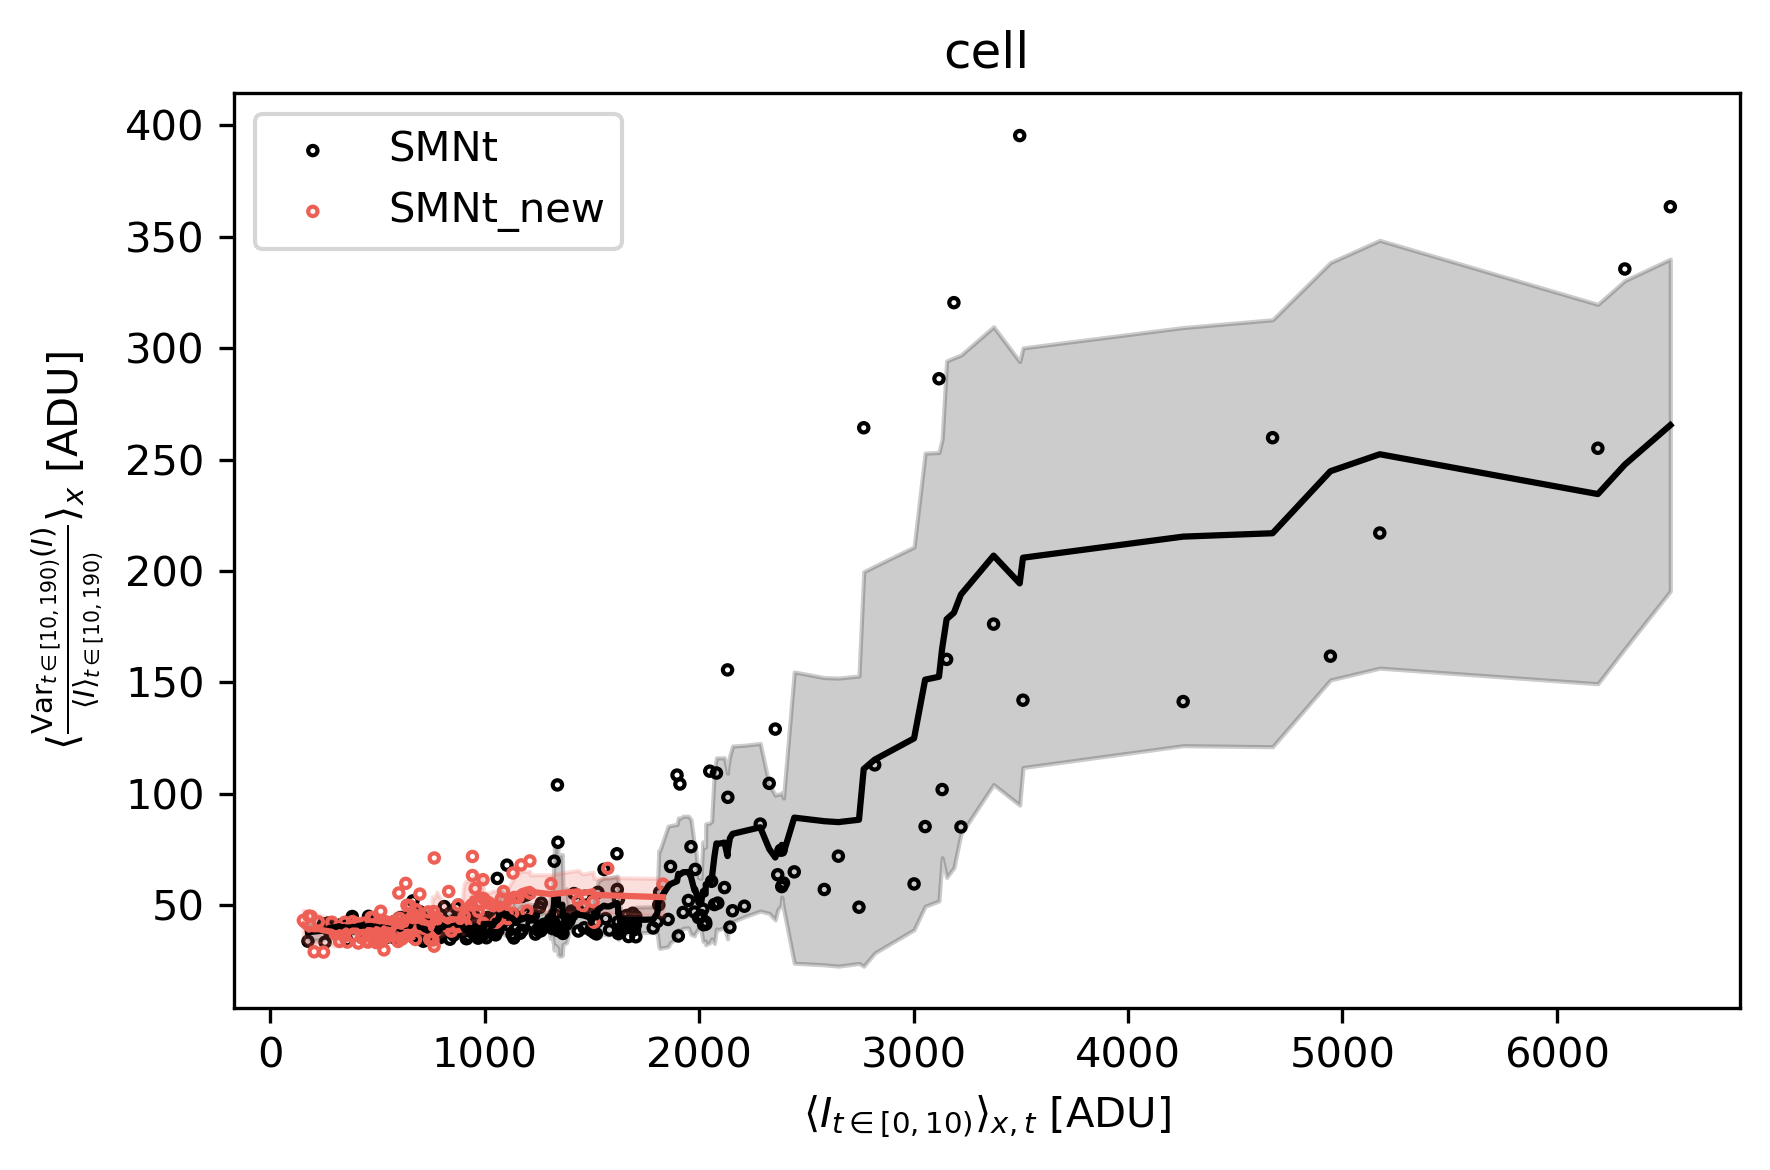

In [15]:
# 0 
to_plot = ['SMNt', 'SMNt_new']

colors = iter(pallette)
plt.figure(101, dpi=dpi)
plt.clf()
for k in to_plot:
    color = next(colors)

    plt.plot(rollers[k]['sorted_intensities'], 
         rollers[k]['mean_variance_along_t_over_mean'], '-', c=color)
    plt.fill_between(rollers[k]['sorted_intensities'], 
                     rollers[k]['mmstd_variance_along_t_over_mean'], 
                     rollers[k]['mpstd_variance_along_t_over_mean'], alpha=0.2, color=color)

    plt.scatter(cluster_metrics[k]['mean_intensity_over_first_10_frames'], 
             cluster_metrics[k]['variance_along_t_over_mean'],
             label=k, s=5, facecolors='none', edgecolors=color)

plt.xlabel(r'$\langle I_{t\in[0, 10)} \rangle_{x,t}$ [%s]' % units)
plt.ylabel(r'$\langle \frac{\mathrm{Var}_{t\in[10, 190)}(I)}{\langle I \rangle_{t\in[10, 190)}} \rangle_x$ [%s]' % units)
plt.title(mask)
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(fig_dir,'_'.join(to_plot) + '_%s.pdf' % mask), dpi=dpi)
plt.show()

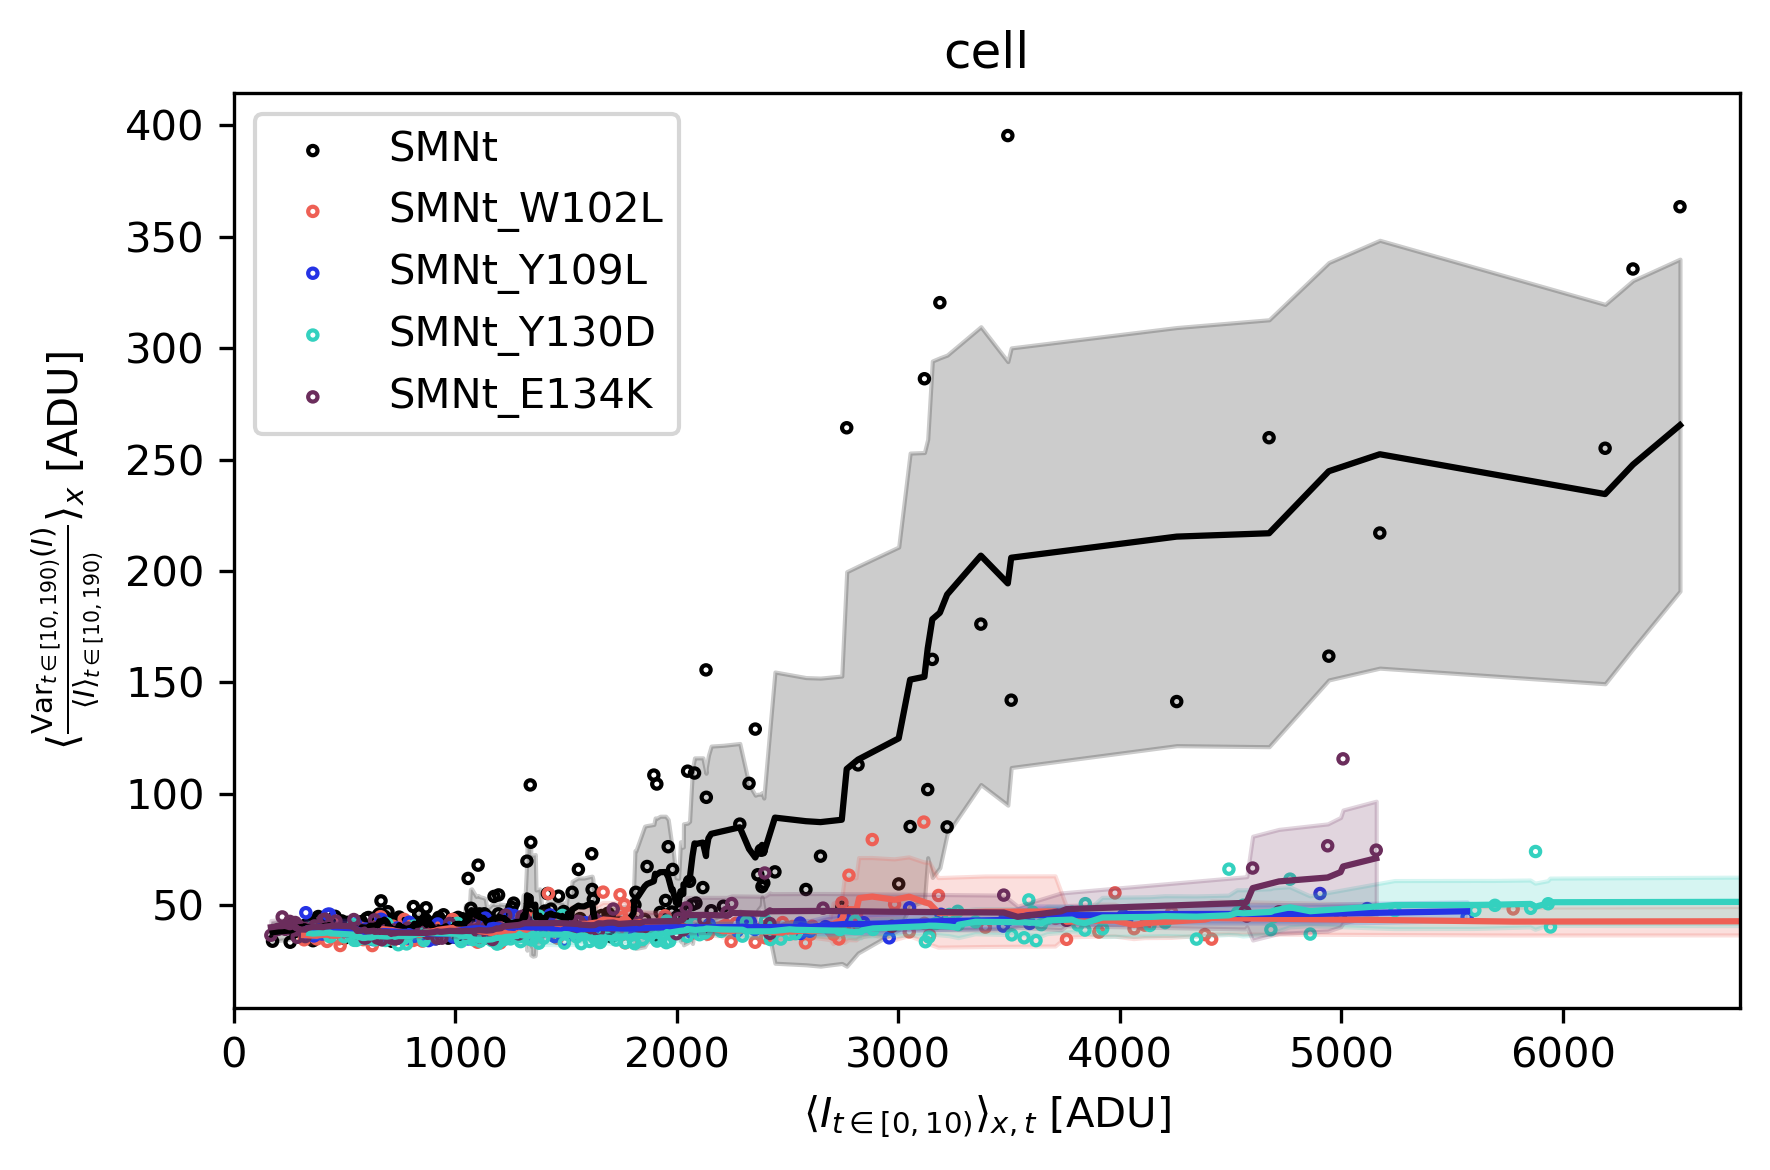

In [16]:
# 1 
to_plot = ['SMNt', 'SMNt_W102L', 'SMNt_Y109L', 'SMNt_Y130D', 'SMNt_E134K']
colors = iter(pallette)
plt.figure(101, dpi=dpi)
plt.clf()
for k in to_plot:
    color = next(colors)

    plt.plot(rollers[k]['sorted_intensities'], 
         rollers[k]['mean_variance_along_t_over_mean'], '-', c=color)
    plt.fill_between(rollers[k]['sorted_intensities'], 
                     rollers[k]['mmstd_variance_along_t_over_mean'], 
                     rollers[k]['mpstd_variance_along_t_over_mean'], alpha=0.2, color=color)

    plt.scatter(cluster_metrics[k]['mean_intensity_over_first_10_frames'], 
             cluster_metrics[k]['variance_along_t_over_mean'],
             label=k, s=5, facecolors='none', edgecolors=color)
    plt.xlim([0, 6800])

plt.xlabel(r'$\langle I_{t\in[0, 10)} \rangle_{x,t}$ [%s]' % units)
plt.ylabel(r'$\langle \frac{\mathrm{Var}_{t\in[10, 190)}(I)}{\langle I \rangle_{t\in[10, 190)}} \rangle_x$ [%s]' % units)
plt.title(mask)
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(fig_dir,'_'.join(to_plot) + '_%s.pdf' % mask), dpi=dpi)
plt.show()

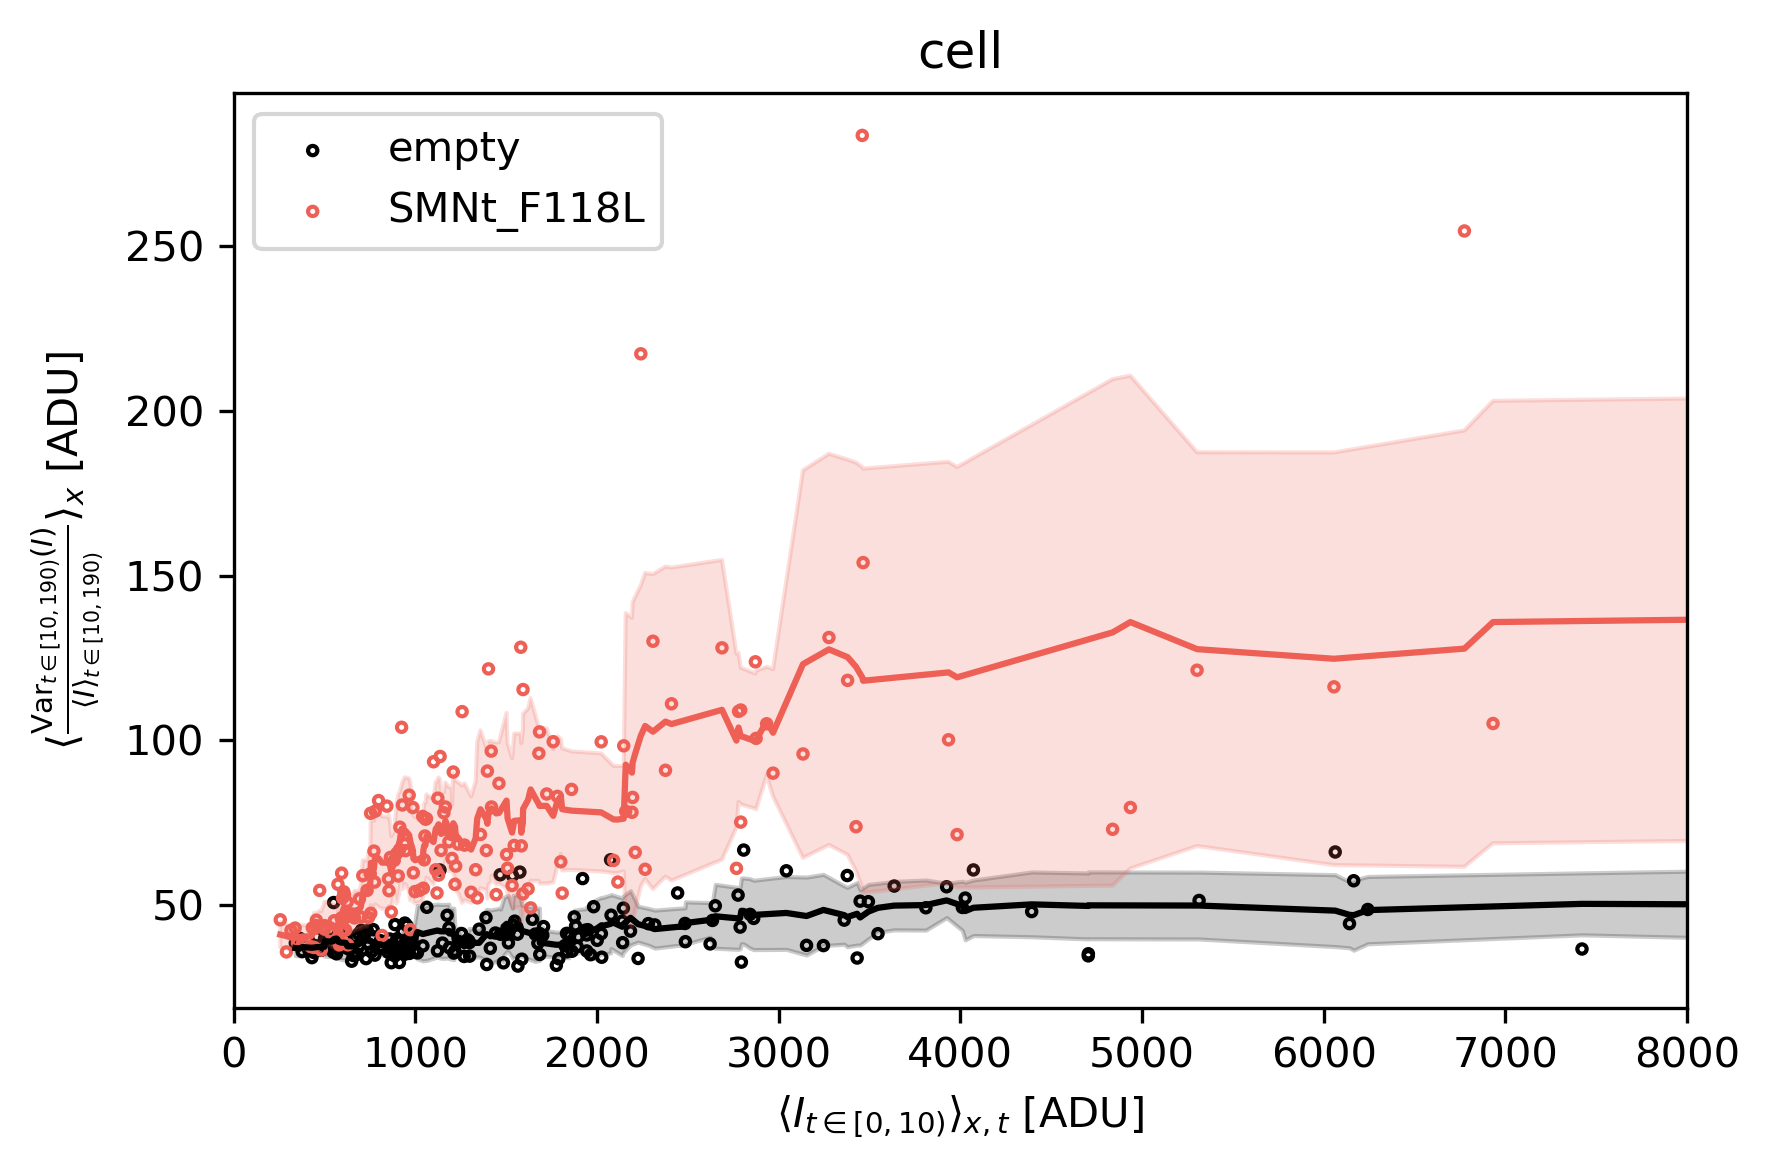

In [17]:
# 2
to_plot = ['empty', 'SMNt_F118L']
colors = iter(pallette)
plt.figure(101, dpi=dpi)
plt.clf()
for k in to_plot:
    color = next(colors)

    plt.plot(rollers[k]['sorted_intensities'], 
         rollers[k]['mean_variance_along_t_over_mean'], '-', c=color)
    plt.fill_between(rollers[k]['sorted_intensities'], 
                     rollers[k]['mmstd_variance_along_t_over_mean'], 
                     rollers[k]['mpstd_variance_along_t_over_mean'], alpha=0.2, color=color)

    plt.scatter(cluster_metrics[k]['mean_intensity_over_first_10_frames'], 
             cluster_metrics[k]['variance_along_t_over_mean'],
             label=k, s=5, facecolors='none', edgecolors=color)
    plt.xlim([0, 8000])

plt.xlabel(r'$\langle I_{t\in[0, 10)} \rangle_{x,t}$ [%s]' % units)
plt.ylabel(r'$\langle \frac{\mathrm{Var}_{t\in[10, 190)}(I)}{\langle I \rangle_{t\in[10, 190)}} \rangle_x$ [%s]' % units)
plt.title(mask)
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(fig_dir,'_'.join(to_plot) + '_%s.pdf' % mask), dpi=dpi)
plt.show()

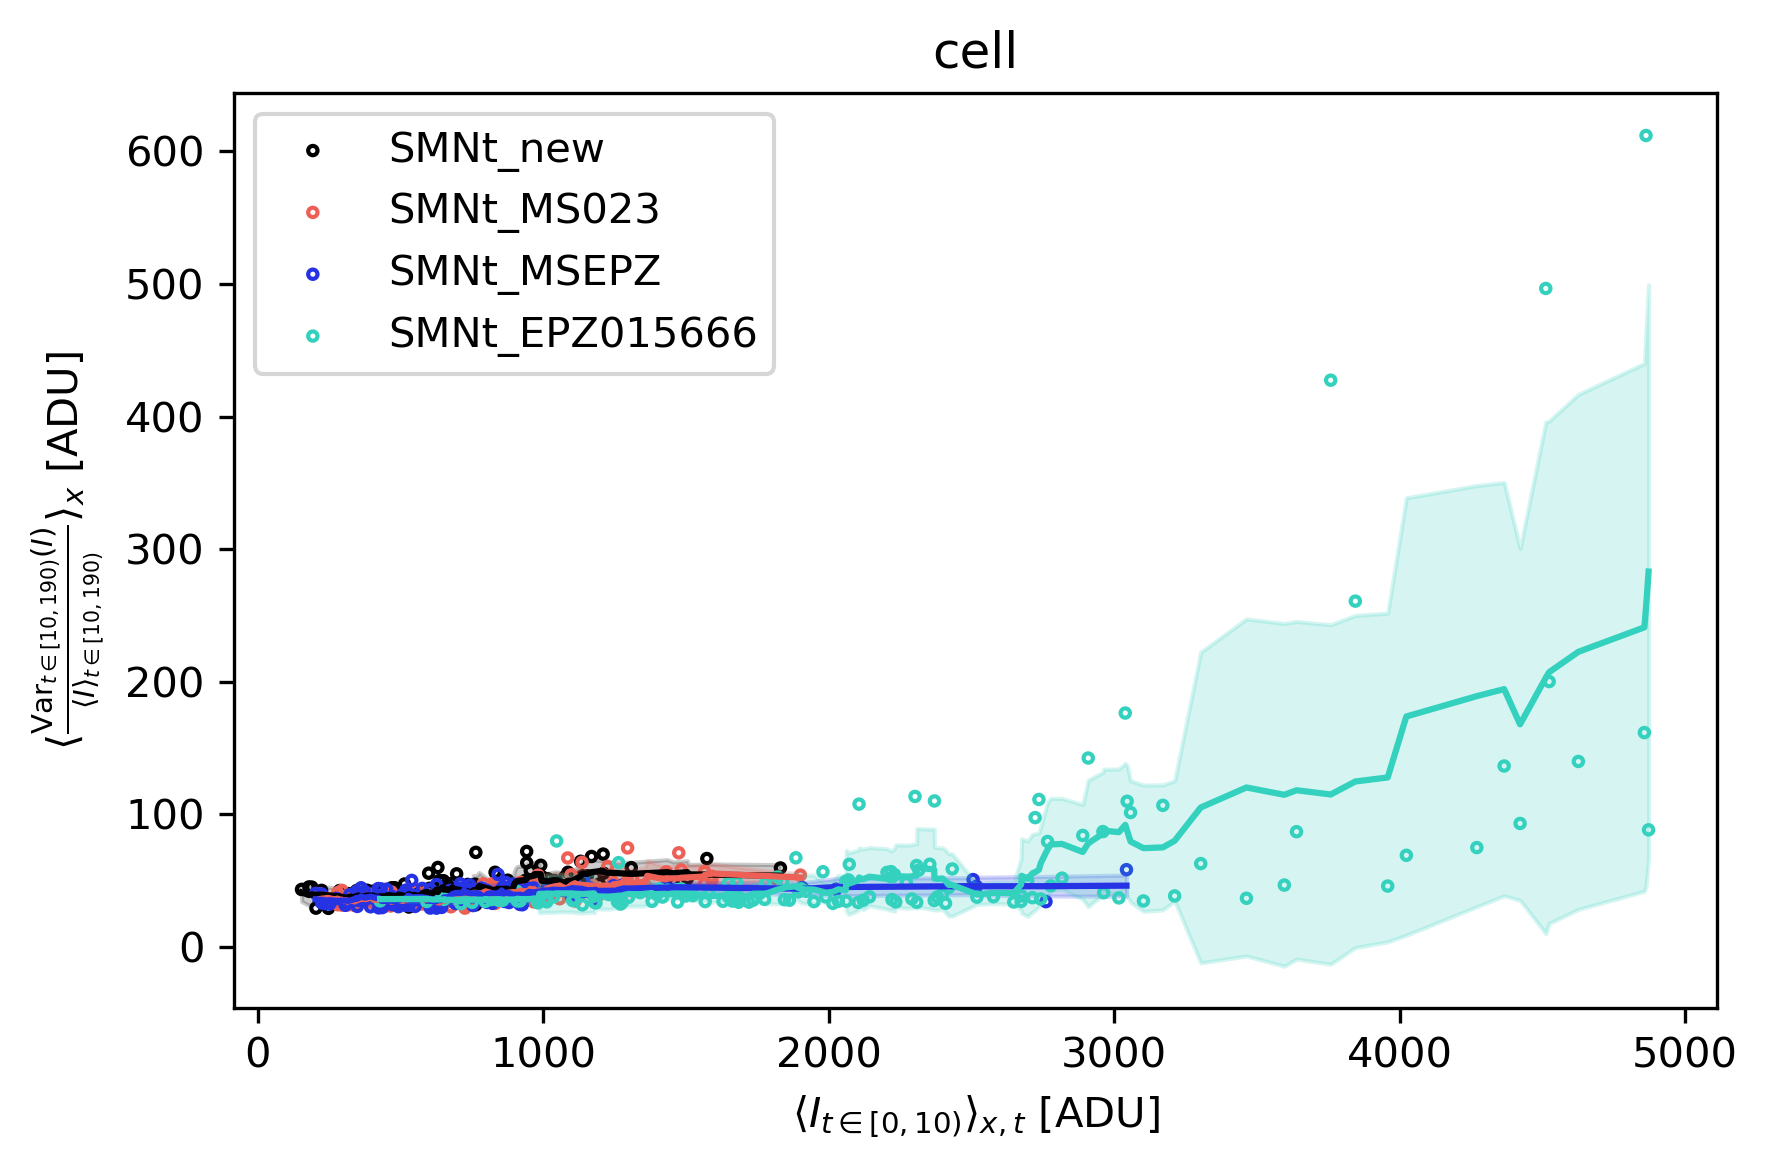

In [18]:
# 3
to_plot = ['SMNt_new', 'SMNt_MS023', 'SMNt_MSEPZ', 'SMNt_EPZ015666']
colors = iter(pallette)
plt.figure(101, dpi=dpi)
plt.clf()
for k in to_plot:
    color = next(colors)

    plt.plot(rollers[k]['sorted_intensities'], 
         rollers[k]['mean_variance_along_t_over_mean'], '-', c=color)
    plt.fill_between(rollers[k]['sorted_intensities'], 
                     rollers[k]['mmstd_variance_along_t_over_mean'], 
                     rollers[k]['mpstd_variance_along_t_over_mean'], alpha=0.2, color=color)

    plt.scatter(cluster_metrics[k]['mean_intensity_over_first_10_frames'], 
             cluster_metrics[k]['variance_along_t_over_mean'],
             label=k, s=5, facecolors='none', edgecolors=color)
#         plt.ylim([0, 3.75])
#         plt.xlim([0, 65])

plt.xlabel(r'$\langle I_{t\in[0, 10)} \rangle_{x,t}$ [%s]' % units)
plt.ylabel(r'$\langle \frac{\mathrm{Var}_{t\in[10, 190)}(I)}{\langle I \rangle_{t\in[10, 190)}} \rangle_x$ [%s]' % units)
plt.title(mask)
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(fig_dir,'_'.join(to_plot) + '_%s.pdf' % mask), dpi=dpi)
plt.show()

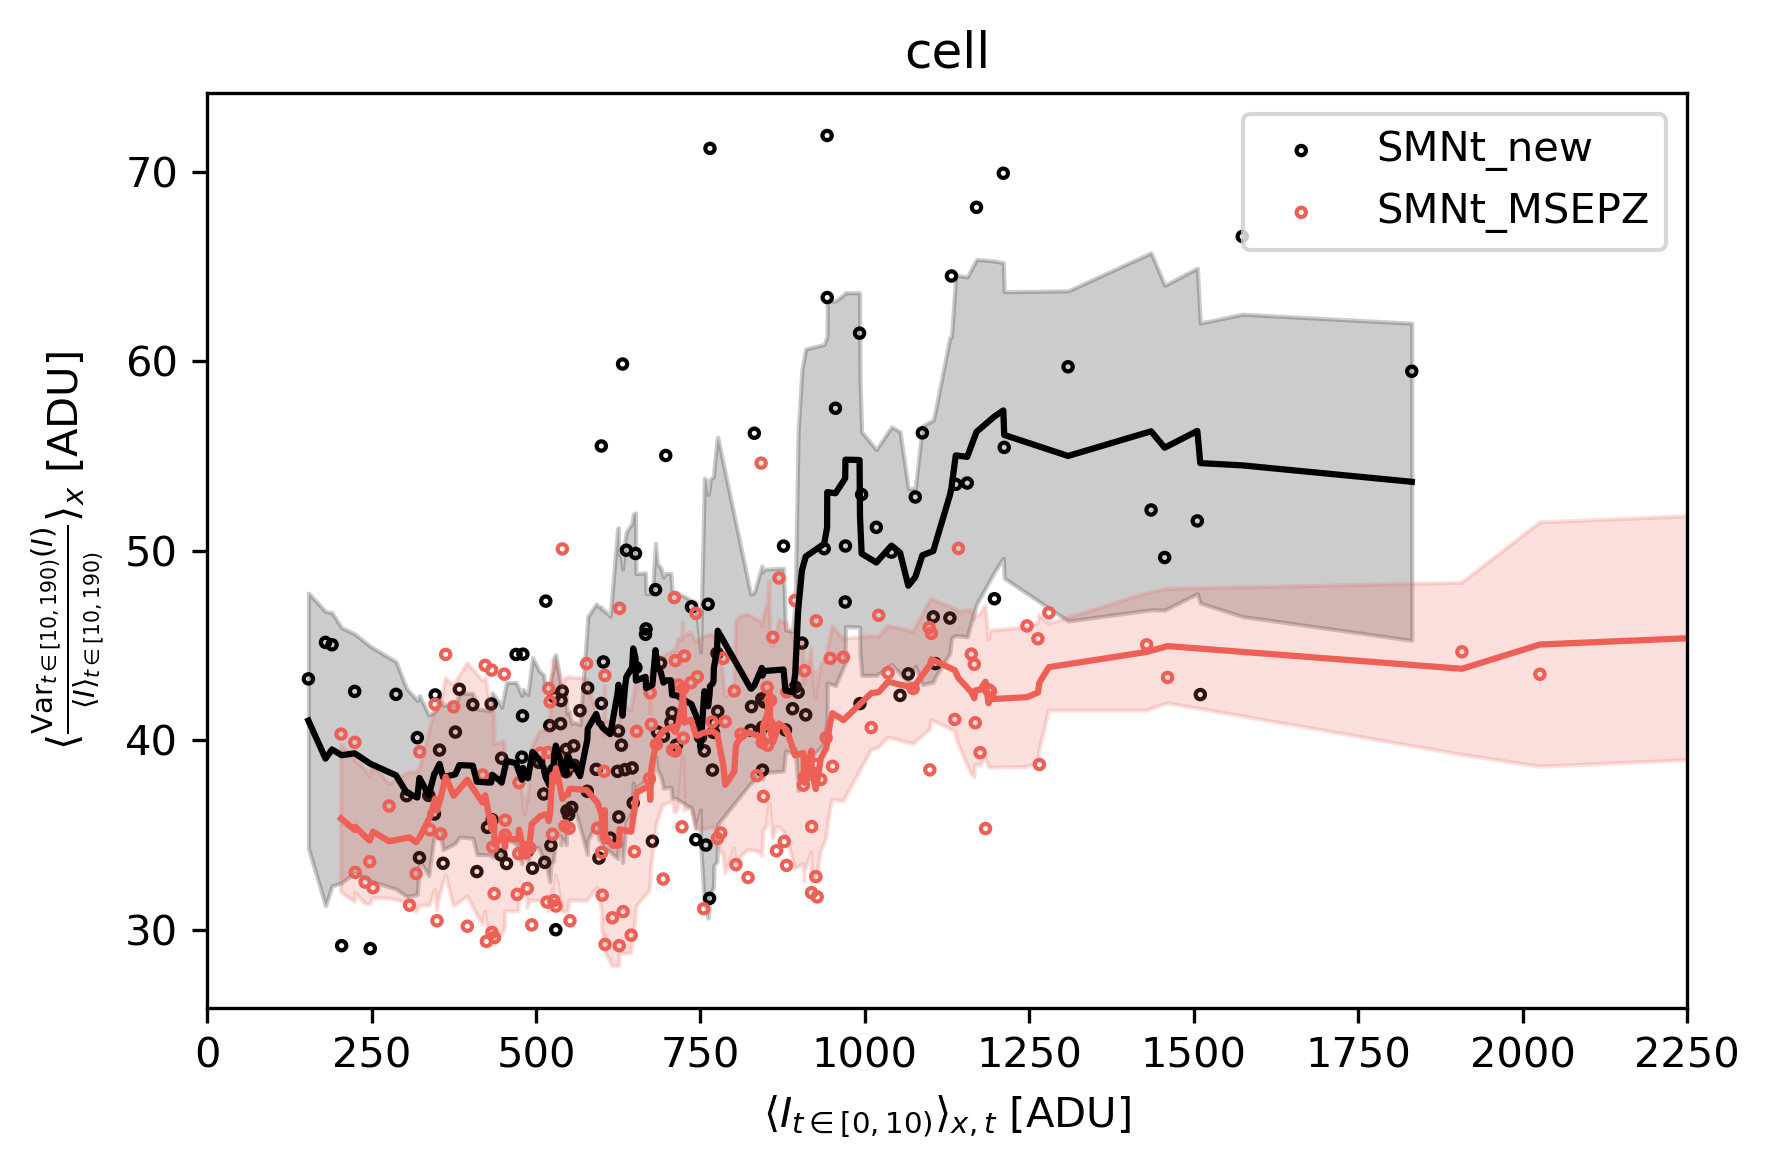

In [19]:
# 4
to_plot = ['SMNt_new', 'SMNt_MSEPZ']
colors = iter(pallette)
plt.figure(101, dpi=dpi)
plt.clf()
for k in to_plot:
    color = next(colors)

    plt.plot(rollers[k]['sorted_intensities'], 
         rollers[k]['mean_variance_along_t_over_mean'], '-', c=color)
    plt.fill_between(rollers[k]['sorted_intensities'], 
                     rollers[k]['mmstd_variance_along_t_over_mean'], 
                     rollers[k]['mpstd_variance_along_t_over_mean'], alpha=0.2, color=color)

    plt.scatter(cluster_metrics[k]['mean_intensity_over_first_10_frames'], 
             cluster_metrics[k]['variance_along_t_over_mean'],
             label=k, s=5, facecolors='none', edgecolors=color)
#         plt.ylim([0, 3.75])
    plt.xlim([0, 2250])

plt.xlabel(r'$\langle I_{t\in[0, 10)} \rangle_{x,t}$ [%s]' % units)
plt.ylabel(r'$\langle \frac{\mathrm{Var}_{t\in[10, 190)}(I)}{\langle I \rangle_{t\in[10, 190)}} \rangle_x$ [%s]' % units)
plt.title(mask)
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(fig_dir,'_'.join(to_plot) + '_%s.pdf' % mask), dpi=dpi)
plt.show()

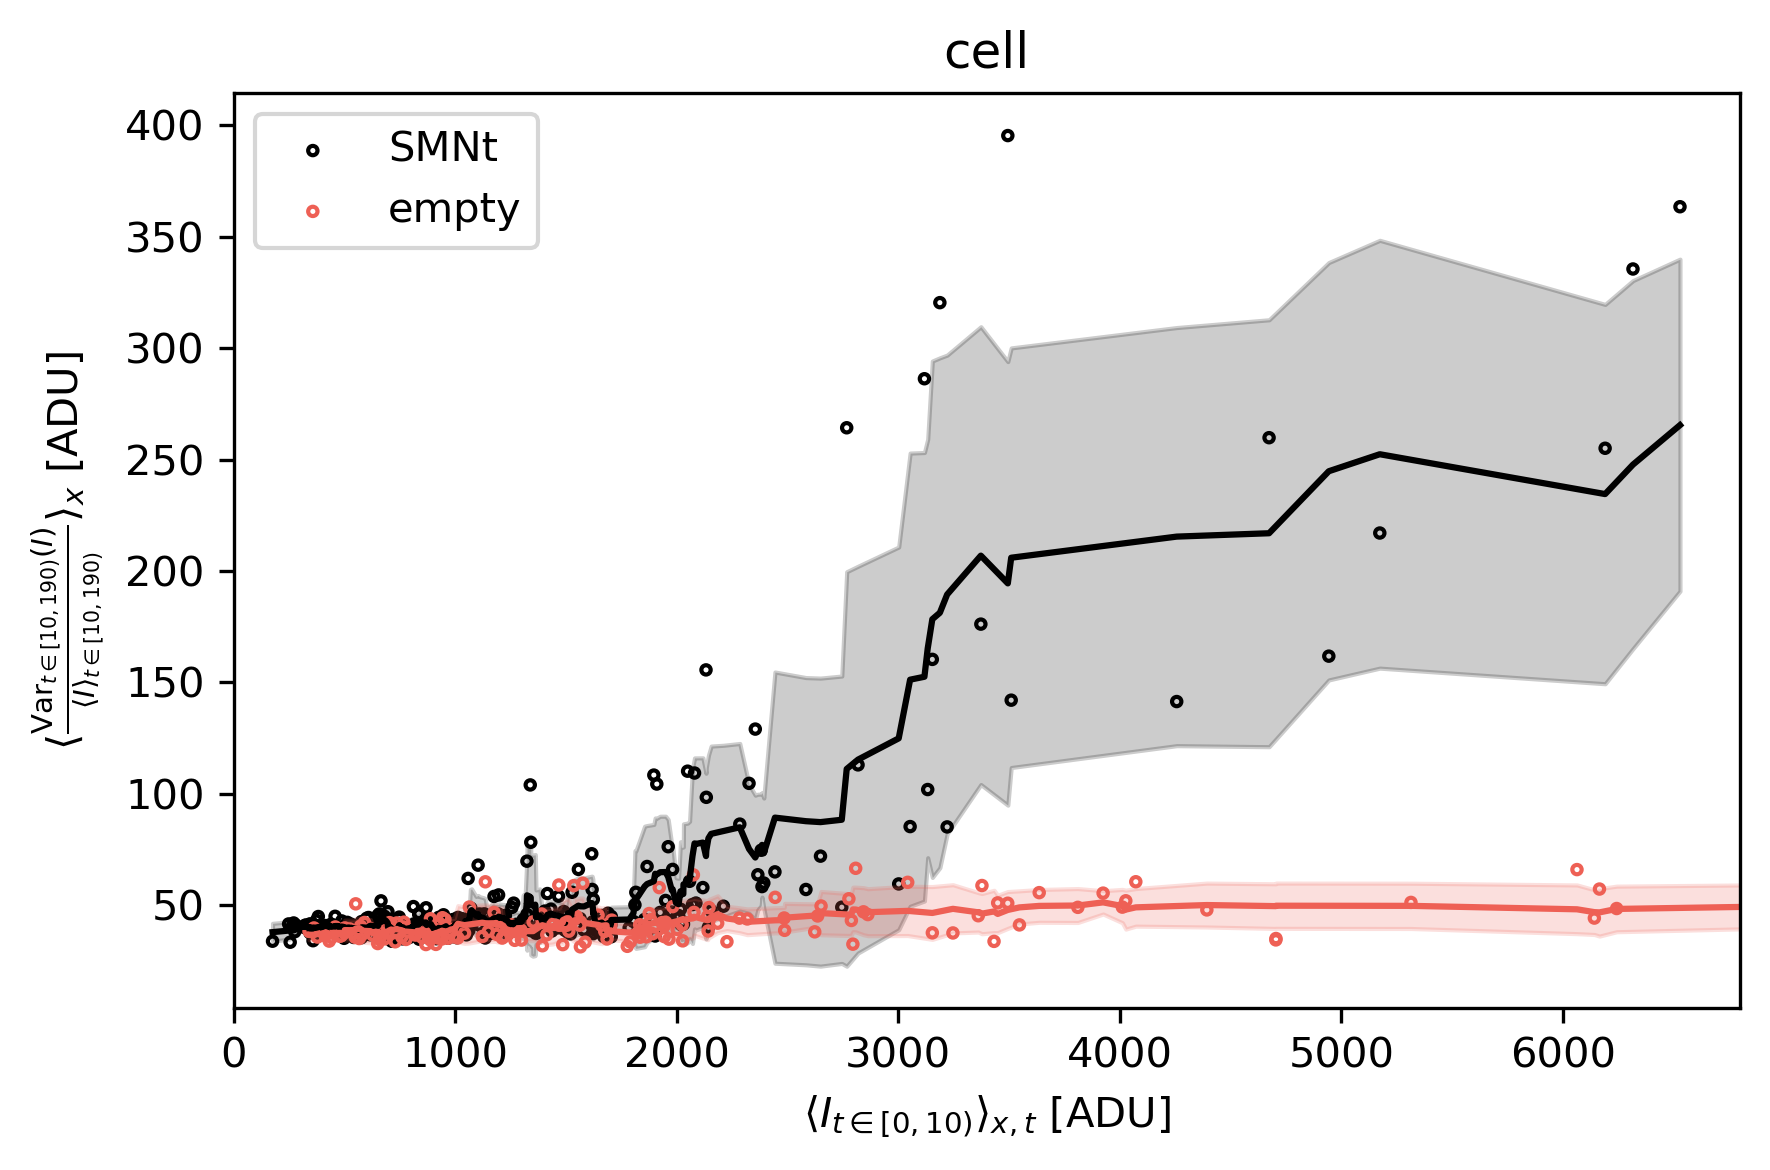

In [20]:
# 5
to_plot = ['SMNt', 'empty']
colors = iter(pallette)
plt.figure(101, dpi=dpi)
plt.clf()
for k in to_plot:
    color = next(colors)

    plt.plot(rollers[k]['sorted_intensities'], 
         rollers[k]['mean_variance_along_t_over_mean'], '-', c=color)
    plt.fill_between(rollers[k]['sorted_intensities'], 
                     rollers[k]['mmstd_variance_along_t_over_mean'], 
                     rollers[k]['mpstd_variance_along_t_over_mean'], alpha=0.2, color=color)

    plt.scatter(cluster_metrics[k]['mean_intensity_over_first_10_frames'], 
             cluster_metrics[k]['variance_along_t_over_mean'],
             label=k, s=5, facecolors='none', edgecolors=color)
#         plt.ylim([0, 3.75])
    plt.xlim([0, 6800])

plt.xlabel(r'$\langle I_{t\in[0, 10)} \rangle_{x,t}$ [%s]' % units)
plt.ylabel(r'$\langle \frac{\mathrm{Var}_{t\in[10, 190)}(I)}{\langle I \rangle_{t\in[10, 190)}} \rangle_x$ [%s]' % units)
plt.title(mask)
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(fig_dir,'_'.join(to_plot) + '_%s.pdf' % mask), dpi=dpi)
plt.show()

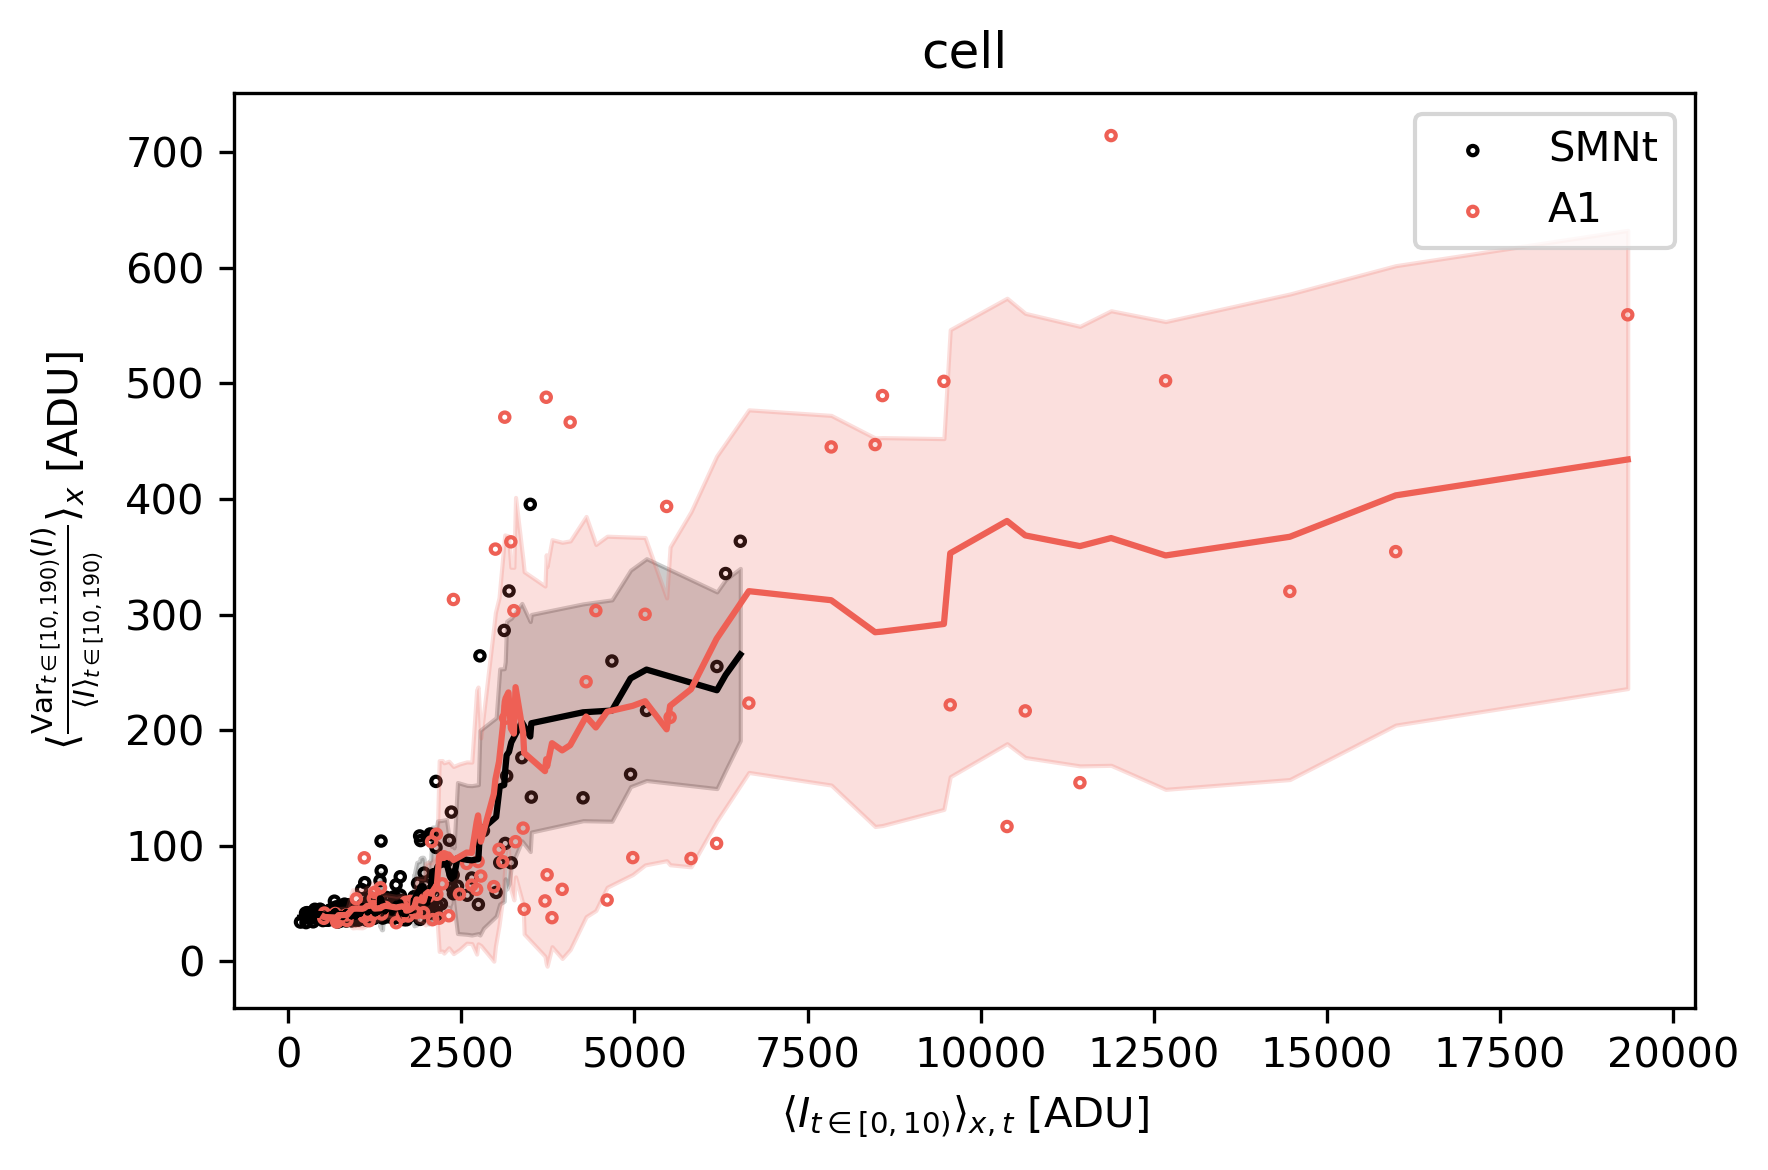

In [21]:
# 6
to_plot = ['SMNt', 'A1']
colors = iter(pallette)
plt.figure(101, dpi=dpi)
plt.clf()
for k in to_plot:
    color = next(colors)

    plt.plot(rollers[k]['sorted_intensities'], 
         rollers[k]['mean_variance_along_t_over_mean'], '-', c=color)
    plt.fill_between(rollers[k]['sorted_intensities'], 
                     rollers[k]['mmstd_variance_along_t_over_mean'], 
                     rollers[k]['mpstd_variance_along_t_over_mean'], alpha=0.2, color=color)

    plt.scatter(cluster_metrics[k]['mean_intensity_over_first_10_frames'], 
             cluster_metrics[k]['variance_along_t_over_mean'],
             label=k, s=5, facecolors='none', edgecolors=color)

plt.xlabel(r'$\langle I_{t\in[0, 10)} \rangle_{x,t}$ [%s]' % units)
plt.ylabel(r'$\langle \frac{\mathrm{Var}_{t\in[10, 190)}(I)}{\langle I \rangle_{t\in[10, 190)}} \rangle_x$ [%s]' % units)
plt.title(mask)
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(fig_dir,'_'.join(to_plot) + '_%s.pdf' % mask), dpi=dpi)
plt.show()

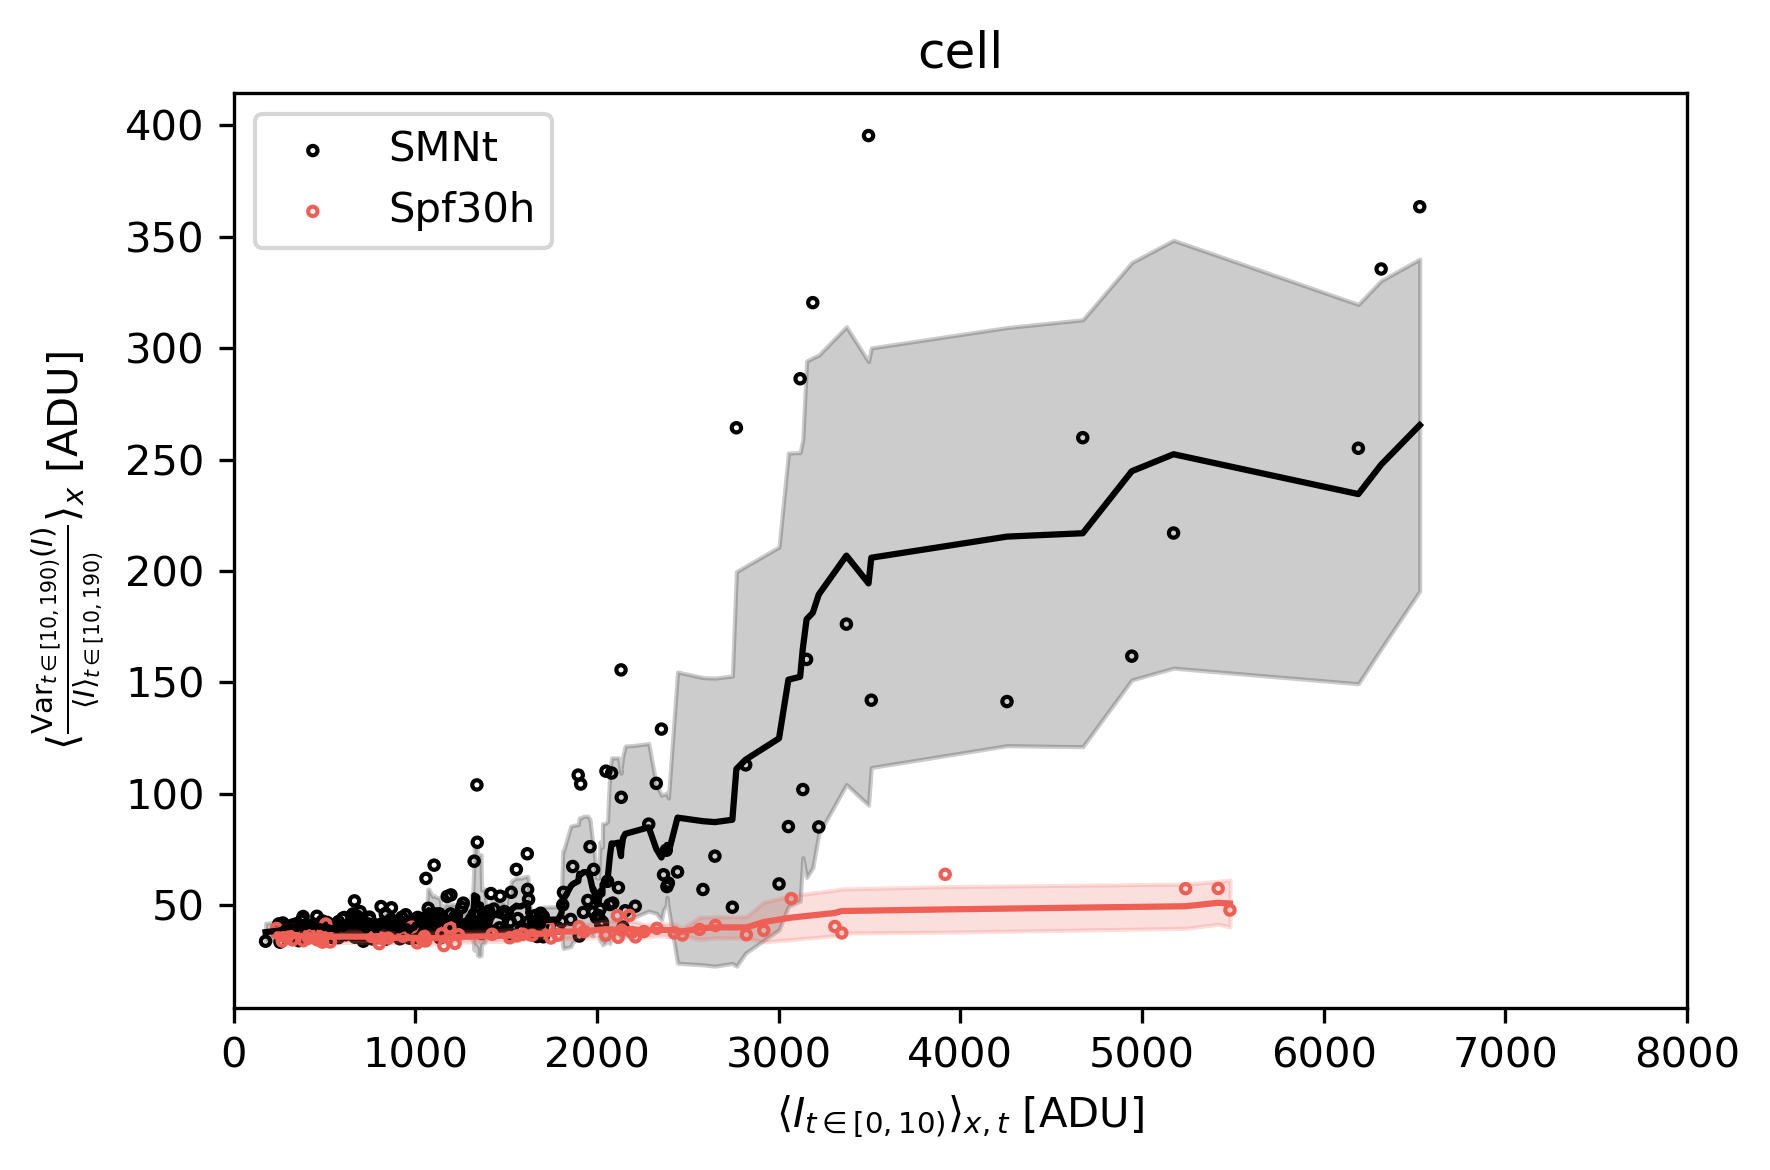

In [22]:
# 7
to_plot = ['SMNt', 'Spf30h']
colors = iter(pallette)
plt.figure(101, dpi=dpi)
plt.clf()
for k in to_plot:
    color = next(colors)

    plt.plot(rollers[k]['sorted_intensities'], 
         rollers[k]['mean_variance_along_t_over_mean'], '-', c=color)
    plt.fill_between(rollers[k]['sorted_intensities'], 
                     rollers[k]['mmstd_variance_along_t_over_mean'], 
                     rollers[k]['mpstd_variance_along_t_over_mean'], alpha=0.2, color=color)

    plt.scatter(cluster_metrics[k]['mean_intensity_over_first_10_frames'], 
             cluster_metrics[k]['variance_along_t_over_mean'],
             label=k, s=5, facecolors='none', edgecolors=color)
    plt.xlim([0, 8000])

plt.xlabel(r'$\langle I_{t\in[0, 10)} \rangle_{x,t}$ [%s]' % units)
plt.ylabel(r'$\langle \frac{\mathrm{Var}_{t\in[10, 190)}(I)}{\langle I \rangle_{t\in[10, 190)}} \rangle_x$ [%s]' % units)
plt.title(mask)
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(fig_dir,'_'.join(to_plot) + '_%s.pdf' % mask), dpi=dpi)
plt.show()

In [23]:
# Define what "clustering" as statistically meaningful deviation from "empty" distribution
for k in keys:
    n = len(cluster_metrics[k])
    print('%s, N=%d' % (k, n))
    clustered = np.empty(n)  # as a p value
    for pind in range(len(cluster_metrics[k])):
        # always compare to empty. Note that we could alternatively compare to ~lowest clustering 10 in a key
        u, p = stats.mannwhitneyu(cluster_metrics['empty']['variance_along_t_over_mean'][:], 
                                  np.asarray([cluster_metrics[k]['variance_along_t_over_mean'][pind]]), 
                                  use_continuity=True, alternative='two-sided')
        clustered[pind] = p
        # add the column to our data container
        cluster_metrics[k] = tabular.MappingFilter(cluster_metrics[k])
        cluster_metrics[k].addColumn('p_clustered', clustered)

A1, N=91
empty, N=174
SMNt, N=305
SMNt_new, N=141
SMNt_E134K, N=107
SMNt_F118L, N=159
SMNt_W102L, N=138
SMNt_Y109L, N=90
SMNt_Y130D, N=148
SMNt_MS023, N=154
SMNt_MSEPZ, N=148
SMNt_EPZ015666, N=148
Spf30h, N=69


In [24]:
# apply the cluster threshold to a new cm dict, additionally trying to get a feel for what cluster metric 
# corresponds with that threshold
p_cluster_threshold = 0.2
cm_filt = {}
closest_to_thresh = {'cluster_metric': 0., 'p': 0., 'abs_p_difference': 0.99}
for k in keys:
    cm_filt[k] = tabular.ResultsFilter(cluster_metrics[k], p_clustered=[0, p_cluster_threshold])
    # figure out what cluster metric ~corresponds to the p threshold we just picked
    p_dif = np.abs(cluster_metrics[k]['p_clustered'] - p_cluster_threshold)
    p_dif_argmin = np.argmin(p_dif)
    abs_p_diff = p_dif[p_dif_argmin]
    if abs_p_diff < closest_to_thresh['abs_p_difference']:
        closest_to_thresh.update({
            'cluster_metric': cluster_metrics[k]['variance_along_t_over_mean'][p_dif_argmin],
            'p': cluster_metrics[k]['p_clustered'][p_dif_argmin],
            'abs_p_difference': abs_p_diff
        })
print(closest_to_thresh)

In [ ]:
# try to find what value of cluster metric would give us the p value we thresholded on using a fit
# NB - test is rank-sum, so not all values of p are possible given a finite set of observations 
from scipy.optimize import minimize
def find_cm_for_p_cluster(cm, p_cluster_threshold, unclustered_cluster_metrics):
    u, p = stats.mannwhitneyu(unclustered_cluster_metrics, np.asarray(cm), use_continuity=True, 
                              alternative='two-sided')
    print('cluster metric: %.16f, p: %.16f' % (cm[0], p))
    return abs(p - p_cluster_threshold)
minimize(find_cm_for_p_cluster, np.asarray([closest_to_thresh['cluster_metric']]), args=(p_cluster_threshold, 
                                                                           cluster_metrics['empty']['variance_along_t_over_mean'][:]),
        tol=1e-8, method='Nelder-Mead')

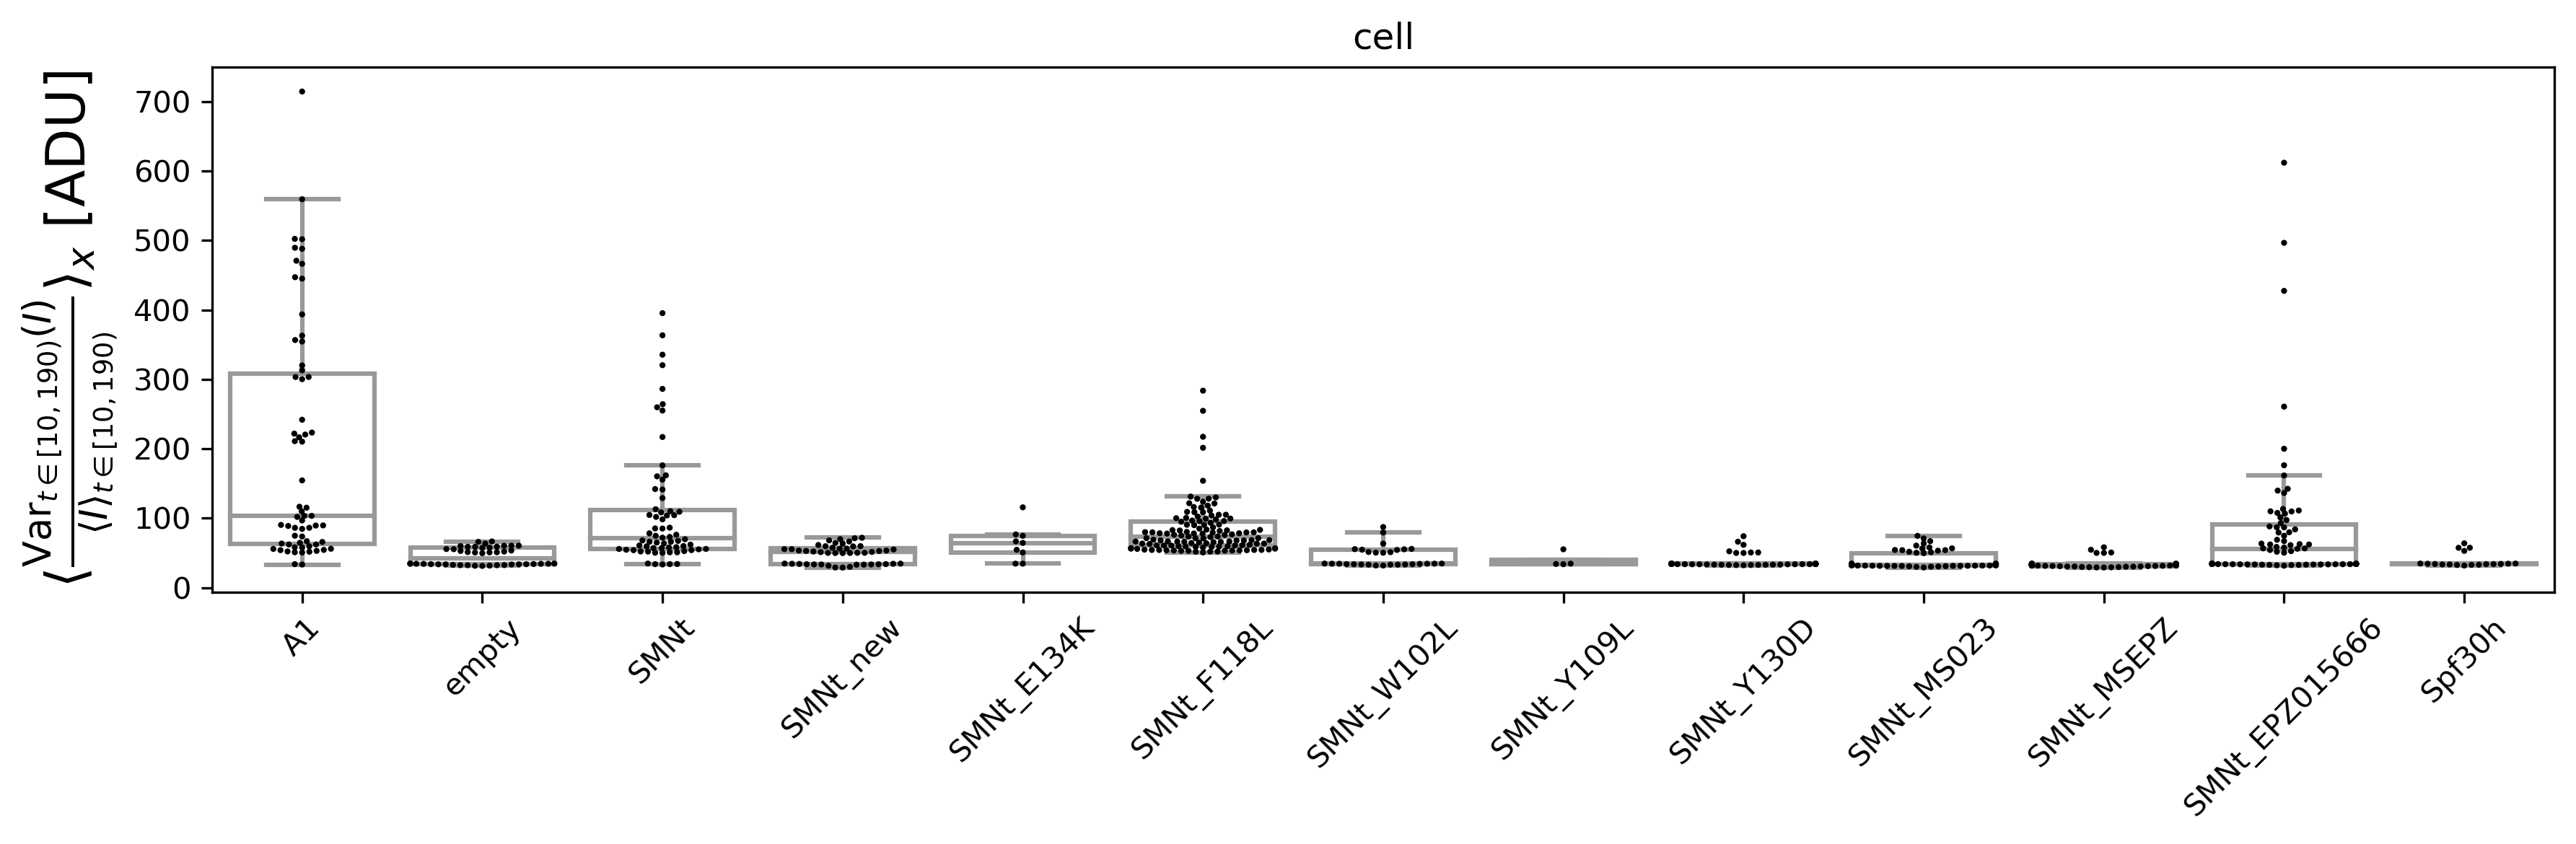

In [25]:
# NB - use cm_filt instead of cluster_metrics from here on out if you want the p-value filtering
cm = []
actual_keys = []
for k in keys:
    try:
        cm.append(cm_filt[k]['variance_along_t_over_mean'])
        actual_keys.append(k)
    except KeyError as e:
        print('No data for %s, %s' % (k, mask))
        continue

fig=plt.figure(figsize=(12, 4), dpi=dpi, facecolor='w', edgecolor='k')
sns.boxplot(data=cm, fliersize=0, color='1.00')#, whis=[10, 90])
sns.swarmplot(data=cm, size=2, color='k')
plt.xticks(plt.xticks()[0], actual_keys, rotation=45)
plt.ylabel(r'$\langle \frac{\mathrm{Var}_{t\in[10, 190)}(I)}{\langle I \rangle_{t\in[10, 190)}} \rangle_x$ [%s]' % units, fontsize=18)
plt.title(mask)
plt.tight_layout()
plt.savefig(os.path.join(fig_dir, 'cluster_metric_pfiltered_%s.pdf' % mask), dpi=dpi)
plt.show()